# An interpretable prediction system for the Site Of Origin (SOO) of Outflow Tract Ventricular Arrhythmias (OTVAs)

## 0. Starting point

See first the [README](README.md) for a general introduction to the project. We will start analyzing what we have as input, and how will we approach the tasks given our restrictions (dataset, interpretability, fast inference).

### 0.1. About the dataset

We were provided with a dataset with anonymous data from Teknon Medical Center, Barcelona, Spain. As explained in the [release](https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip), the dataset contains electrocardiogram (ECG) recordings and demographic information from patients with Outflow Tract Ventricular Arrhythmias (OTVAs). Each case includes several 12-lead ECG signal segment (of 2.5 seconds), patient demographic data (age, sex, height, weight,...), and clinician-validated labels indicating the arrhythmia's Site of Origin (SOO). The SOO labels include Left Ventricular Outflow Tract (LVOT), Right Ventricular Outflow Tract (RVOT), and for LVOT cases, further classification into Right Coronary Cusp (RCC) or aortomitral commissure (COMMISSURE) origins among others. 

The following code retrieves the dataset from the release and unzips it into `dataset/` folder, from which we will later load the data and perform the preprocessing. This allows 1:1 reproducibility of the results by performing this notebook's logic on the same input data.


In [16]:
# Standard library packages:
import os
import urllib.request
import zipfile
import pickle
from typing import List
import math
import time
import json
import re
import random


# Third-party packages:
import numpy as np
import pandas as pd
import scipy as sp

import torch
import timm

import matplotlib.pyplot as plt
import seaborn as sns

import skimage.util
import sak
from sak.signal import StandardHeader

from sklearn.utils.extmath import randomized_svd
from scipy.stats import kurtosis

import shap
import xgboost as xgb
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import f1_score, classification_report
from sklearn.model_selection  import GroupKFold
from sklearn.utils            import compute_sample_weight
from imblearn.over_sampling   import SMOTE
from imblearn.over_sampling import RandomOverSampler
from typing import Optional



 
# If running this notebook produces import errors, please install missing packages:
# pip install -r requirements.txt
# 
# Consider using a virtual environment:
# python -m venv venv
# source venv/bin/activate  # On Windows: venv\Scripts\activate

In [133]:
# URL of the dataset zip file
dataset_url = "https://github.com/uripont/arrhythmia-origin-predictor/releases/download/dataset/dataset_arrhythmias.zip"

In [134]:
# Local paths
zip_path = "dataset_arrhythmias.zip"
extract_dir = "dataset"

# Create dataset directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Download the zip file
if not os.path.exists(zip_path):
    print(f"Downloading dataset from {dataset_url}...")
    
    # TODO: This will not work if the URL is not accessible, currently in a private repository
    
    urllib.request.urlretrieve(dataset_url, zip_path)
    print(f"Download complete. Saved to {zip_path}")
else:
    print(f"Dataset zip file already exists at {zip_path}")

# Extract the contents only if the directory is empty or doesn't exist
if not os.path.exists(extract_dir) or not os.listdir(extract_dir):
    print(f"Extracting files to {extract_dir}/")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset is ready in the '{extract_dir}' directory.")
else:
    print(f"Extraction directory already exists: {extract_dir}/")

Dataset zip file already exists at dataset_arrhythmias.zip
Extraction directory already exists: dataset/


In [135]:
# Print the contents of the extracted directory, filtering out hidden files/folders
extracted_files = [f for f in os.listdir(extract_dir) 
                  if not f.startswith('.') and not f.startswith('__')]
print("Extracted files:")
for file in extracted_files:
    print(f"- {file}")
del extracted_files

Extracted files:
- label2.xlsx
- segmenting_models
- labels_FontiersUnsupervised.xlsx
- all_points_may_2024.pkl


### 0.2. Patient cases

The dataset structure consists of patient records where each patient has demographic data (age, sex, height, medical conditions,...) stored in the main `.pkl` file, and multiple ECG recordings per patient stored in the 'Structures' column, corresponding to distinct measurement points with different lead positionings.

Our goal is to have a normalized table-like structure of what we refer to as a "patient case". Each patient case consists of a single full ECG paired with the demographic data of that patient. Each patient is identified by a 'PXXX' identifier, so to create our cases we will combine each patient's demographic data with their individual ECG recordings, effectively duplicating demographic information across all ECG segments belonging to that patient.

## 1. Our approach

### 1.1. Initial considerations and discarded approaches

We were given freedom onto the methods that we can use to solve the problem: whatever classical machine learning methods, deep learning, clustering, dimensionality reduction,...

Given the clinical nature of the problem, we decided we should add some constraints to the problem, previously introduced in the [README](README.md): interpretability and fast inference.

For this reason, even if we have amounts of **data that could allow us to use deep learning methods, we will focus on classical machine learning** methods that clearly learn the features/patterns/decision criteria, and that can run in extremely lightweight evironments very fast. 

Our approach, therefore, should allow us to 1) understand human-comprehensible features that are important for the tasks, and 2) be able to run the end-to-end prediction system in a few milliseconds client-side on an environment as a browser tab.

Another choice was made to **leave the "learning" and "deciding what's important" to the models**. The ones that mathematically optimize the decision criteria from the original data should be the models, not us. This means that we will **not handcraft features and perform manual feature engineering**, and we will attempt to retain as much of the original data variability as possible while reducing/simplifying the data to a smaller set of features that can be used for classification.


### 1.2. Our system of models

```mermaid
flowchart LR
    subgraph Part 1: Site of Origin Classification
      ECG[Pre-processed ECGs] --> A[Model A<br/>Dimensionality Reduction]
      A --> F[Learned Features]
      Dem[Clinical Data] --> B[Model B<br/>Classifier]
      F --> B
      B --> LVOT[LVOT]
      B --> RVOT[RVOT]
    end
```
```mermaid
flowchart LR
    subgraph Part 2: Sub-Region Classification
      ECG2[Pre-processed ECGs] --> A2[Model A<br/>Dimensionality Reduction]
      A2 --> F2[Learned Features]
      F2 --> C[Model C<br/>Classifier]
      Dem2[Clinical Data] --> Filter[Filter only relevant cases]
      Filter --> C
      C --> RCC[RCC]
      C --> COMM[Commissure]
    end
```

We have opted to build a **two-part, modular system** that first learns a low-dimensional representation of the ECG data, and then uses that representation alongside demographic data from this patient's case to train interpretable classifiers. 

This has the advantage of being **modular**, reusing the same learned representation of the ECG data, and having the training of classifiers be very similar for both tasks. The implications of this is that **in the future we can propose new prediction/classifcation tasks (to predict other values of these same columns or others), and the source code can be reused (!!)**.


### 1.3. Our processing pipeline

For the processing "pipeline", we will structure the notebook as a set of mutation steps that transform the data (dataframe) progressively, in controllable steps that also log relevant information about the data at each step. It can be compared to Resilient Distributed Datasets (RDDs) in Apache Spark, where each step is a pure function that transforms the data, but without data copying to keep the memory footprint low:

```text
unified_df  → f(x) → aligned_df  
aligned_df  → f(x) → reduced_df  
reduced_df  → f(x) → filtered_df
(...)
```

### 1.4. Our training run

Once we have produced the final dataframes to given as input to the models to train, we have decided to approach the training of the models as an **automated, efficient search**: using a **hyperparameter search across different model families**.

We won't manually try different models and parameter combinations. We will instead first analyze all different kind of model families that would be good candidates for our tasks given our constraints. Then we will "train them all", and mathematically tune the hyperparameters of each model family to find the best-performing model for each task. 

Instead of full-loops for each model and parameter combination, which would be extremely inefficient (an exhaustive search), we will **first use random searches to locate well-performing parameter combinations** for the different models, and then use libraries that implement **efficient hyperparameter tuning algorithms (like Optuna) to find the best-performing model** for each task.

Overall, since:
- We will be very restrictive in the amount of data discarded, try to keep as much of the original data as possible
- We will attempt to keep most if not all of the original data variability (yet represented in a lower-dimensional space to both understand the input data better and improve the performance of the classifcation models)
- Will be "considering all the models" that could be used for the tasks given our (self-imposed) restrictions, and not just a few hand-picked ones
- Will be using efficient hyperparameter tuning algorithms to find the best-performing model for each task, without manual trial-and-error

We expect our approach to provide virtually the best possible performance for the tasks in an interpretable-and-fast context.


## 2. Demographic data preprocessing

We start by loading the demographic data from the dataset, which is spread out between all 3 different extracted files. We want to clean it up and have a clear set of demographic features per patient.

We start by displaying all data from the `.pkl` file, to see the broader structure of the nested dictionaries that this file contains:

In [136]:
data = pickle.load(open(os.path.join(extract_dir, 'all_points_may_2024.pkl'), 'rb'))
data = pd.DataFrame(data).T

display(data.head())

Sex    HTA     Age PVC_transition        SOO_chamber   Height  \
P186  [Female]  [nan]  [61.0]           [V1]  [Right ventricle]    [nan]   
P245  [Female]   [No]  [52.0]           [V3]             [RVOT]  [169.0]   
P292  [Female]   [No]  [69.0]           [V3]             [LVOT]  [156.0]   
P205  [Female]   [No]  [66.0]           [V4]  [Right ventricle]  [176.0]   
P066  [Female]  [Yes]  [46.0]           [V3]             [RVOT]  [160.0]   

      Weight                  BMI     DM    DLP Smoker   COPD Sleep_apnea  \
P186   [nan]                [nan]  [nan]  [nan]  [nan]  [nan]       [nan]   
P245  [68.0]                [nan]   [No]   [No]   [No]   [No]        [No]   
P292  [70.0]                [nan]   [No]  [Yes]   [No]   [No]        [No]   
P205  [63.0]  [20.33832644628099]   [No]   [No]   [No]   [No]        [No]   
P066  [79.0]  [30.85937499999999]   [No]   [No]   [No]   [No]        [No]   

     CLINICAL_SCORE                         SOO OTorigin  \
P186          [nan]        [Unión mitroaórtica]    [0.0]   
P245          [1.0]      [Pared libre anterior]    [1.0]   
P292          [1.0]                       [RCC]    [1.0]   
P205          [1.0]  [M. papilar posteromedial]    [0.0]   
P066          [1.0]               [RVOT septal]    [1.0]   

                                             Structures  
P186  {'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....  
P245  {'2-RV': {'P157': {'I': [ 0.     0.     0.    ...  
P292  {'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03  ....  
P205  {'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...  
P066  {'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....

In [ ]:
# Print initial .pkl dataframe shape
print(f"Initial DataFrame shape: {data.shape}")

Initial DataFrame shape: (190, 17)


We can see that the data is structured in a way that each row corresponds to a patient, and each column corresponds to a demographic feature, except for the `Structures` column, which contains nested dictionaries with several different ECGs for each individual patient.

In [ ]:
data.drop(columns=['Structures'], inplace=True)
display(data.head())

Sex    HTA     Age PVC_transition        SOO_chamber   Height  \
P186  [Female]  [nan]  [61.0]           [V1]  [Right ventricle]    [nan]   
P245  [Female]   [No]  [52.0]           [V3]             [RVOT]  [169.0]   
P292  [Female]   [No]  [69.0]           [V3]             [LVOT]  [156.0]   
P205  [Female]   [No]  [66.0]           [V4]  [Right ventricle]  [176.0]   
P066  [Female]  [Yes]  [46.0]           [V3]             [RVOT]  [160.0]   

      Weight                  BMI     DM    DLP Smoker   COPD Sleep_apnea  \
P186   [nan]                [nan]  [nan]  [nan]  [nan]  [nan]       [nan]   
P245  [68.0]                [nan]   [No]   [No]   [No]   [No]        [No]   
P292  [70.0]                [nan]   [No]  [Yes]   [No]   [No]        [No]   
P205  [63.0]  [20.33832644628099]   [No]   [No]   [No]   [No]        [No]   
P066  [79.0]  [30.85937499999999]   [No]   [No]   [No]   [No]        [No]   

     CLINICAL_SCORE                         SOO OTorigin  
P186          [nan]        [Unión mitroaórtica]    [0.0]  
P245          [1.0]      [Pared libre anterior]    [1.0]  
P292          [1.0]                       [RCC]    [1.0]  
P205          [1.0]  [M. papilar posteromedial]    [0.0]  
P066          [1.0]               [RVOT septal]    [1.0]

### 2.1. Flattening and binarizing the demographic data

Having removed these for now, we'll focus on the other 16 columns (demographic data), which we will preprocess now. We start by flattening out the current lists of values in indivudal cells, as can be seen from previous cell outputs, so that they are just single values:

In [ ]:
def remove_lists(x):
    if isinstance(x, list):
        if len(x) == 1:
            return x[0]  # Return single value
        elif len(x) == 0:
            return np.nan  # Empty list returns NaN
        else:
            return ', '.join(str(i) for i in x)  # Multiple elements return string
    return x  # If not a list, return as is

data = data.transform(lambda s: s.map(remove_lists))
display(data)

Sex  HTA   Age PVC_transition      SOO_chamber  Height  Weight  \
P186  Female  NaN  61.0             V1  Right ventricle     NaN     NaN   
P245  Female   No  52.0             V3             RVOT   169.0    68.0   
P292  Female   No  69.0             V3             LVOT   156.0    70.0   
P205  Female   No  66.0             V4  Right ventricle   176.0    63.0   
P066  Female  Yes  46.0             V3             RVOT   160.0    79.0   
...      ...  ...   ...            ...              ...     ...     ...   
P018    Male  Yes  61.0             V1  Right ventricle   188.0    90.0   
P124    Male  Yes  52.0             V3             LVOT   182.0    83.0   
P171    Male   No  77.0             V6  Right ventricle     NaN     NaN   
P219    Male  Yes  88.0             V1   Mitral annulus   166.0    90.0   
P230  Female   No  32.0             V1             LVOT   175.0    73.0   

            BMI   DM  DLP Smoker COPD Sleep_apnea  CLINICAL_SCORE  \
P186        NaN  NaN  NaN    NaN  NaN         NaN             NaN   
P245        NaN   No   No     No   No          No             1.0   
P292        NaN   No  Yes     No   No          No             1.0   
P205  20.338326   No   No     No   No          No             1.0   
P066  30.859375   No   No     No   No          No             1.0   
...         ...  ...  ...    ...  ...         ...             ...   
P018  25.464011   No   No     No   No          No             3.0   
P124  25.057360   No   No     No   No          No             3.0   
P171        NaN   No   No     No   No          No             2.0   
P219        NaN  Yes  Yes     No   No          No             3.0   
P230        NaN   No   No     No   No          No             0.0   

                              SOO  OTorigin  
P186           Unión mitroaórtica       0.0  
P245         Pared libre anterior       1.0  
P292                          RCC       1.0  
P205     M. papilar posteromedial       0.0  
P066                  RVOT septal       1.0  
...                           ...       ...  
P018                    LV summit       0.0  
P124       Seno de Valsalva dcho.       1.0  
P171               LV inferobasal       0.0  
P219  Anillo mitral anterolateral       0.0  
P230           Left coronary cusp       1.0  

[190 rows x 16 columns]

In [ ]:
def convert_to_binary(value, true_value, false_value):
    if pd.isna(value):
        return None
    elif value == true_value:
        return 1
    elif value == false_value:
        return 0
    return None

def apply_binary_conversion(df, columns_dict):
    print("Converting categorical columns to binary:")
    for column, (true_value, false_value) in columns_dict.items():
        initial_count = df[column].notna().sum()
        
        df[column] = df[column].apply(lambda x: convert_to_binary(x, true_value, false_value))

        null_count = df[column].isna().sum()     
        print(f"- {column}: {initial_count - null_count} converted, "
              f"{null_count} null")
    
    return df

binary_columns = {
    'Sex': ('Female', 'Male'),
    'HTA': ('Yes', 'No'),
    'DM': ('Yes', 'No'),
    'DLP': ('Yes', 'No'),
    'Smoker': ('Yes', 'No'),
    'COPD': ('Yes', 'No'),
    'Sleep_apnea': ('Yes', 'No')
}

data = apply_binary_conversion(data, binary_columns)
display(data)

Converting categorical columns to binary:
- Sex: 184 converted, 3 null
- HTA: 176 converted, 7 null
- DM: 174 converted, 8 null
- DLP: 176 converted, 7 null
- Smoker: 172 converted, 9 null
- COPD: 174 converted, 8 null
- Sleep_apnea: 172 converted, 9 null


Sex  HTA   Age PVC_transition      SOO_chamber  Height  Weight  \
P186  1.0  NaN  61.0             V1  Right ventricle     NaN     NaN   
P245  1.0  0.0  52.0             V3             RVOT   169.0    68.0   
P292  1.0  0.0  69.0             V3             LVOT   156.0    70.0   
P205  1.0  0.0  66.0             V4  Right ventricle   176.0    63.0   
P066  1.0  1.0  46.0             V3             RVOT   160.0    79.0   
...   ...  ...   ...            ...              ...     ...     ...   
P018  0.0  1.0  61.0             V1  Right ventricle   188.0    90.0   
P124  0.0  1.0  52.0             V3             LVOT   182.0    83.0   
P171  0.0  0.0  77.0             V6  Right ventricle     NaN     NaN   
P219  0.0  1.0  88.0             V1   Mitral annulus   166.0    90.0   
P230  1.0  0.0  32.0             V1             LVOT   175.0    73.0   

            BMI   DM  DLP  Smoker  COPD  Sleep_apnea  CLINICAL_SCORE  \
P186        NaN  NaN  NaN     NaN   NaN          NaN             NaN   
P245        NaN  0.0  0.0     0.0   0.0          0.0             1.0   
P292        NaN  0.0  1.0     0.0   0.0          0.0             1.0   
P205  20.338326  0.0  0.0     0.0   0.0          0.0             1.0   
P066  30.859375  0.0  0.0     0.0   0.0          0.0             1.0   
...         ...  ...  ...     ...   ...          ...             ...   
P018  25.464011  0.0  0.0     0.0   0.0          0.0             3.0   
P124  25.057360  0.0  0.0     0.0   0.0          0.0             3.0   
P171        NaN  0.0  0.0     0.0   0.0          0.0             2.0   
P219        NaN  1.0  1.0     0.0   0.0          0.0             3.0   
P230        NaN  0.0  0.0     0.0   0.0          0.0             0.0   

                              SOO  OTorigin  
P186           Unión mitroaórtica       0.0  
P245         Pared libre anterior       1.0  
P292                          RCC       1.0  
P205     M. papilar posteromedial       0.0  
P066                  RVOT septal       1.0  
...                           ...       ...  
P018                    LV summit       0.0  
P124       Seno de Valsalva dcho.       1.0  
P171               LV inferobasal       0.0  
P219  Anillo mitral anterolateral       0.0  
P230           Left coronary cusp       1.0  

[190 rows x 16 columns]

### 2.2. Filliing missing height and weight with mean/median

We start now dealing with different missing values in the dataset. We start with weight, height and BMI. These columns might be important for the model to learn, yet having non-precise values in them might not be a big problem (having a "normal" height or weight is a better assumption than either having a NaN value or dropping the entire patient).

To assign this "normal" value, we will use either the mean or the median of the column, depending on the presence of outliers:



Height outliers (0 found):

Weight outliers (4 found):
P276    120.0
P175    114.0
P136    117.0
P137    122.0


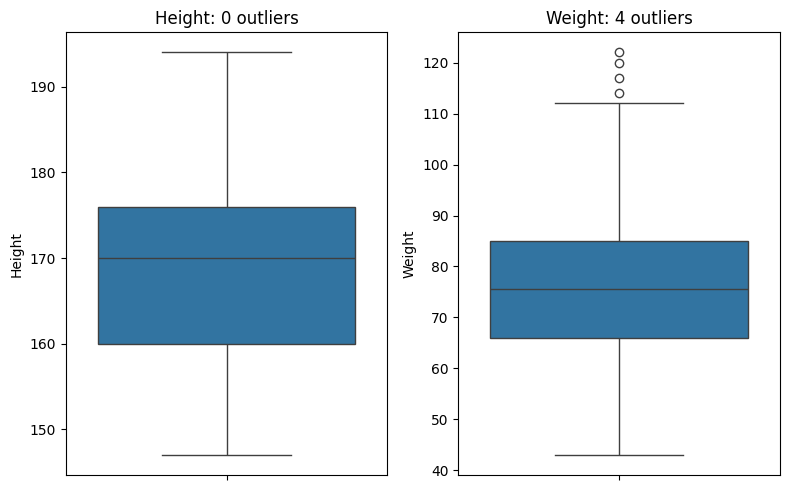

In [ ]:
def analyze_outliers(df, columns):    
    # Single figure with subplots
    fig, axes = plt.subplots(1, len(columns), figsize=(4*len(columns), 5))
    if len(columns) == 1:
        axes = [axes]
        
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(f"{col}: {len(outliers)} outliers")
        
        # Print outlier details if any
        print(f"\n{col} outliers ({len(outliers)} found):")
        if len(outliers) > 0:
            print(outliers[col].to_string())
        
    plt.tight_layout()
    plt.show()


analyze_outliers(data, ['Height', 'Weight'])

As we don't have outliers in height, we will use the mean to calculate the missing values. On the contrary, as we have outliers in weight, we will use the median.

In [ ]:
mean_height = data['Height'].mean()
median_weight= data['Weight'].median()
print('Mean height', mean_height)
print('Median weight', median_weight)

Mean height 169.21019108280254
Median weight 75.5


In [ ]:
def fill_missing(df, column, value):
    missing_before = df[column].isna().sum()
    
    if missing_before == 0:
        print(f"No missing values in column '{column}' to fill")
        return df
        
    # Fill missing values
    df[column] = df[column].fillna(value)
    missing_after = df[column].isna().sum()
    filled_count = missing_before - missing_after
    
    print(f"Filled {filled_count} missing values in '{column}' with {value}")
    return df

data = fill_missing(data, 'Height', mean_height)
data = fill_missing(data, 'Weight', median_weight)


Filled 33 missing values in 'Height' with 169.21019108280254
Filled 34 missing values in 'Weight' with 75.5


### 2.3. Computing BMI for missing values

We see that there's a column for the Body Mass Index (BMI), which has some rows for which the values are NaN, but have the height and weight needed to calculate the BMI. We can calculate the BMI for these rows:

In [ ]:
def compute_bmi(row):
    height = row['Height']
    weight = row['Weight']
    bmi = row['BMI']
    
    if (
        not pd.isna(height) and
        not pd.isna(weight) and
        pd.isna(bmi)
    ):
        height_m = height / 100  # Convert cm to m
        bmi = weight / (height_m ** 2)
        return round(bmi, 1)
    else:
        return bmi

def fill_missing_bmi_values(df):
    initial_missing = df['BMI'].isna().sum()

    df['BMI'] = df.apply(compute_bmi, axis=1)
    
    remaining_missing = df['BMI'].isna().sum()
    filled_count = initial_missing - remaining_missing
    
    print(f"BMI calculation statistics:")
    print(f"- {filled_count} missing BMI values were calculated")
    print(f"- {remaining_missing} BMI values remain missing")
    return df

data = fill_missing_bmi_values(data)
display(data)

BMI calculation statistics:
- 89 missing BMI values were calculated
- 0 BMI values remain missing


Sex  HTA   Age PVC_transition      SOO_chamber      Height  Weight  \
P186  1.0  NaN  61.0             V1  Right ventricle  169.210191    75.5   
P245  1.0  0.0  52.0             V3             RVOT  169.000000    68.0   
P292  1.0  0.0  69.0             V3             LVOT  156.000000    70.0   
P205  1.0  0.0  66.0             V4  Right ventricle  176.000000    63.0   
P066  1.0  1.0  46.0             V3             RVOT  160.000000    79.0   
...   ...  ...   ...            ...              ...         ...     ...   
P018  0.0  1.0  61.0             V1  Right ventricle  188.000000    90.0   
P124  0.0  1.0  52.0             V3             LVOT  182.000000    83.0   
P171  0.0  0.0  77.0             V6  Right ventricle  169.210191    75.5   
P219  0.0  1.0  88.0             V1   Mitral annulus  166.000000    90.0   
P230  1.0  0.0  32.0             V1             LVOT  175.000000    73.0   

            BMI   DM  DLP  Smoker  COPD  Sleep_apnea  CLINICAL_SCORE  \
P186  26.400000  NaN  NaN     NaN   NaN          NaN             NaN   
P245  23.800000  0.0  0.0     0.0   0.0          0.0             1.0   
P292  28.800000  0.0  1.0     0.0   0.0          0.0             1.0   
P205  20.338326  0.0  0.0     0.0   0.0          0.0             1.0   
P066  30.859375  0.0  0.0     0.0   0.0          0.0             1.0   
...         ...  ...  ...     ...   ...          ...             ...   
P018  25.464011  0.0  0.0     0.0   0.0          0.0             3.0   
P124  25.057360  0.0  0.0     0.0   0.0          0.0             3.0   
P171  26.400000  0.0  0.0     0.0   0.0          0.0             2.0   
P219  32.700000  1.0  1.0     0.0   0.0          0.0             3.0   
P230  23.800000  0.0  0.0     0.0   0.0          0.0             0.0   

                              SOO  OTorigin  
P186           Unión mitroaórtica       0.0  
P245         Pared libre anterior       1.0  
P292                          RCC       1.0  
P205     M. papilar posteromedial       0.0  
P066                  RVOT septal       1.0  
...                           ...       ...  
P018                    LV summit       0.0  
P124       Seno de Valsalva dcho.       1.0  
P171               LV inferobasal       0.0  
P219  Anillo mitral anterolateral       0.0  
P230           Left coronary cusp       1.0  

[190 rows x 16 columns]

In [ ]:
def check_missing_values(df, columns):
    if isinstance(columns, str):
        columns = [columns]
    
    for column in columns:
        missing_count = df[column].isna().sum()
        total_count = len(df)
        percent_missing = (missing_count / total_count) * 100
        
        print(f"- {column}: {missing_count} missing values ({percent_missing:.1f}%)")
    
    return

check_missing_values(data, ['Height', 'Weight', 'BMI'])

- Height: 0 missing values (0.0%)
- Weight: 0 missing values (0.0%)
- BMI: 0 missing values (0.0%)


### 2.4. Mapping outcomes from excel sheets

Now we'll focus on clearly determining what will be the target variable (labels) for both Model B and Model C, representing the SOO and sub-regions classification tasks respectively.

For Part 1 we will focus on the SOO classification, which is a binary classification task between LVOT and RVOT. We start inspecting the columns that might be related to the outcome, from the demographic data on the loaded `.pkl` file:

In [ ]:
print(data['SOO_chamber'].value_counts())

SOO_chamber
RVOT                 76
Right ventricle      57
LVOT                 36
Coronary sinus        8
Tricuspid annulus     6
Mitral annulus        4
Left ventricle        3
Name: count, dtype: int64


As we can see, this data file has a problem: the values on the 'SOO_chamber' column are more in detail than we need. We have different values that we want to merge into just two: 'LVOT' and 'RVOT'.

On the other hand, regarding the 'SOO_region' column:

In [ ]:
print(data['SOO'].value_counts())

SOO
RVOT anteroseptal                              13
LV summit                                       9
Intersenos dcho.-izdo.                          9
RVOT posterolateral                             9
Unión mitroaórtica                              8
                                               ..
VI inferoseptal basal                           1
rvot septo posterior                            1
Septo basal subaótico                           1
Seno coronario, ramo IV anterior (foco epi)     1
Left coronary cusp                              1
Name: count, Length: 93, dtype: int64


Here the problem is even worse, as we have 93 different values that we want to merge into just valid sub-regions of the LVOT and RVOT, that we later will filter out to just the ones that we want to use for Model C: 'RCC' and 'COMMISSURE'.

Fortunately, we have different `.xlsx` files that contain mappings of these values to the outcome labels we want to use. But we need to understand which columns do these sheets contain, and which sheet we will use for each of the two target variables.

In [ ]:
labels_sheet1 = pd.read_excel(os.path.join(extract_dir, 'labels_FontiersUnsupervised.xlsx'))
labels_sheet1 = pd.DataFrame(labels_sheet1)
labels_sheet1.dropna(inplace=True)
display(labels_sheet1)

SOO SOO_Chamber  \
0    LVOT cúspide derecha (cerca de la comisura)        LVOT   
1               RVOT supravalvular anterolateral        RVOT   
2                                  RVOT anterior        RVOT   
3                             RVOT posteroseptal        RVOT   
4          LVOT intersenos de Valsalva dcho-izdo        LVOT   
..                                           ...         ...   
114                   Postero Septal Subvalvular        RVOT   
115                                          RCC        LVOT   
116                                         RVOT        RVOT   
117                                       Summit        LVOT   
118                                          LCC        LVOT   

         Automatic_SOO Region_Simplified  
0                  RCC               RCC  
1        RVOT Anterior      RVOTFREEWALL  
2        RVOT Anterior      RVOTFREEWALL  
3    RVOT LateroSeptal        RVOTSEPTUM  
4           Intersinus        COMMISSURE  
..                 ...               ...  
114        RVOT Septal        RVOTSEPTUM  
115                RCC               RCC  
116       RVOT Lateral      RVOTFREEWALL  
117        LVOT Summit            SUMMIT  
118                LCC               LCC  

[118 rows x 4 columns]

We can see how these two columns in the `.xlxs` have exactly the values that we want to use as labels/outcomes:

In [ ]:
print("Distinct values in SOO_Chamber column:")
print(labels_sheet1['SOO_Chamber'].unique())
print("\nDistinct values in Region_Simplified column:")
print(labels_sheet1['Region_Simplified'].unique())

Distinct values in SOO_Chamber column:
['LVOT' 'RVOT']

Distinct values in Region_Simplified column:
['RCC' 'RVOTFREEWALL' 'RVOTSEPTUM' 'COMMISSURE' 'LVOTSUBVALVULAR' 'LCC'
 'SUMMIT']


Still, we have a second excel sheet, that we have moved to a separate `.xlxs` file:

In [ ]:
labels_sheet2 = pd.read_excel(os.path.join(extract_dir, 'label2.xlsx'))
labels_sheet2 = pd.DataFrame(labels_sheet2)
labels_sheet2.dropna(inplace=True) 
display(labels_sheet2)

OTorigin        SOO_chamber                                          SOO  \
0         1.0               RVOT                           RVOT lateral medio   
2         1.0               RVOT                RVOT anteroseptal subvalvular   
3         1.0               LVOT  LVOT cúspide derecha (cerca de la comisura)   
4         0.0  Tricuspid annulus                   Anillo tricuspídeo lateral   
6         0.0    Right ventricle                               VI laterobasal   
..        ...                ...                                          ...   
290       1.0               LVOT                                   Intersinus   
291       1.0               LVOT                                          RCC   
292       1.0               RVOT                                         RVOT   
293       1.0               LVOT                                       Summit   
294       1.0               LVOT                                          LCC   

          Simplified  
0       RVOTFREEWALL  
2         RVOTSEPTUM  
3                RCC  
4         RVOTSEPTUM  
6    LVOTSUBVALVULAR  
..               ...  
290        COMMISURE  
291              RCC  
292     RVOTFREEWALL  
293       LVOTSUMMIT  
294              LCC  

[266 rows x 4 columns]

In [ ]:
print("Distinct values in SOO_chamber column:")
print(labels_sheet2['SOO_chamber'].unique())
print("\nDistinct values in Simplified column:")
print(labels_sheet2['Simplified'].unique())

Distinct values in SOO_chamber column:
['RVOT' 'LVOT' 'Tricuspid annulus' 'Right ventricle' 'Mitral annulus'
 'Coronary sinus' 'Left ventricle']

Distinct values in Simplified column:
['RVOTFREEWALL' 'RVOTSEPTUM' 'RCC' 'LVOTSUBVALVULAR' 'COMMISURE'
 'LVOTSUMMIT' 'LCC']


How does the information on these two files relate? 

We can clearly see that **sheet 1' 'SOO_Chamber' column is the right one for the SOO classification task**; since sheet 2's 'SOO_chamber' column contains more than just RVOT and LVOT.

In [ ]:
subregions_sheet1 = set(labels_sheet1['Region_Simplified'].unique())
subregions_sheet2 = set(labels_sheet2['Simplified'].unique())
print(f"Subregions in sheet 1: {subregions_sheet1}")
print(f"Subregions in sheet 2: {subregions_sheet2}")

Subregions in sheet 1: {'LCC', 'RVOTSEPTUM', 'COMMISSURE', 'LVOTSUBVALVULAR', 'RVOTFREEWALL', 'RCC', 'SUMMIT'}
Subregions in sheet 2: {'LCC', 'COMMISURE', 'RVOTSEPTUM', 'LVOTSUBVALVULAR', 'RVOTFREEWALL', 'LVOTSUMMIT', 'RCC'}


On the other hand, we see that both sheets have a column that relates to the simplified sub-regions that we want to use for Model C, both containing exactly 7 unique different values, and these being the same except for 'SUMMIT' in sheet 1, which should match with 'LVOTSUMMIT' in sheet 2.

To determine which of the two sheets we will use as the source mapping for the sub-regions task, we'll check how many different values map to these 7 unique values in each of the two sheets:

In [ ]:
rcc_count1 = (labels_sheet1['Region_Simplified'] == 'RCC').sum()
commissure_count1 = (labels_sheet1['Region_Simplified'] == 'COMMISSURE').sum()

rcc_count2 = (labels_sheet2['Simplified'] == 'RCC').sum()
commissure_count2 = (labels_sheet2['Simplified'] == 'COMMISURE').sum()

print("Sheet 1 mappings:")
print(f"- RCC: {rcc_count1} different values")
print(f"- COMMISSURE: {commissure_count1} different values")

print("\nSheet 2 mappings:")
print(f"- RCC: {rcc_count2} different values") 
print(f"- COMMISURE: {commissure_count2} different values")

total_mappings1 = len(labels_sheet1)
total_mappings2 = len(labels_sheet2)
print(f"\nTotal mappings in sheet 1: {total_mappings1}")
print(f"Total mappings in sheet 2: {total_mappings2}")

Sheet 1 mappings:
- RCC: 7 different values
- COMMISSURE: 12 different values

Sheet 2 mappings:
- RCC: 11 different values
- COMMISURE: 19 different values

Total mappings in sheet 1: 118
Total mappings in sheet 2: 266


From this data, we have decided that the **source of the sub-regions mapping will be sheet 2.**

We'll start matching data's 'SOO_chamber' column to the 'SOO' column in the `.xlxs` file, to create two columns in the dataframe, 'Outcome_B' and 'Outcome_C', containing the sheet's 'SOO_Chamber' and 'Region_Simplified' values respectively:

In [ ]:
def standardize_outcome_b(df, sheet1, source_col, target_col):
    print("Starting standardization for Outcome_B using sheet1:")
    
    b_mapping = dict(zip(sheet1[target_col], sheet1['SOO_Chamber']))
    df['Outcome_B'] = df[source_col].map(b_mapping)
    
    # Handle unmapped values from first mapping pass
    unmapped_b = df['Outcome_B'].isna()
    unmapped_b_count = unmapped_b.sum()
    
    print(f"- {df['Outcome_B'].notna().sum()} values mapped ({df['Outcome_B'].notna().sum()/len(df)*100:.1f}%)")
    print(f"- {unmapped_b_count} values remain unmapped")
    
    if unmapped_b_count > 0:
        print(f"\nRemaining unmapped SOO values for Outcome_B ({unmapped_b_count}):")
        unmapped_soos = df.loc[df['Outcome_B'].isna(), 'SOO'].value_counts()
        for soo, count in unmapped_soos.items():
            print(f"  '{soo}': {count} occurrences")
    
    return df


data = standardize_outcome_b(data, labels_sheet1, 'SOO', 'SOO')

Starting standardization for Outcome_B using sheet1:
- 130 values mapped (68.4%)
- 60 values remain unmapped

Remaining unmapped SOO values for Outcome_B (60):
  'Unión mitroaórtica': 8 occurrences
  'Ostium del SC (crux cordis)': 3 occurrences
  'Fascicular posterior': 2 occurrences
  'Fascicular anterior': 2 occurrences
  'Intersinus': 1 occurrences
  'subvalvular aortico (summit)': 1 occurrences
  'Intersenos (LV)': 1 occurrences
  'rvot - pared libre': 1 occurrences
  'Septal posterior y anterior': 1 occurrences
  'LV inferoseptal medio': 1 occurrences
  'rvot sèeto posterior': 1 occurrences
  'fasciculo anterior LV': 1 occurrences
  'anillo lat': 1 occurrences
  'Fascículo anterior': 1 occurrences
  'Papilar anterolateral': 1 occurrences
  'Pared anterior-anteroseptal media (IAM)': 1 occurrences
  'rvot septal anterior': 1 occurrences
  'LV anteroseptal (foco intramiocárdico)': 1 occurrences
  'Musculo papilar infero-medial': 1 occurrences
  'Septo posterior, immediatamente subval

In [ ]:
def standardize_outcome_c(df, sheet2, source_col, target_col):
    print("Starting standardization for Outcome_C using sheet2:")
    
    c_mapping = dict(zip(sheet2[target_col], sheet2['Simplified']))
    df['Outcome_C'] = df[source_col].map(c_mapping)
    
    unmapped_c = df['Outcome_C'].isna()
    unmapped_c_count = unmapped_c.sum()
    
    print(f"- {df['Outcome_C'].notna().sum()} values mapped ({df['Outcome_C'].notna().sum()/len(df)*100:.1f}%)")
    print(f"- {unmapped_c_count} values remain unmapped")
    
    if unmapped_c_count > 0:
        print(f"\nRemaining unmapped SOO values for Outcome_C ({unmapped_c_count}):")
        unmapped_soos = df.loc[df['Outcome_C'].isna(), 'SOO'].value_counts()
        for soo, count in unmapped_soos.items():
            print(f"  '{soo}': {count} occurrences")
    
    return df


data = standardize_outcome_c(data, labels_sheet2, 'SOO', 'SOO')

Starting standardization for Outcome_C using sheet2:
- 187 values mapped (98.4%)
- 3 values remain unmapped

Remaining unmapped SOO values for Outcome_C (3):
  'Ostium de SC': 1 occurrences
  'rvot sèeto posterior': 1 occurrences


In [ ]:
display(data[['SOO', 'SOO_chamber', 'Outcome_B', 'Outcome_C']])

SOO      SOO_chamber Outcome_B        Outcome_C
P186           Unión mitroaórtica  Right ventricle       NaN  LVOTSUBVALVULAR
P245         Pared libre anterior             RVOT      RVOT     RVOTFREEWALL
P292                          RCC             LVOT      LVOT              RCC
P205     M. papilar posteromedial  Right ventricle      RVOT     RVOTFREEWALL
P066                  RVOT septal             RVOT      RVOT       RVOTSEPTUM
...                           ...              ...       ...              ...
P018                    LV summit  Right ventricle      RVOT       LVOTSUMMIT
P124       Seno de Valsalva dcho.             LVOT      LVOT              RCC
P171               LV inferobasal  Right ventricle       NaN  LVOTSUBVALVULAR
P219  Anillo mitral anterolateral   Mitral annulus      LVOT  LVOTSUBVALVULAR
P230           Left coronary cusp             LVOT      LVOT              LCC

[190 rows x 4 columns]

### 2.5. Handling remaining missing outcomes

After this first mapping, let's see how many missing outcomes we have for both Model B and Model C:

In [ ]:
def analyze_outcomes(df):
    print("=== Outcome_B (LVOT/RVOT) Distribution ===")
    total = len(df)
    
    missing_b = df['Outcome_B'].isna().sum()
    missing_percent_b = (missing_b / total) * 100
    
    # Get distribution of non-null values
    if missing_b < total:
        valid_b = df['Outcome_B'].dropna()
        value_counts_b = valid_b.value_counts()
        
        print("Class distribution among mapped values:")
        for value, count in value_counts_b.items():
            percent = (count / valid_b.shape[0]) * 100
            print(f"- {value}: {count} ({percent:.1f}%)")
    print(f"Missing values: {missing_b} ({missing_percent_b:.1f}%)")
    
    print("\n=== Outcome_C (Specific Sub-regions) Distribution ===")
    missing_c = df['Outcome_C'].isna().sum()
    missing_percent_c = (missing_c / total) * 100
    
    if missing_c < total:
        valid_c = df['Outcome_C'].dropna()
        
        # Count overall distribution
        value_counts_c = valid_c.value_counts()
        
        print("Class distribution among mapped values:")
        for value, count in value_counts_c.items():
            percent = (count / valid_c.shape[0]) * 100
            print(f"- {value}: {count} ({percent:.1f}%)")
    print(f"Missing values: {missing_c} ({missing_percent_c:.1f}%)")
        
    print("\n=== Summary ===")
    print(f"Total records: {total}")
    print(f"Usable for Model B (SOO classification): {total - missing_b} ({(total - missing_b) / total * 100:.1f}%)")
    print(f"Usable for Model C (Sub-region classification): {total - missing_c} ({(total - missing_c) / total * 100:.1f}%)")

analyze_outcomes(data)

=== Outcome_B (LVOT/RVOT) Distribution ===
Class distribution among mapped values:
- RVOT: 93 (71.5%)
- LVOT: 37 (28.5%)
Missing values: 60 (31.6%)

=== Outcome_C (Specific Sub-regions) Distribution ===
Class distribution among mapped values:
- RVOTSEPTUM: 59 (31.6%)
- RVOTFREEWALL: 48 (25.7%)
- LVOTSUBVALVULAR: 25 (13.4%)
- LVOTSUMMIT: 21 (11.2%)
- COMMISURE: 13 (7.0%)
- LCC: 12 (6.4%)
- RCC: 9 (4.8%)
Missing values: 3 (1.6%)

=== Summary ===
Total records: 190
Usable for Model B (SOO classification): 130 (68.4%)
Usable for Model C (Sub-region classification): 187 (98.4%)


We see that after these two mappings and matchins, we still have some missing values in both 'Outcome_B' and 'Outcome_C'. This may be easily solvable by looking at the other column in the dataframe (the one that we haven't used to map the outcomes for each of the outcomes), and checking if we can find a match there.

In [ ]:
# Pick the SOO and SOO_chamber for all rows that do not have Outcome_B in a list
def get_unmapped_soos(df):
    unmapped = df[df['Outcome_B'].isna()][['SOO', 'SOO_chamber']]
    return unmapped
unmapped_soos = get_unmapped_soos(data)
print(f"Unmapped Outcome B count: {len(unmapped_soos)}")
print(unmapped_soos.to_string(index=False))
del unmapped_soos # To free up memory, it was only used for printing

Unmapped Outcome B count: 60
                                              SOO       SOO_chamber
                               Unión mitroaórtica   Right ventricle
                              Fascicular anterior   Right ventricle
                               Inferoseptal basal   Right ventricle
                            Septo basal izquierdo   Right ventricle
                      Ostium del SC (crux cordis)    Coronary sinus
                             Fascicular posterior   Right ventricle
                               CS distal (summit)    Coronary sinus
                               LV summit EPI (SC)    Coronary sinus
                               Unión mitroaórtica   Right ventricle
                                 Banda moderadora              RVOT
                                              NaN              RVOT
                               Unión mitroaórtica   Right ventricle
                               LVOT anterolateral              LVOT
                   

For all the unmapped "Right ventricle", we can see in sheet2 that some map to 'RVOT' sub-regions (like 'RVOTSEPTUM', 'RVOTFREEWALL') and some to 'LVOT' sub-regions (like 'LVOTSEPTUM', 'LVOTSUBVALVULAR'). Yes, contrary to common sense, 'Right ventricle' can map to both LVOT and RVOT sub-regions, and thus might have different labels on Outcome_B.

We can't use the 'SOO_chamber' column to map these, as it would be ambiguous (we would have to map some to 'RVOT' and some to 'LVOT'); so we will instead use the 'SOO' value:

In [ ]:
def standardize_right_ventricle_outcome_b(df, sheet2):
    print("Mapping 'Right ventricle' cases using sheet2 subregion information:")
    
    initial_unmapped = df['Outcome_B'].isna().sum()
    right_ventricle_mask = (df['Outcome_B'].isna()) & (df['SOO_chamber'] == 'Right ventricle')
    right_ventricle_count = right_ventricle_mask.sum()
    
    # Create mapping dictionary from sheet2 for Right ventricle cases
    # Map each SOO to LVOT or RVOT based on whether its subregion starts with "LVOT" or "RVOT"
    subregion_mapping = {}
    for _, row in sheet2.iterrows():
        soo = row['SOO']
        subregion = row['Simplified']
        
        if isinstance(subregion, str):
            if subregion.startswith('RVOT'):
                subregion_mapping[soo] = 'RVOT'
            elif subregion.startswith('LVOT'):
                subregion_mapping[soo] = 'LVOT'
            
    # Apply mapping only to Right ventricle rows with null Outcome_B
    mapped_count = 0
    for soo, outcome in subregion_mapping.items():
        mapped = ((df['Outcome_B'].isna()) & 
                  (df['SOO_chamber'] == 'Right ventricle') & 
                  (df['SOO'] == soo))
        
        if mapped.sum() > 0:
            df.loc[mapped, 'Outcome_B'] = outcome
            mapped_count += mapped.sum()
    
    remaining_unmapped = df['Outcome_B'].isna().sum()
    
    print(f"- Found {right_ventricle_count} 'Right ventricle' cases with unmapped Outcome_B")
    print(f"- Successfully mapped {mapped_count} cases based on their SOO and subregion")
    
    # List any remaining unmapped Right ventricle cases
    still_unmapped = (df['Outcome_B'].isna()) & (df['SOO_chamber'] == 'Right ventricle')
    if still_unmapped.sum() > 0:
        print("\nRemaining unmapped 'Right ventricle' cases:")
        unmapped_soos = df.loc[still_unmapped, 'SOO'].value_counts()
        for soo, count in unmapped_soos.items():
            print(f"  '{soo}': {count} occurrences - not found in sheet2 mapping")
    
    return df


data = standardize_right_ventricle_outcome_b(data, labels_sheet2)

Mapping 'Right ventricle' cases using sheet2 subregion information:
- Found 35 'Right ventricle' cases with unmapped Outcome_B
- Successfully mapped 33 cases based on their SOO and subregion

Remaining unmapped 'Right ventricle' cases:
  'Left coronary cusp, desde el ventriculo izquierdo': 1 occurrences - not found in sheet2 mapping
  'Intersenos (LV)': 1 occurrences - not found in sheet2 mapping


We deal now with the remaining missing values in 'Outcome_B' and 'Outcome_C' by checking both the 'SOO' and 'SOO_chamber' columns, inspecting to which sub-region they map on sheet2, and determining for this sub-region which of the two outcomes we should assign (as noted in the comments for each):

In [ ]:
def map_missing_outcome_b(df):
    chamber_to_outcome = {
        "RVOT": "RVOT",
        "LVOT": "LVOT",
        "Left ventricle": "LVOT", # From sheet2, all occurrences correspond to a subregion of "LVOT" ("LCC" or "LVOTSUMMIT")
        "Coronary sinus": "LVOT",  # From sheet2 we can see that it corresponds to subregion "LVOTSUMMIT"
        "Mitral annulus": "LVOT",  # From sheet2 we can see that it corresponds to subregion "LVOTSUBVALVULAR"
        "Tricuspid annulus": "RVOT"  # From sheet2 we can see that it corresponds to subregion "RVOTSEPTUM"
    }
    
    soo_to_outcome = {
        "Left coronary cusp, desde el ventriculo izquierdo": "LVOT", # From sheet2, it corresponds to subregion "LCC"
        "Intersenos (LV)": "LVOT"  # From sheet2, this corresponds to subregion "COMMISSURE"
    }
    
    mask = df['Outcome_B'].isna()
    initial_missing = mask.sum()
    
    # Apply SOO_chamber mapping
    chamber_mask = df['Outcome_B'].isna()
    to_fill_chamber = df.loc[chamber_mask, 'SOO_chamber'].isin(chamber_to_outcome.keys()).sum()
    
    for chamber, outcome in chamber_to_outcome.items():
        df.loc[(df['Outcome_B'].isna()) & (df['SOO_chamber'] == chamber), 'Outcome_B'] = outcome
        
    # Apply SOO mapping
    soo_mask = df['Outcome_B'].isna()
    to_fill_soo = df.loc[soo_mask, 'SOO'].isin(soo_to_outcome.keys()).sum()
    
    for soo, outcome in soo_to_outcome.items():
        df.loc[(df['Outcome_B'].isna()) & (df['SOO'] == soo), 'Outcome_B'] = outcome
    
    remaining_null = df['Outcome_B'].isna().sum()
    filled_count = initial_missing - remaining_null
    
    print(f"Filled {filled_count} missing Outcome_B values:")
    print(f"- {to_fill_chamber} from SOO_chamber mapping")
    print(f"- {to_fill_soo} from SOO mapping")
    print(f"Remaining null Outcome_B values: {remaining_null}")
    return df

data = map_missing_outcome_b(data)

Filled 27 missing Outcome_B values:
- 25 from SOO_chamber mapping
- 2 from SOO mapping
Remaining null Outcome_B values: 0


In [ ]:
# Pick the SOO and SOO_chamber for all rows that do not have Outcome_C in a list
def get_unmapped_subregions(df):
    unmapped = df[df['Outcome_C'].isna()][['SOO', 'SOO_chamber']]
    return unmapped
unmapped_subregions = get_unmapped_subregions(data)
print(f"\nUnmapped Outcome C count: {len(unmapped_subregions)}")
print(unmapped_subregions.to_string(index=False))
del unmapped_subregions  # To free up memory, it was only used for printing


Unmapped Outcome C count: 3
                 SOO    SOO_chamber
                 NaN           RVOT
        Ostium de SC Coronary sinus
rvot sèeto posterior           RVOT


In [ ]:
def map_missing_outcome_c(df):
    chamber_to_outcome_from_soo_chamber = {
        "Coronary sinus": "LVOTSUMMIT"  # From sheet2 we can see that it corresponds to subregion "LVOTSUMMIT"
    }
    
    chamber_to_outcome_from_soo = {
        "rvot sèeto posterior": "RVOTSEPTUM"  # From sheet2 we can see that it corresponds to subregion "RVOTSEPTUM" 
    }
    
    initial_missing = df['Outcome_C'].isna().sum()
    
    chamber_mapping_count = sum((df['Outcome_C'].isna()) & 
                              (df['SOO_chamber'].isin(chamber_to_outcome_from_soo_chamber.keys())))
    
    for chamber, outcome in chamber_to_outcome_from_soo_chamber.items():
        df.loc[(df['Outcome_C'].isna()) & (df['SOO_chamber'] == chamber), 'Outcome_C'] = outcome
    
    soo_mapping_count = sum((df['Outcome_C'].isna()) & 
                           (df['SOO'].isin(chamber_to_outcome_from_soo.keys())))

    for soo, outcome in chamber_to_outcome_from_soo.items():
        df.loc[(df['Outcome_C'].isna()) & (df['SOO'] == soo), 'Outcome_C'] = outcome
    
    remaining_missing = df['Outcome_C'].isna().sum()
    filled_count = initial_missing - remaining_missing
    
    print(f"Filled {filled_count} missing Outcome_C values:")
    print(f"- {chamber_mapping_count} from SOO_chamber mapping")
    print(f"- {soo_mapping_count} from SOO mapping")
    print(f"Remaining null Outcome_C values: {remaining_missing}")
    return df
    

data = map_missing_outcome_c(data)

Filled 2 missing Outcome_C values:
- 1 from SOO_chamber mapping
- 1 from SOO mapping
Remaining null Outcome_C values: 1


We can see that we still have 1 patient with a missing value in 'Outcome_C'. We know that this patient has a 'SOO_chamber' value of 'RVOT', and since our classification task for Model C is to classify the sub-regions of the LVOT, we can leave it with a NaN value, since we will filter it anyway before training Model C, and this outcome column is not needed neither for Model B.

In [ ]:
analyze_outcomes(data)

=== Outcome_B (LVOT/RVOT) Distribution ===
Class distribution among mapped values:
- RVOT: 118 (62.1%)
- LVOT: 72 (37.9%)
Missing values: 0 (0.0%)

=== Outcome_C (Specific Sub-regions) Distribution ===
Class distribution among mapped values:
- RVOTSEPTUM: 60 (31.7%)
- RVOTFREEWALL: 48 (25.4%)
- LVOTSUBVALVULAR: 25 (13.2%)
- LVOTSUMMIT: 22 (11.6%)
- COMMISURE: 13 (6.9%)
- LCC: 12 (6.3%)
- RCC: 9 (4.8%)
Missing values: 1 (0.5%)

=== Summary ===
Total records: 190
Usable for Model B (SOO classification): 190 (100.0%)
Usable for Model C (Sub-region classification): 189 (99.5%)


Up until here we have basic demographic data preprocessing (for height, weight, BMI) and the creation of the two outcome columns for Model B and Model C, which we will use later to train the classification models. As the last step, we can remove the 'SOO_chamber' and 'SOO' columns, as we don't need them anymore because they have been replaced by the 'Outcome_B' and 'Outcome_C' columns:

In [ ]:
def clean_up_soo_columns(df):
    columns_to_remove = ['SOO', 'SOO_chamber']
    
    original_cols = df.shape[1]
    existing_columns = [col for col in columns_to_remove if col in df.columns]
    
    df = df.drop(columns=existing_columns)
    new_cols = df.shape[1]
    
    print(f"Removed {len(existing_columns)} columns: {', '.join(existing_columns)}")
    return df

data = clean_up_soo_columns(data)

Removed 2 columns: SOO, SOO_chamber


We will now focus onto cleaning and preparing all the other demographic data columns.

### 2.6. Assessing rest of demographic data columns

We start by displaying the rest of the demographic data columns, to see how many of them are categorical and how many are numerical, and what kind of values they contain:

In [ ]:
def display_cleaned_data(df):
    excluded_columns = ['Height', 'Weight', 'BMI', 'Outcome_B', 'Outcome_C']
    
    remaining_columns = [col for col in df.columns if col not in excluded_columns]
    
    cleaned_df = df[remaining_columns]
    print(f"Displaying dataframe with {len(remaining_columns)} columns (excluding processed columns)")
    display(cleaned_df)
    
    return cleaned_df

remaining_data = display_cleaned_data(data)

Displaying dataframe with 11 columns (excluding processed columns)


Sex  HTA   Age PVC_transition   DM  DLP  Smoker  COPD  Sleep_apnea  \
P186  1.0  NaN  61.0             V1  NaN  NaN     NaN   NaN          NaN   
P245  1.0  0.0  52.0             V3  0.0  0.0     0.0   0.0          0.0   
P292  1.0  0.0  69.0             V3  0.0  1.0     0.0   0.0          0.0   
P205  1.0  0.0  66.0             V4  0.0  0.0     0.0   0.0          0.0   
P066  1.0  1.0  46.0             V3  0.0  0.0     0.0   0.0          0.0   
...   ...  ...   ...            ...  ...  ...     ...   ...          ...   
P018  0.0  1.0  61.0             V1  0.0  0.0     0.0   0.0          0.0   
P124  0.0  1.0  52.0             V3  0.0  0.0     0.0   0.0          0.0   
P171  0.0  0.0  77.0             V6  0.0  0.0     0.0   0.0          0.0   
P219  0.0  1.0  88.0             V1  1.0  1.0     0.0   0.0          0.0   
P230  1.0  0.0  32.0             V1  0.0  0.0     0.0   0.0          0.0   

      CLINICAL_SCORE  OTorigin  
P186             NaN       0.0  
P245             1.0       1.0  
P292             1.0       1.0  
P205             1.0       0.0  
P066             1.0       1.0  
...              ...       ...  
P018             3.0       0.0  
P124             3.0       1.0  
P171             2.0       0.0  
P219             3.0       0.0  
P230             0.0       1.0  

[190 rows x 11 columns]

In [ ]:
pending_columns = remaining_data.columns
print(pending_columns.to_list())
del remaining_data # To free up memory, this was a one-time df to get information

['Sex', 'HTA', 'Age', 'PVC_transition', 'DM', 'DLP', 'Smoker', 'COPD', 'Sleep_apnea', 'CLINICAL_SCORE', 'OTorigin']


In [ ]:
check_missing_values(data, pending_columns)

- Sex: 3 missing values (1.6%)
- HTA: 7 missing values (3.7%)
- Age: 4 missing values (2.1%)
- PVC_transition: 10 missing values (5.3%)
- DM: 8 missing values (4.2%)
- DLP: 7 missing values (3.7%)
- Smoker: 9 missing values (4.7%)
- COPD: 8 missing values (4.2%)
- Sleep_apnea: 9 missing values (4.7%)
- CLINICAL_SCORE: 8 missing values (4.2%)
- OTorigin: 1 missing values (0.5%)


We'll go through these columns one by one, to assess how relevant they might be, to see how we can preprocess them to be used in the classification models, and how we deal with missing values. We have already properly binarized columns, and the only pending processing is to encode the categorical columns that we want to preserve (as well as dealing with missing values of all these columns).

Some functions that will be useful for deciding how to preprocess the columns:

In [ ]:
def check_missing_column_values(df, column_name):
    # Find rows with missing values in the specified column
    missing_data = df[df[column_name].isna()]
    
    if len(missing_data) == 0:
        print(f"No missing values found in '{column_name}' column.")
        return
    
    print(f"Found {len(missing_data)} patients with missing '{column_name}' values:")
    
    result = missing_data[['Outcome_B', 'Outcome_C']]
    display(result)

In [ ]:
def drop_rows_with_missing_values(df, column_name):
    initial_rows = len(df)
    missing_mask = df[column_name].isna()
    missing_count = missing_mask.sum()
    df = df.dropna(subset=[column_name])
    
    print(f"Dropped {missing_count} rows with missing '{column_name}' values")
    print(f"Dataframe reduced from {initial_rows} to {len(df)} rows")
    return df

In [ ]:
def one_hot_encode_column(df, column_name):
    unique_values = sorted(df[column_name].unique())
    
    print(f"One-hot encoding '{column_name}' with {len(unique_values)} unique values")
    for value in unique_values:
        new_col_name = f"{column_name}_{value}"
        df[new_col_name] = (df[column_name] == value).astype(int)
        print(f"- Added column '{new_col_name}'")
    
    df = df.drop(columns=[column_name])
    print(f"- Removed original '{column_name}' column")
    return df

#### 2.6.1. 'Sex' column

We have 3 patients with missing values. This column is important for the model to learn, since some characteristics of ECGs might be explained by the gender of the patient. Inventing a value for this column would not be a good idea as it can lead to a bias in the model, yet we have to assess how significant are these patients for our classification tasks.


In [ ]:
check_missing_column_values(data, 'Sex')

Found 3 patients with missing 'Sex' values:


Outcome_B     Outcome_C
P173      RVOT  RVOTFREEWALL
P164      RVOT  RVOTFREEWALL
P295      LVOT           LCC

We can see that it would not be a big inconvenience to drop these patients:
- For Outcome_B, 2 of the 3 patients are RVOT, and 1 is LVOT. This is roughly close to the current distribution of these labels "RVOT: 139 (73.2%), LVOT: 51 (26.8%)". Dropping them won't significantly change the (still unbalanced) distribution of the labels.
- For Outcome_C, all three patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C.

So we can drop them:

In [ ]:
data = drop_rows_with_missing_values(data, 'Sex')

Dropped 3 rows with missing 'Sex' values
Dataframe reduced from 190 to 187 rows


#### 2.6.2. 'HTA' column

"HTA" refers to "Hypertension" or "Arterial Hypertension". We will proceed similar to before:

In [ ]:
check_missing_column_values(data, 'HTA')

Found 4 patients with missing 'HTA' values:


Outcome_B        Outcome_C
P186      LVOT  LVOTSUBVALVULAR
P268      RVOT       RVOTSEPTUM
P286      LVOT              LCC
P185      LVOT  LVOTSUBVALVULAR

Similar to before, we have 4 patients with missing values. This column is important for the model to learn, since some characteristics of ECGs might be explained by the presence of hypertension in the patient. We can see that dropping these patients won't significantly change the distribution of the labels:
- For Outcome_B, 2 of the 4 patients are RVOT, and 2 is LVOT. This won't dramatically alter the current distribution of these labels. 
- For Outcome_C, all four patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C: they can be dropped without affecting the input data in any way.
So we can drop them:

In [ ]:
data = drop_rows_with_missing_values(data, 'HTA')

Dropped 4 rows with missing 'HTA' values
Dataframe reduced from 187 to 183 rows


#### 2.6.3. 'Age' column

Numerical column, important for the model to learn, since some characteristics of ECGs will be probably explained by the age of the patient (common sense: risk factors, organ development and aging,...).

In [ ]:
check_missing_column_values(data, 'Age')

No missing values found in 'Age' column.


After the previous two removals, there is no patient with a missing value in the 'Age' column, so we can proceed to the next column.

#### 2.6.4. 'PVC_transition' column

This column is categorical, so we will need to encode it. It refers to the "Premature Ventricular Contraction transition zone" or "precordial transition" in the ECG. Its values:

In [ ]:
print("Distinct values in 'PVC_transition' column:")
print(data['PVC_transition'].unique())

Distinct values in 'PVC_transition' column:
['V3' 'V4' nan 'V2' 'V5' 'V1' 'V6']


The values V1, V2, V3, V4, V5, and V6 refer to chest leads on an electrocardiogram where the electrical transition occurs. This transition represents the location where the QRS complex changes from predominantly negative to predominantly positive. 

For outflow tract ventricular arrhythmias (OTVAs), the transition zone can be **extremely important** to help determine the site of origin of the arrhythmia: an early transition (V1-V2) often suggests left ventricular outflow tract (LVOT) origin, while a later transition (V4-V6) typically suggests right ventricular outflow tract (RVOT) origin. This was shown empirically in the provided [source paper](https://pubmed.ncbi.nlm.nih.gov/36795268/) that proposed a clinical scoring system for OTVAs primarily based on the precordial transition zone.

In [ ]:
check_missing_column_values(data, 'PVC_transition')

Found 8 patients with missing 'PVC_transition' values:


Outcome_B        Outcome_C
P172      LVOT  LVOTSUBVALVULAR
P294      LVOT       LVOTSUMMIT
P076      LVOT  LVOTSUBVALVULAR
P212      LVOT  LVOTSUBVALVULAR
P227      RVOT     RVOTFREEWALL
P082      LVOT       LVOTSUMMIT
P128      RVOT       RVOTSEPTUM
P281      LVOT              LCC

Now we have 8 patients with missing values. 8 patients out of the currently remaining 183 patients is less than 5%. Given that:
- For Outcome_B, 4 of the 8 patients are RVOT, and 4 is LVOT. This won't dramatically alter the current distribution of these labels.
- For Outcome_C, all eight patients have sub-regions that are neither RCC nor COMMISSURE, so they will be filtered out anyway before training Model C.

Again, since we will be using classical machine learning models (not deep learning, which usually requires more data), and we still have thousands of ECGs for the remaining patients, the best solution to keep data quality high is to drop these patients (to avoid determining a value for this column that might not be representative of the patient).

In [ ]:
data = drop_rows_with_missing_values(data, 'PVC_transition')

Dropped 8 rows with missing 'PVC_transition' values
Dataframe reduced from 183 to 175 rows


After this, we have to encode the categorical values of this column. We will use the one-hot encoding function we previously defined, which will create a new column for each of the values in the 'PVC_transition' column, and fill it with 1s and 0s depending on whether the patient has that value or not:

In [ ]:
data = one_hot_encode_column(data, 'PVC_transition')

One-hot encoding 'PVC_transition' with 6 unique values
- Added column 'PVC_transition_V1'
- Added column 'PVC_transition_V2'
- Added column 'PVC_transition_V3'
- Added column 'PVC_transition_V4'
- Added column 'PVC_transition_V5'
- Added column 'PVC_transition_V6'
- Removed original 'PVC_transition' column


#### 2.6.5. 'DM' column

"DM" stands for "Diabetes Mellitus". Diabetes is a standard feature to record because it's a significant risk factor that can affect cardiac conditions including arrhythmias. Having this information can be valuable for the models to identify potential relationships between diabetes status and the site of origin (SOO) of outflow tract ventricular arrhythmias, so we will keep it.

In [ ]:
check_missing_column_values(data, 'DM')

Found 1 patients with missing 'DM' values:


Outcome_B   Outcome_C
P290      LVOT  LVOTSUMMIT

There is just 1 patient with a missing value in this column. Its Outcome_C is not RCC or COMMISSURE, so it will be filtered out anyway before training Model C. For Outcome_B, this patient has a SOO of LVOT. Given that we have still 175 patients (and thousands of ECGs in total), we can drop this patient to avoid assuming that this patient hasn't got diabetes, which could bias in the model in the case that this patient actually has diabetes.

In [ ]:
data = drop_rows_with_missing_values(data, 'DM')

Dropped 1 rows with missing 'DM' values
Dataframe reduced from 175 to 174 rows


#### 2.6.6. 'DLP' column

"DLP" stands for "Dyslipidemia". Dyslipidemia is a condition characterized by abnormal levels of lipids in the blood, which can be a risk factor for cardiovascular diseases. Similar to diabetes, having this information can be valuable for the models.

In [ ]:
check_missing_column_values(data, 'DLP')

No missing values found in 'DLP' column.


#### 2.6.7. 'Smoker' column

Smoking is a well-known risk factor for various cardiovascular diseases, including arrhythmias. Including this information can help the models identify potential relationships between smoking status and the outcome that we want to predict.

In [ ]:
check_missing_column_values(data, 'Smoker')

Found 1 patients with missing 'Smoker' values:


Outcome_B Outcome_C
P285      LVOT       LCC

Again, just 1 patient with a missing value in this column. Its Outcome_C is not RCC or COMMISSURE, so it will be filtered out anyway before training Model C. For Outcome_B, this patient has a SOO of LVOT. We can drop this patient too.

In [ ]:
data = drop_rows_with_missing_values(data, 'Smoker')

Dropped 1 rows with missing 'Smoker' values
Dataframe reduced from 174 to 173 rows


#### 2.6.8. 'COPD' column

"COPD" stands for Chronic Obstructive Pulmonary Disease. It causes obstructed airflow from the lungs, making it difficult to breathe, and it appears as one of the binary medical conditions being tracked as a relevant risk factor (so we will keep this column too).

In [ ]:
check_missing_column_values(data, 'COPD')

No missing values found in 'COPD' column.


#### 2.6.9. 'Sleep_apnea' column

"Sleep apnea" is a sleep disorder characterized by repeated interruptions in breathing during sleep. It can lead to various cardiovascular issues, including arrhythmias. Again, a risk factor that we want to keep as a potentially relevant feature for the models.

In [ ]:
check_missing_column_values(data, 'Sleep_apnea')

No missing values found in 'Sleep_apnea' column.


#### 2.6.10. 'CLINICAL_SCORE' and 'OTorigin' column

The 'CLINICAL_SCORE' column is a numerical score that summarizes the clinical assessment of the arrhythmia's site of origin, and the 'OTorigin' column contains the site of origin of the arrhythmia as 1 or 0. These are either computed from other columns or directly "spoil" the outcome that we want to predict (that we have already stored in a separate column), so we will not use them in the classification models. We can drop them now.

In [ ]:
data.drop(columns=['CLINICAL_SCORE', 'OTorigin'], inplace=True)
display(data.head())

Sex  HTA   Age  Height  Weight        BMI   DM  DLP  Smoker  COPD  \
P245  1.0  0.0  52.0   169.0    68.0  23.800000  0.0  0.0     0.0   0.0   
P292  1.0  0.0  69.0   156.0    70.0  28.800000  0.0  1.0     0.0   0.0   
P205  1.0  0.0  66.0   176.0    63.0  20.338326  0.0  0.0     0.0   0.0   
P066  1.0  1.0  46.0   160.0    79.0  30.859375  0.0  0.0     0.0   0.0   
P132  0.0  0.0  84.0   179.0    97.0  30.273712  0.0  0.0     0.0   1.0   

      Sleep_apnea Outcome_B     Outcome_C  PVC_transition_V1  \
P245          0.0      RVOT  RVOTFREEWALL                  0   
P292          0.0      LVOT           RCC                  0   
P205          0.0      RVOT  RVOTFREEWALL                  0   
P066          0.0      RVOT    RVOTSEPTUM                  0   
P132          0.0      LVOT           LCC                  0   

      PVC_transition_V2  PVC_transition_V3  PVC_transition_V4  \
P245                  0                  1                  0   
P292                  0                  1                  0   
P205                  0                  0                  1   
P066                  0                  1                  0   
P132                  0                  1                  0   

      PVC_transition_V5  PVC_transition_V6  
P245                  0                  0  
P292                  0                  0  
P205                  0                  0  
P066                  0                  0  
P132                  0                  0

Up until here we have cleaned and preprocessed all the demographic data. We have 19 columns and 173 different patients, each containing multiple ECGs.

In [ ]:
print(f"Final DataFrame shape: {data.shape}")

Final DataFrame shape: (173, 19)


In [ ]:
del labels_sheet1
del labels_sheet2

We will later relate each patient's demographic data with all of its ECGs (using the still preserved `PXXX` identifier), turning each ECG+demographic data pair into a single row in the final dataframe that we will use to train the classification models. This means that we will have 173 * N_ECGs rows in the final dataframe, duplicating the demographic data to complete each "patient case" (as explained in setion 1).

## 3. ECG signal preprocessing

### 3.1. Loading ECG data and filtering patients

We will now focus on the ECG data, which is stored in the 'Structures' column of the demographic data dataframe. Each patient has multiple ECGs, and we will preprocess these ECGs to align them properly, so that we can later train Model A to learn a low-dimensional representation of the ECGs. We want to have a row per ECG, where each ECG is just a single aligned vector of samples (corresponding to the 12 leads, a full ECG).

In [ ]:
ecgs_data = pickle.load(open(os.path.join(extract_dir, 'all_points_may_2024.pkl'), 'rb'))
ecgs_data = pd.DataFrame(ecgs_data).T

# Loading the .pkl file and displaying the first few rows
display(ecgs_data.head())
# Count how many patients we have
print(f"Total patients in ECGs data: {ecgs_data.shape[0]}")
# Count unique Patient IDs (using the index since that contains the patient identifiers)
print(f"Unique Patient IDs in ECGs data: {len(ecgs_data.index.unique())}")

Sex    HTA     Age PVC_transition        SOO_chamber   Height  \
P186  [Female]  [nan]  [61.0]           [V1]  [Right ventricle]    [nan]   
P245  [Female]   [No]  [52.0]           [V3]             [RVOT]  [169.0]   
P292  [Female]   [No]  [69.0]           [V3]             [LVOT]  [156.0]   
P205  [Female]   [No]  [66.0]           [V4]  [Right ventricle]  [176.0]   
P066  [Female]  [Yes]  [46.0]           [V3]             [RVOT]  [160.0]   

      Weight                  BMI     DM    DLP Smoker   COPD Sleep_apnea  \
P186   [nan]                [nan]  [nan]  [nan]  [nan]  [nan]       [nan]   
P245  [68.0]                [nan]   [No]   [No]   [No]   [No]        [No]   
P292  [70.0]                [nan]   [No]  [Yes]   [No]   [No]        [No]   
P205  [63.0]  [20.33832644628099]   [No]   [No]   [No]   [No]        [No]   
P066  [79.0]  [30.85937499999999]   [No]   [No]   [No]   [No]        [No]   

     CLINICAL_SCORE                         SOO OTorigin  \
P186          [nan]        [Unión mitroaórtica]    [0.0]   
P245          [1.0]      [Pared libre anterior]    [1.0]   
P292          [1.0]                       [RCC]    [1.0]   
P205          [1.0]  [M. papilar posteromedial]    [0.0]   
P066          [1.0]               [RVOT septal]    [1.0]   

                                             Structures  
P186  {'2-LV': {'P36': {'I': [-0.075 -0.075 -0.072 ....  
P245  {'2-RV': {'P157': {'I': [ 0.     0.     0.    ...  
P292  {'2-AO': {'P55': {'I': [-0.063 -0.051 -0.03  ....  
P205  {'2-1-Rp-LV': {'P320': {'I': [-0.297 -0.288 -0...  
P066  {'1-PA': {'P13': {'I': [-0.006 -0.003 -0.003 ....

Total patients in ECGs data: 190
Unique Patient IDs in ECGs data: 190


In [ ]:
def analyze_patient_structures(data):
    valid_patients = set()
    invalid_patients = set()
    invalid_data = {}
    
    for patient_id, structures in data['Structures'].items():
        has_valid_ecg = False
        
        # Check if structures is a valid dict with ECG data
        if isinstance(structures, dict) and structures:
            for anatomical_region, positions_dict in structures.items():
                if isinstance(positions_dict, dict) and positions_dict:
                    for position, ecg_dict in positions_dict.items():
                        if ecg_dict and ecg_dict is not None:
                            # Found at least one valid ECG
                            has_valid_ecg = True
                            break
                if has_valid_ecg:
                    break
                    
        # Categorize the patient
        if has_valid_ecg:
            valid_patients.add(patient_id)
        else:
            invalid_patients.add(patient_id)
            invalid_data[patient_id] = data.loc[patient_id].to_dict()
    
    print(f"Valid patients: {len(valid_patients)}")
    print(f"Invalid patients: {len(invalid_patients)}")
    
    return pd.DataFrame.from_dict(invalid_data, orient='index')


invalid_patients_df = analyze_patient_structures(ecgs_data)
display(invalid_patients_df)
del invalid_patients_df  # To free up memory, it was only used for printing

Valid patients: 181
Invalid patients: 9


Sex    HTA     Age PVC_transition        SOO_chamber   Height  \
P172  [Female]   [No]  [49.0]          [nan]  [Right ventricle]    [nan]   
P173     [nan]  [nan]   [nan]          [nan]             [RVOT]    [nan]   
P075  [Female]  [Yes]  [52.0]           [V3]             [LVOT]    [nan]   
P076    [Male]  [Yes]  [70.0]          [nan]             [LVOT]    [nan]   
P277  [Female]   [No]  [19.0]           [V3]             [RVOT]  [170.0]   
P143  [Female]  [Yes]  [82.0]           [V3]             [LVOT]  [160.0]   
P227    [Male]  [Yes]  [79.0]          [nan]  [Right ventricle]  [165.0]   
P151    [Male]   [No]  [70.0]           [V3]  [Right ventricle]  [176.0]   
P128  [Female]   [No]  [57.0]          [nan]  [Right ventricle]    [nan]   

      Weight                  BMI     DM    DLP Smoker   COPD Sleep_apnea  \
P172   [nan]                [nan]   [No]   [No]   [No]   [No]        [No]   
P173   [nan]                [nan]  [nan]  [nan]  [nan]  [nan]       [nan]   
P075   [nan]                [nan]   [No]   [No]   [No]   [No]        [No]   
P076   [nan]                [nan]   [No]  [Yes]   [No]   [No]        [No]   
P277   [nan]                [nan]   [No]   [No]   [No]   [No]        [No]   
P143  [65.0]          [25.390625]   [No]   [No]   [No]   [No]        [No]   
P227  [79.0]                [nan]   [No]  [Yes]   [No]   [No]        [No]   
P151  [85.0]  [27.44059917355372]   [No]   [No]   [No]   [No]        [No]   
P128   [nan]                [nan]   [No]   [No]   [No]   [No]        [No]   

     CLINICAL_SCORE                            SOO OTorigin Structures  
P172          [0.0]          [Fascicular anterior]    [0.0]       None  
P173          [nan]                         [RVOT]    [1.0]       None  
P075          [2.0]                         [LVOT]    [1.0]       None  
P076          [3.0]                         [LVOT]    [1.0]       None  
P277          [0.0]            [pared libre media]    [1.0]       None  
P143          [2.0]  [LVOT Seno de Valsalva izdo.]    [1.0]       None  
P227          [3.0]    [LV papilar postero-medial]    [0.0]       None  
P151          [2.0]     [M. papilar anterolateral]    [0.0]       None  
P128          [1.0]         [Fascicular posterior]    [0.0]       None

As we can see, 9 out of the original 190 patients have no ECGs. These will automatically disappear once we create a final dataframe out of the nested dictionaries in the 'Structures' column, as we will only keep the patients that have at least one ECG. Since ECG is the main input data for our classification models, we will exclude these patients from the dataset.

We will start by creating the new dataframe that contains a single row per ECG, being the raw signal data for each of the patient cases:

In [ ]:
def unpack_structures(data):
    rows = []
    for patient_id, structures in data['Structures'].items():
        if isinstance(structures, dict):
            for anatomical_region, positions_dict in structures.items():
                for position, ecg_dict in positions_dict.items():
                    rows.append({
                        'patient': patient_id,
                        'anatomical_region': anatomical_region,
                        'position': position,
                        'ecg': ecg_dict # Dictionary with 12 leads
                    })
    return pd.DataFrame(rows)

ecgs = unpack_structures(ecgs_data)
display(ecgs)

unique_patients = ecgs['patient'].nunique()
print(f"Total patient IDs in ECGs data: {len(ecgs['patient'].unique())}")

# Unload the previous data to free memory
del ecgs_data

patient anatomical_region position  \
0        P186              2-LV      P36   
1        P186              2-LV     P122   
2        P186              2-LV      P85   
3        P186              2-LV     P103   
4        P186              2-LV      P86   
...       ...               ...      ...   
29148    P230              1-AO       P9   
29149    P230              1-AO       P2   
29150    P230              1-AO       P1   
29151    P230              1-AO       P4   
29152    P230              1-AO      P10   

                                                     ecg  
0      {'I': [-0.075, -0.075, -0.07200000000000001, -...  
1      {'I': [-0.042, -0.045, -0.048, -0.048, -0.048,...  
2      {'I': [-0.048, -0.045, -0.042, -0.042, -0.042,...  
3      {'I': [-0.045, -0.048, -0.048, -0.048, -0.045,...  
4      {'I': [0.003, 0.009000000000000001, 0.015, 0.0...  
...                                                  ...  
29148  {'I': [0.027, 0.018000000000000002, 0.015, 0.0...  
29149  {'I': [-0.027, -0.024, -0.024, -0.021, -0.0180...  
29150  {'I': [0.03, 0.03, 0.033, 0.033, 0.033, 0.039,...  
29151  {'I': [0.048, 0.045, 0.039, 0.03, 0.024, 0.021...  
29152  {'I': [0.012, 0.015, 0.018000000000000002, 0.0...  

[29153 rows x 4 columns]

Total patient IDs in ECGs data: 181


This represents all ECGs from all patients. But note that, after cleaning and preprocessing the demographic data, we have 173 patients preserved out of the starting ones. We will remove now already all ECGs that correspond to patients that we have already dropped:

In [ ]:
def filter_ecgs_by_existing_patients(ecgs_df, demographic_df):
    patients_in_demographic = set(demographic_df.index)
    total_records = len(ecgs_df)
    unique_patients_before = ecgs_df['patient'].nunique()
    
    filtered_df = ecgs_df[ecgs_df['patient'].isin(patients_in_demographic)].copy()
    remaining_records = len(filtered_df)
    unique_patients_after = filtered_df['patient'].nunique()
    
    print(f"ECG filtering results:")
    print(f"- Removed {total_records - remaining_records} ECG records from {unique_patients_before - unique_patients_after} patients not in demographic data")
    print(f"- Retained {remaining_records} ECG records from {unique_patients_after} patients")
    return filtered_df

ecgs = filter_ecgs_by_existing_patients(ecgs, data)
unique_patients = ecgs['patient'].nunique()
print(f"Total patient IDs in ECGs data: {len(ecgs['patient'].unique())}")
del unique_patients

ECG filtering results:
- Removed 4059 ECG records from 12 patients not in demographic data
- Retained 25094 ECG records from 169 patients
Total patient IDs in ECGs data: 169


We will later on merge this dataframe with the demographic data dataframe, removing (and assessing also the implication of this removal) from demographic data those 9 patients that have no ECGs. As we can see, in total we have 169 different patients, with roughly 25k ECGs in total, which is a good amount of data to train the classification models. We will work now on reducing drastically the amount of dimensions of the ECGs, to later train the classification models on these learned features.

We start by turning each ECG dictionary into 12 columns, one for each lead, and then we will align these columns to have the same length for all ECGs, to end up having a single vector of samples per ECG.

In [ ]:
def unpack_ecg_leads(ecgs_df):
    result = []
    
    for _, row in ecgs_df.iterrows():
        new_row = {
            'patient': row['patient'],
            'anatomical_region': row['anatomical_region'],
            'position': row['position']
        }
        
        ecg_dict = row['ecg']
        if ecg_dict and isinstance(ecg_dict, dict):
            for lead, signal in ecg_dict.items():
                new_row[f'{lead}'] = signal
                
        result.append(new_row)
    
    df = pd.DataFrame(result)
    print(f"Lead columns: {[col for col in df.columns if col.startswith('lead_')]}")
    return df


ecgs = unpack_ecg_leads(ecgs)
display(ecgs.head())

Lead columns: []


patient anatomical_region position  \
0    P245              2-RV     P157   
1    P245              2-RV      P31   
2    P245              2-RV      P63   
3    P245              2-RV     P144   
4    P245              2-RV     P107   

                                                   I  \
0  [0.0, 0.0, 0.0, 0.0, 0.003, 0.003, 0.003, 0.00...   
1  [0.045, 0.045, 0.045, 0.042, 0.042, 0.042, 0.0...   
2  [0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
3  [0.057, 0.06, 0.057, 0.057, 0.054, 0.051000000...   
4  [-0.03, -0.03, -0.027, -0.027, -0.024, -0.024,...   

                                                  II  \
0  [-0.40800000000000003, -0.405, -0.405, -0.405,...   
1  [0.021, 0.024, 0.024, 0.024, 0.024, 0.024, 0.0...   
2  [0.024, 0.024, 0.021, 0.021, 0.018000000000000...   
3  [0.111, 0.06, 0.009000000000000001, -0.039, -0...   
4  [-0.027, -0.027, -0.027, -0.027, -0.024, -0.02...   

                                                 III  \
0  [-0.41400000000000003, -0.41100000000000003, -...   
1  [-0.024, -0.021, -0.018000000000000002, -0.018...   
2  [0.018000000000000002, 0.021, 0.021, 0.021, 0....   
3  [0.054, 0.0, -0.048, -0.096, -0.138, -0.174000...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                 AVR  \
0  [0.20700000000000002, 0.20700000000000002, 0.2...   
1  [0.036000000000000004, 0.033, 0.03, 0.03, 0.03...   
2  [-0.006, -0.009000000000000001, -0.00900000000...   
3  [0.0, 0.027, 0.051000000000000004, 0.075, 0.09...   
4  [-0.015, -0.015, -0.015, -0.012, -0.012, -0.01...   

                                                 AVL  \
0  [0.20400000000000001, 0.201, 0.201, 0.201, 0.1...   
1  [-0.033, -0.033, -0.033, -0.033, -0.033, -0.03...   
2  [-0.015, -0.012, -0.012, -0.009000000000000001...   
3  [-0.075, -0.051000000000000004, -0.03, -0.012,...   
4  [0.027, 0.027, 0.027, 0.027, 0.024, 0.024, 0.0...   

                                                 AVF  \
0  [-0.41100000000000003, -0.40800000000000003, -...   
1  [0.0, 0.0, 0.0, 0.003, 0.003, 0.003, 0.003, 0....   
2  [0.021, 0.021, 0.021, 0.018000000000000002, 0....   
3  [0.081, 0.027, -0.021, -0.069, -0.114, -0.15, ...   
4  [-0.012, -0.012, -0.012, -0.012, -0.012, -0.00...   

                                                  V1  \
0  [0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.2...   
1  [-0.003, -0.003, -0.003, -0.003, 0.0, 0.0, 0.0...   
2  [0.015, 0.015, 0.015, 0.015, 0.012, 0.015, 0.0...   
3  [-0.171, -0.14400000000000002, -0.117, -0.09, ...   
4  [0.033, 0.033, 0.033, 0.03, 0.03, 0.027, 0.027...   

                                                  V2  \
0  [0.306, 0.309, 0.309, 0.309, 0.309, 0.312, 0.3...   
1  [0.165, 0.162, 0.162, 0.159, 0.156, 0.153, 0.1...   
2  [-0.003, -0.009000000000000001, -0.012, -0.018...   
3  [-0.24, -0.20400000000000001, -0.171, -0.138, ...   
4  [-0.054, -0.054, -0.054, -0.054, -0.057, -0.05...   

                                                  V3  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003, 0.006, 0...   
1  [0.057, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0....   
2  [0.078, 0.078, 0.075, 0.07200000000000001, 0.0...   
3  [-0.234, -0.23700000000000002, -0.237000000000...   
4  [-0.009000000000000001, -0.009000000000000001,...   

                                                  V4  \
0  [-0.24, -0.24, -0.23700000000000002, -0.237000...   
1  [0.024, 0.027, 0.03, 0.03, 0.03, 0.03, 0.03, 0...   
2  [0.054, 0.051000000000000004, 0.048, 0.042, 0....   
3  [-0.14400000000000002, -0.177, -0.207000000000...   
4  [-0.021, -0.021, -0.024, -0.024, -0.024, -0.02...   

                                                  V5  \
0  [-0.429, -0.429, -0.429, -0.426, -0.426, -0.42...   
1  [0.012, 0.012, 0.012, 0.015, 0.015, 0.015, 0.0...   
2  [0.024, 0.021, 0.018000000000000002, 0.015, 0....   
3  [0.051000000000000004, -0.009000000000000001, ...   
4  [-0.051000000000000004, -0.051000000000000004,...   

                                                  V6  

We can consider 'patient' + 'position' as the identifier for each ECG. We will later decide how to handle the 'anatomical_position' column, as it might be useful to keep the information about the lead positionings, but it is categorical and might add lots of dimensions to the final dataframe. The rest of the columns corerspond to the ECG that we want to align and dimensionally reduce.

As an intermediate step, we will turn each 2.5 second ECG into a matrix of 12 columns (one for each lead) and 2500 rows (one for each sample in the 2.5 seconds at 1000 Hz sampling frequency). We will work with this matrix to align the ECG. We can then store all matrices in a new data structure, and keep a 1-to-1 index correspondence between the ECG matrix and the identifier columns ('patient', 'position', 'anatomical_position'):

In [ ]:
import numpy as np
import pandas as pd

def create_ecg_matrices(ecgs_df, sampling_freq=1000, signal_length=2.5):
    expected_samples = int(sampling_freq * signal_length)
    ecg_identifiers = []
    ecg_matrices = []
    
    for idx, row in ecgs_df.iterrows():
        identifier = {
            'patient': row['patient'],
            'position': row['position'],
            'anatomical_region': row['anatomical_region']
        }
        
        signals = []
        valid_ecg = True
        try:
            for lead in StandardHeader: # To get as dictionary keys the standard lead names
                if lead in row:
                    signal = row[lead]
                    if signal is not None and len(signal) == expected_samples:
                        signals.append(signal)
                    else:
                        valid_ecg = False
                        break
                else:
                    valid_ecg = False
                    break
        except Exception as e:
            print(f"Error processing ECG for {identifier}: {str(e)}")
            valid_ecg = False
        
        if valid_ecg and len(signals) == 12:
            ecg_matrix = np.array(signals).T # Shape: (2500, 12)
            ecg_identifiers.append(identifier)
            ecg_matrices.append(ecg_matrix)
            
        else:
            print(f"Invalid ECG for {identifier}: expected 12 leads with {expected_samples} samples each, got {len(signals)} leads")
    
    ecg_identifiers_df = pd.DataFrame(ecg_identifiers)
    print(f"Processed {len(ecg_matrices)} valid ECG matrices")
    return ecg_identifiers_df, ecg_matrices

In [ ]:
ecg_identifiers, ecg_matrices = create_ecg_matrices(ecgs)
print(f"ECG matrices shape: {len(ecg_matrices)} matrices, each with shape {ecg_matrices[0].shape}")

# All ECG data is now split between identifiers and matrices, so we can free from memory the original DataFrame
del ecgs

Processed 25094 valid ECG matrices
ECG matrices shape: 25094 matrices, each with shape (2500, 12)


Now we have a data structure that only contains the ECGs, each being a matrix ready to be segmented and aligned.

### 3.2. Segmenting ECGs

We are interested in making sure that the R-wave peak value for all ECGs, currently near the 2nd second, is aligned to exactly the 2nd second for all ECGs. This will allow Model A to avoid having to learn the alignment of the ECGs, and focus on learning the morphology features of the waveform itself.

To do this, we wil use the 5 models we were provided with alongside the dataset, which can be used to segment the ECGs according to its phases.

That is, the first step is to compute the segmentation of each ECG. Ideally, the information onto how each ECG is segmented should be treated as a sort of "sidecar" information with respect to the current list of ECG matrices; and this information should be human readable whenever possible. We know that when segmenting we will obtain a list of segments, each of one kind out of the 5 possible ones: 'P', 'QRS', 'T'. Storing in which sample each segment starts and ends, and which kind of segment it is, should be enough to represent the whole segmentation.

In [ ]:
models_ECG = []
try:
    for i in range(5):
        model_path = os.path.join(extract_dir, 'segmenting_models', f'model.{i+1}')
        models_ECG.append(torch.load(model_path, weights_only=False)) # Otherwise fails with "weights_only" argument
    print(f"Successfully loaded {len(models_ECG)} segmentation models")
except Exception as e:
    print(f"Error loading models: {str(e)}")

/Users/uripont/.pyenv/versions/3.8.16/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Successfully loaded 5 segmentation models


In [ ]:
def inspect_models(models):
    print(f"Number of models: {len(models)}")
    for i, model in enumerate(models):
        print(f"\nModel {i+1}:")
        print(f"- Type: {type(model)}")
        print(f"- Device: {next(model.parameters()).device}")
        
        print(f"- Has forward method: {'forward' in dir(model)}")
        print(f"- Structure sample:")
        for name, module in list(model.named_children())[:2]:  # Show first 2 top-level layers
            print(f"  • {name}: {type(module)}")


inspect_models(models_ECG)

Number of models: 5

Model 1:
- Type: <class 'sak.torch.nn.modules.composers.ModelGraph'>
- Device: cpu
- Has forward method: True
- Structure sample:
  • encoder_1_lvl1: <class 'sak.torch.nn.modules.models.CNN'>
  • encoder_1_avgpool1: <class 'torch.nn.modules.pooling.AvgPool1d'>

Model 2:
- Type: <class 'sak.torch.nn.modules.composers.ModelGraph'>
- Device: cpu
- Has forward method: True
- Structure sample:
  • encoder_1_lvl1: <class 'sak.torch.nn.modules.models.CNN'>
  • encoder_1_avgpool1: <class 'torch.nn.modules.pooling.AvgPool1d'>

Model 3:
- Type: <class 'sak.torch.nn.modules.composers.ModelGraph'>
- Device: cpu
- Has forward method: True
- Structure sample:
  • encoder_1_lvl1: <class 'sak.torch.nn.modules.models.CNN'>
  • encoder_1_avgpool1: <class 'torch.nn.modules.pooling.AvgPool1d'>

Model 4:
- Type: <class 'sak.torch.nn.modules.composers.ModelGraph'>
- Device: cpu
- Has forward method: True
- Structure sample:
  • encoder_1_lvl1: <class 'sak.torch.nn.modules.models.CNN'>
 

Segmentation logic is quite complex, and is based on examples we were provided. We will focus on modularizing the pipeline and making it work for a single ECG, and then we will apply it to all ECGs.

In [ ]:
test_ecg_matrix = ecg_matrices[0]
print(f"First ECG matrix shape: {test_ecg_matrix.shape}")

First ECG matrix shape: (2500, 12)


In order to track progress of these intermediate steps, we will have a function to plot the ECG at any point in the pipeline:

In [ ]:
def plot_ecg(ecg_matrix, fs=1000, time_duration=2.5, title=None):
    fig, axes = plt.subplots(4, 3, figsize=(15, 10))
    
    x = np.linspace(0, time_duration, ecg_matrix.shape[0])
    lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    
    # Reshape axes for easier iteration
    axes_flat = axes.flatten()
    
    for i, sig in enumerate(ecg_matrix.T):
        row = i // 3
        col = i % 3
        
        # Plot the signal
        axes[row, col].plot(x, sig)
        
        # Set labels and grid
        axes[row, col].set_title(f"Lead {lead_labels[i]}")
        axes[row, col].set_xlabel("Time (s)")
        axes[row, col].set_ylabel("Amplitude")
        axes[row, col].grid(True, linestyle='--', alpha=0.7)
        
    # Add overall title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


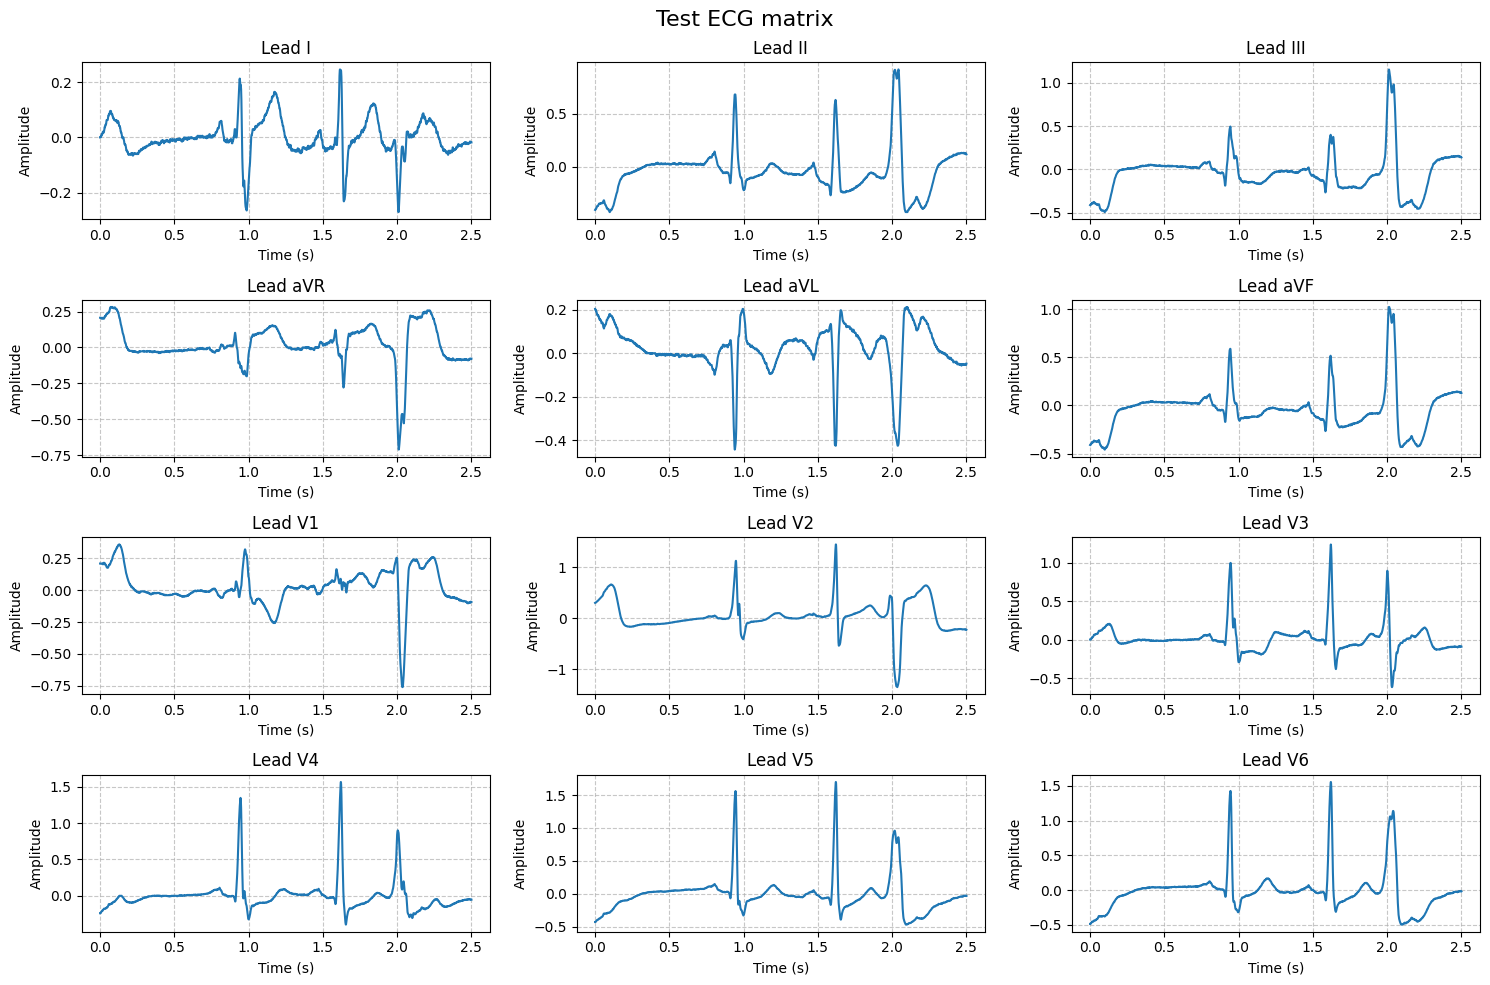

In [ ]:
plot_ecg(test_ecg_matrix, fs=1000, title="Test ECG matrix")

The given models should be used with non-noisy, downsampled versions of the ECGs, so we will first downsample the ECGs to 250 Hz. This is just to detect the segments, since we will train Model A with the original 1000 Hz ECGs to not lose any information/variability.

In [ ]:
def downsample_ecg(ecg, target_fs=250, fs=1000):
    ecg_downsampled = sak.signal.interpolate.interp1d(ecg, round(ecg.shape[0] * target_fs/fs), axis=0)
    return ecg_downsampled

test_ecg_250 = downsample_ecg(test_ecg_matrix)
print(f"Downsampled ECG shape: {test_ecg_250.shape}")

Downsampled ECG shape: (625, 12)


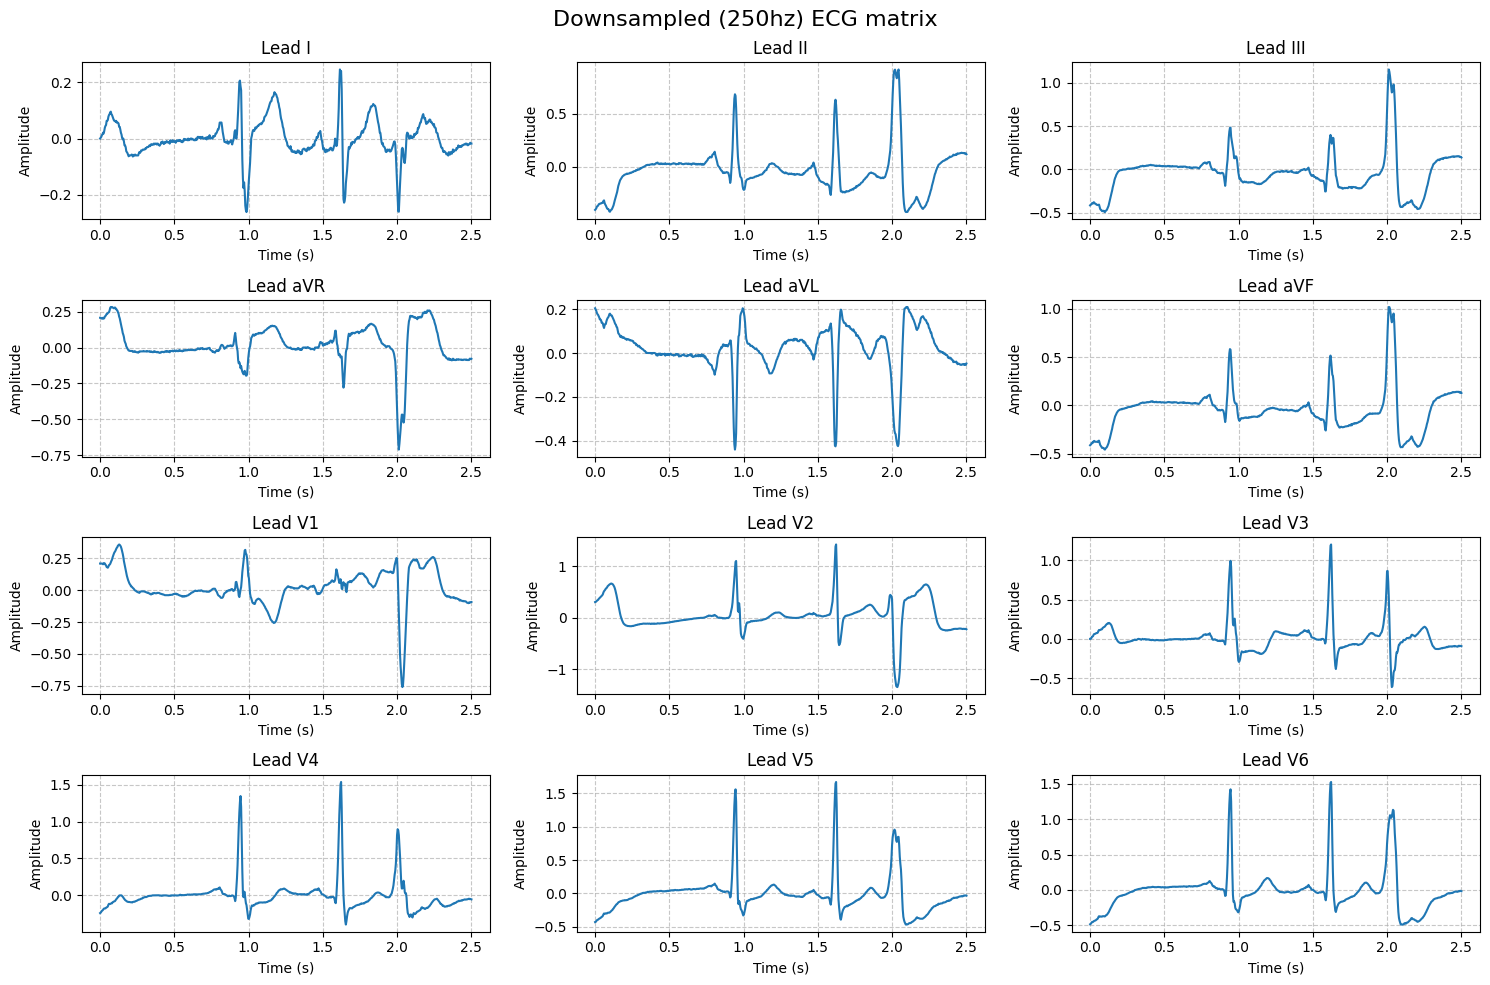

In [ ]:
plot_ecg(test_ecg_250, fs=250, title="Downsampled (250hz) ECG matrix")

It's recommended to both normalize the signal and apply filters to remove noise:

In [ ]:
def preprocess_ecg_signal(ecg_250, fs=250):
    # Normalize the signal
    lead_amplitudes = np.percentile(np.abs(ecg_250), 95, axis=0)
    lead_amplitudes[lead_amplitudes < 1e-6] = 1.0     # Avoid division by zero
    ecg_normalized = ecg_250 / lead_amplitudes[None, :]
    
    # Apply filters to remove noise
    b_high, a_high = sp.signal.butter(2, 0.5/fs, 'high')
    ecg_filtered = sp.signal.filtfilt(b_high, a_high, ecg_normalized, axis=0)
    b_low, a_low = sp.signal.butter(2, 125.0/fs, 'low')
    ecg_filtered = sp.signal.filtfilt(b_low, a_low, ecg_filtered, axis=0)
    
    # Avoid issues with negative strides due to filtering:
    if np.any(np.array(ecg_250.strides) < 0):
        ecg_250 = ecg_250.copy()
    
    return ecg_filtered

test_ecg_250 = preprocess_ecg_signal(test_ecg_250)

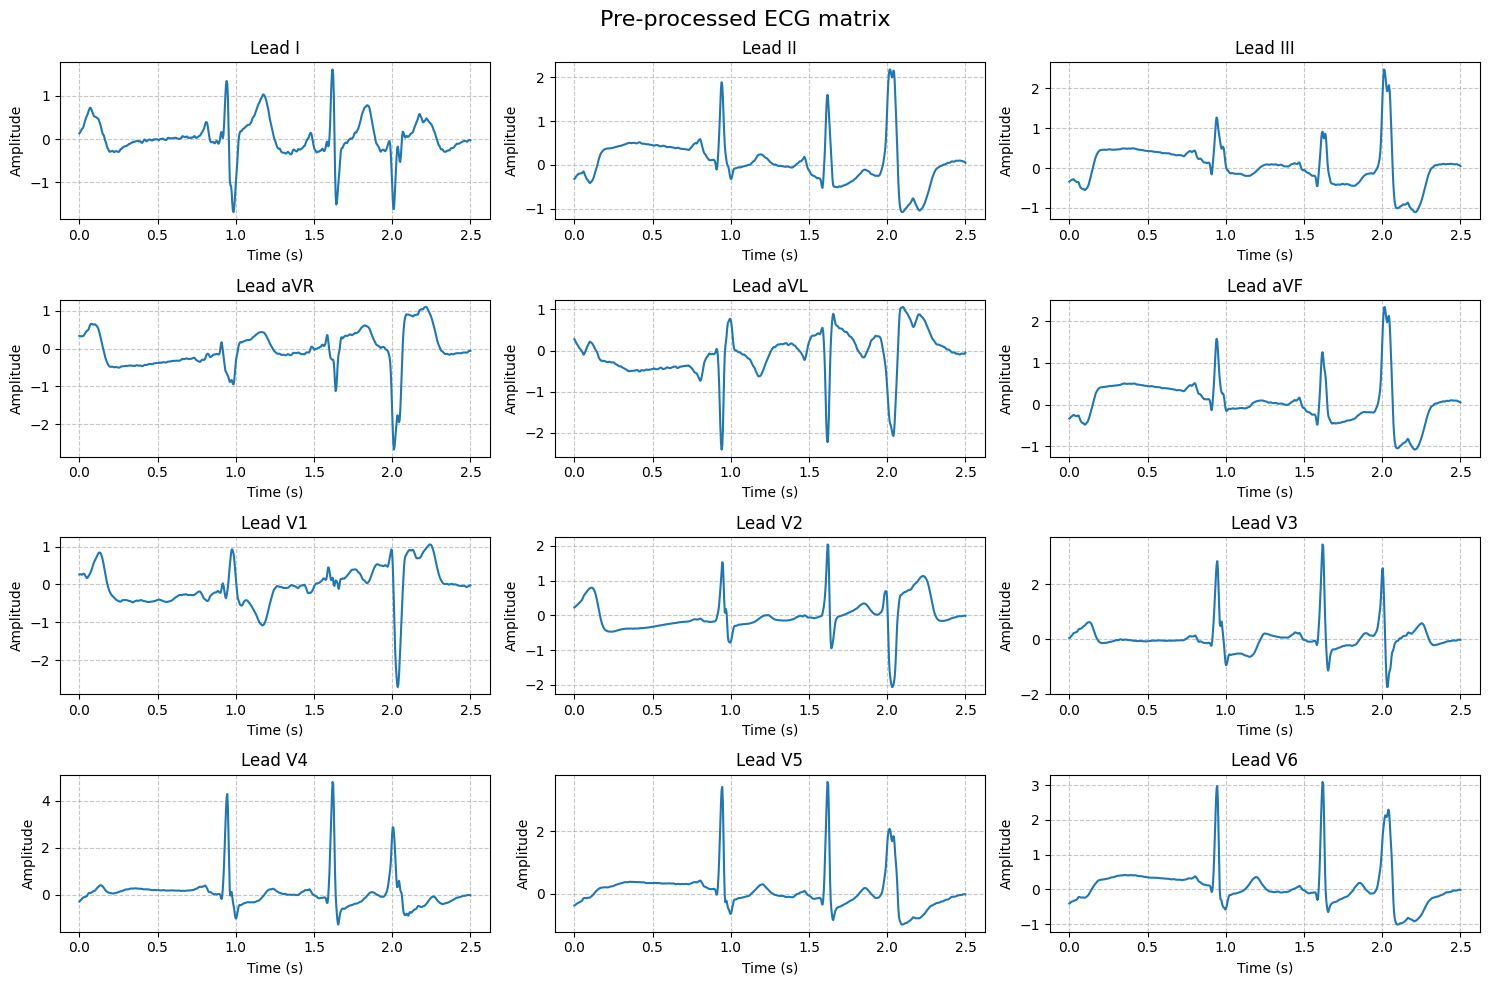

In [ ]:
plot_ecg(test_ecg_250, fs=250, title="Pre-processed ECG matrix")

The segmentation models operate by sliding a window (of size 2048 samples) across the signal, by a fixed stride of 256 samples. Without padding, for the current 625 samples (smaller than the 2048-sample window), the model can't process it at all.

In [ ]:
def predict_ecg(ecg: np.ndarray, ecg_250: np.ndarray, fs: float, model: List[torch.nn.Module],
                window_size: int = 2048, stride: int = 256, threshold_ensemble: float = 0.5,
                thr_dice=0.9, percentile=95, ptg_voting = 0.5, batch_size = 16,
                normalize=True, norm_threshold: float = 1e-6, filter = True) -> np.ndarray:
    """This function is used to delineate an ECG recording of arbitrary size ('ecg' variable, SAMPLES x LEADS)
    and to obtain the fiducials for the P, QRS and T segments as a binary mask of shape 3 x SAMPLES.

    Inputs:
    ecg                <- some array, e.g. shape 198484 x 12
    fs                 <- sampling frequency, e.g. 1000Hz. Will downsample to 250Hz for the AI model to work
    model              <- list of segmentation models for the ensemble
    window_size        <- the "chunk" size that will be processed at a time of the input ecg (e.g., in the example,
                          2048 samples out of the 198484 samples of the ECG)
    stride             <- the "stride" parameter allows for some overlap between the windows of the window_size
    threshold_ensemble <- Percentage of voting for the AI ensemble [0-1]
    thr_dice           <- Threshold for considering each sample as positive according to the Dice score
    percentile         <- Percentile for the amplitude normalization
    ptg_voting         <- Threshold for considering each sample as positive according to the Dice score
    batch_size         <- Number of windows that fit in the batch
    normalize          <- Boolean to indicate whether the ECG has to be normalized. In general, set this to True
                          always, as the ECGs must have the amplitude of a normal sinus rhythm around amplitude of
                          "1" to work, as that was the preprocessing for model training. Only change if a
                          comparable pre-processing is performed
    norm_threshold     <- Threshold for the normalization, to avoid passing baseline wander or noise as signal
    filter             <- Filter the signal with a band-pass filter in [0.5-125] Hz
    """
    # Pad if necessary
    if ecg_250.shape[0] < window_size:
        padding = math.ceil(ecg_250.shape[0]/window_size)*window_size-ecg_250.shape[0]
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')
    if (ecg_250.shape[0]-window_size)%stride != 0:
        padding = math.ceil((ecg_250.shape[0]-window_size)/stride)*stride-(ecg_250.shape[0]%window_size)
        ecg_250 = np.pad(ecg_250,((0,padding),(0,0)),mode='edge')

    N,L = ecg_250.shape
    
    # Data structure for computing the segmentation
    windowed_signal = skimage.util.view_as_windows(ecg_250,(window_size,1),(stride,1))

    # Flat batch shape
    new_shape = (windowed_signal.shape[0]*windowed_signal.shape[1],*windowed_signal.shape[2:])
    windowed_signal = np.reshape(windowed_signal,new_shape)

    # Exchange channel position
    windowed_signal = np.swapaxes(windowed_signal,1,2)

    # Output structures
    windowed_mask = np.zeros((windowed_signal.shape[0],3,windowed_signal.shape[-1]),dtype=int)

    # Check device for segmentation
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Compute segmentation for all leads independently
    with torch.no_grad():
        if isinstance(model,list):
            for m in model:
                m = m.to(device)
                for i in range(0,windowed_signal.shape[0],batch_size):
                    inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().detach().numpy()
                    windowed_mask[i:i+batch_size] += outputs > thr_dice
            windowed_mask = windowed_mask >= len(model)*threshold_ensemble
        else:
            model = model.to(device)
            for i in range(0,windowed_signal.shape[0],batch_size):
                inputs = {"x": torch.tensor(windowed_signal[i:i+batch_size]).to(device).float()}
                outputs = model(inputs)["sigmoid"].cpu().detach().numpy()
                windowed_mask[i:i+batch_size] = outputs > thr_dice

    # Retrieve mask as 1D
    counter = np.zeros((N), dtype=int)
    segmentation_250 = np.zeros((3,N))

    # Iterate over windows
    for i in range(0,windowed_mask.shape[0],L):
        counter[(i//L)*stride:(i//L)*stride+window_size] += 1
        segmentation_250[:,(i//L)*stride:(i//L)*stride+window_size] += windowed_mask[i:i+L].sum(0)
    segmentation_250 = ((segmentation_250/counter) >= (ecg_250.shape[-1]*ptg_voting))

    # Correct padding
    segmentation_250 = segmentation_250[:,:-padding]

    # Interpolate back to original sampling frequency
    segmentation     = sak.signal.interpolate.interp1d(segmentation_250,ecg.shape[0],axis=-1,kind="nearest")

    return segmentation


In [ ]:
segmentation_250 = predict_ecg(test_ecg_matrix, test_ecg_250, 250. ,models_ECG,normalize=True,filter=False)

# Interpolate back to original sampling frequency
segmentation = sak.signal.interpolate.interp1d(segmentation_250, test_ecg_matrix.shape[0], axis=-1, kind="nearest")

In [ ]:
def plot_segmentation(ecg_matrix, segmentation, fs=1000, time_duration=2.5, title=None, 
                      colors=None, segment_labels=None):
    # Default colors and labels if not provided
    if colors is None:
        colors = ['C0', 'C1', 'C2']
    if segment_labels is None:
        segment_labels = ['P wave', 'QRS complex', 'T wave']
    
    # Create subplot grid for 12 leads (4x3)
    fig, axes = plt.subplots(4, 3, figsize=(15, 10))
    
    # Time axis
    x = np.linspace(0, time_duration, int(fs * time_duration))
    
    # Lead names
    lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    
    # Plot each lead with segmentation overlay
    row = 0
    col = 0
    for i, sig in enumerate(ecg_matrix.T):
        ax = axes[row, col]
        
        # Plot signal
        ax.plot(x, sig)
        
        # Add colored overlay for each segment type
        for j in range(segmentation.shape[0]):
            ax.fill_between(x, np.min(sig), np.max(sig), 
                           where=(segmentation[j, :] == 1), 
                           color=colors[j], alpha=0.3)
        
        # Set title and grid for each subplot
        ax.set_title(f"Lead {lead_labels[i]}")
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Advance to next subplot position
        col += 1
        if col >= 3:
            row += 1
            col = 0
    
    # Add legend to the figure
    legend_elements = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.3, 
                       label=segment_labels[i]) for i in range(len(segment_labels))]
    fig.legend(handles=legend_elements, loc='lower center', ncol=3)
    
    # Add overall title if provided
    if title:
        plt.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    if title:
        plt.subplots_adjust(top=0.9, bottom=0.1)  # Make room for suptitle and legend
    else:
        plt.subplots_adjust(bottom=0.1)  # Make room for legend only
        
    plt.show()

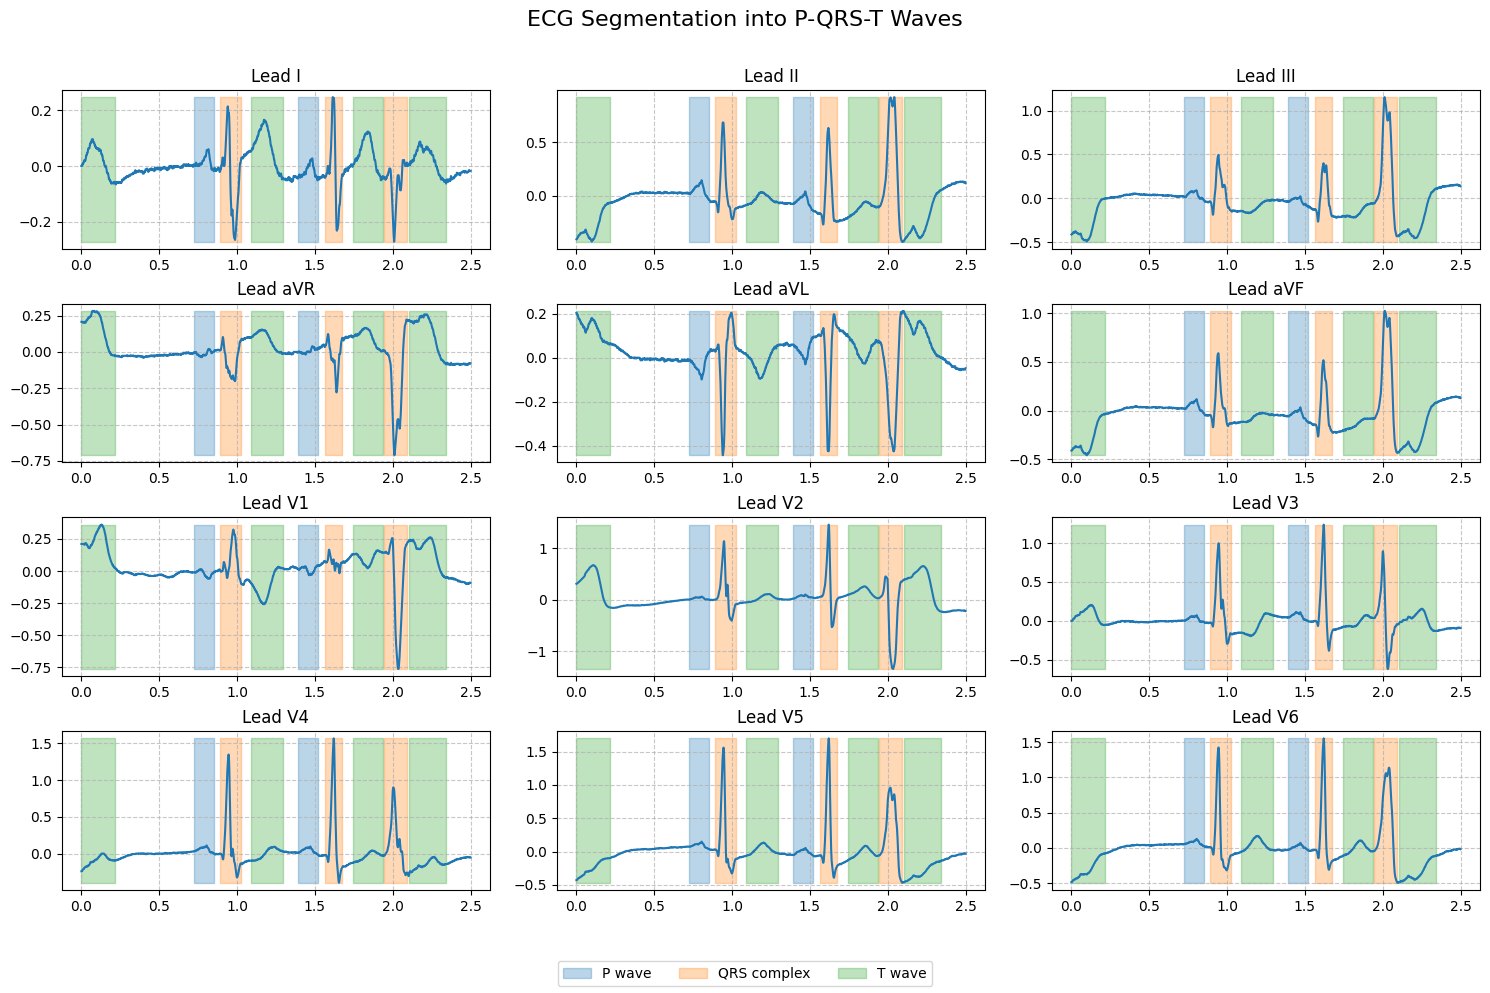

In [ ]:
# Plot the segmented ECG
plot_segmentation(
    test_ecg_matrix, 
    segmentation, 
    title="ECG Segmentation into P-QRS-T Waves"
)

Once we have the segmentation of the ECG, we want to store it in a human-readable format, that specifies for each segment kind (P, QRS, T) the start and end sample indices of the detected segments. This file should be very lightweight, and should be easy to read and parse.

The segmentation is performed by considering information from all leads simultaneously, but the output segmentation is a single set of intervals that applies across all leads. This is what we want to compute for each ECG matrix, and what we will store in a lightweight and readable format.

In [ ]:
def extract_segments_from_mask(segmentation_mask):
    segment_names = ['P', 'QRS', 'T']
    segments_dict = {name: [] for name in segment_names}
    
    # Process each waveform type (P, QRS, T)
    for i, name in enumerate(segment_names):
        # Find transitions from 0 to 1 (segment starts)
        mask = segmentation_mask[i]
        starts = np.where(np.diff(np.hstack(([0], mask.astype(int)))) == 1)[0]
        
        # Find transitions from 1 to 0 (segment ends)
        ends = np.where(np.diff(np.hstack((mask.astype(int), [0]))) == -1)[0]
        
        # Package into (start, end) tuples
        for start, end in zip(starts, ends):
            segments_dict[name].append((int(start), int(end)))
    
    return segments_dict

In [ ]:
# Convert segmentation mask to segment dictionary
segments = extract_segments_from_mask(segmentation)

def print_segments(segments):
    """Print segments in a human-readable format"""
    for wave_type, intervals in segments.items():
        print(f"{wave_type} wave segments:")
        for i, (start, end) in enumerate(intervals):
            print(f"  #{i+1}: samples {start}-{end} (duration: {end-start} samples)")

print_segments(segments)

P wave segments:
  #1: samples 723-851 (duration: 128 samples)
  #2: samples 1392-1519 (duration: 127 samples)
QRS wave segments:
  #1: samples 892-1023 (duration: 131 samples)
  #2: samples 1564-1676 (duration: 112 samples)
  #3: samples 1945-2088 (duration: 143 samples)
T wave segments:
  #1: samples 0-214 (duration: 214 samples)
  #2: samples 1088-1295 (duration: 207 samples)
  #3: samples 1745-1936 (duration: 191 samples)
  #4: samples 2105-2340 (duration: 235 samples)


And we can get the full segmentation just from this small dictionary:

In [ ]:
def plot_ecg_with_segments(ecg_matrix, segments_dict, fs=1000, title=None,
                          colors=None, segment_labels=None):
    # Convert segments dictionary back to binary mask format
    num_samples = ecg_matrix.shape[0]
    segment_mask = np.zeros((3, num_samples), dtype=bool)
    
    # Map segment names to indices
    segment_indices = {'P': 0, 'QRS': 1, 'T': 2}
    
    # Fill the mask with the segments
    for wave_type, intervals in segments_dict.items():
        idx = segment_indices[wave_type]
        for start, end in intervals:
            segment_mask[idx, start:end+1] = True
            
    time_duration = num_samples / fs  # Calculate time duration based on number of samples and sampling frequency
    
    # Use the existing plot_segmentation function to create the visualization
    plot_segmentation(
        ecg_matrix=ecg_matrix,
        segmentation=segment_mask,
        fs=fs,
        time_duration=time_duration,
        title=title,
        colors=colors,
        segment_labels=segment_labels
    )

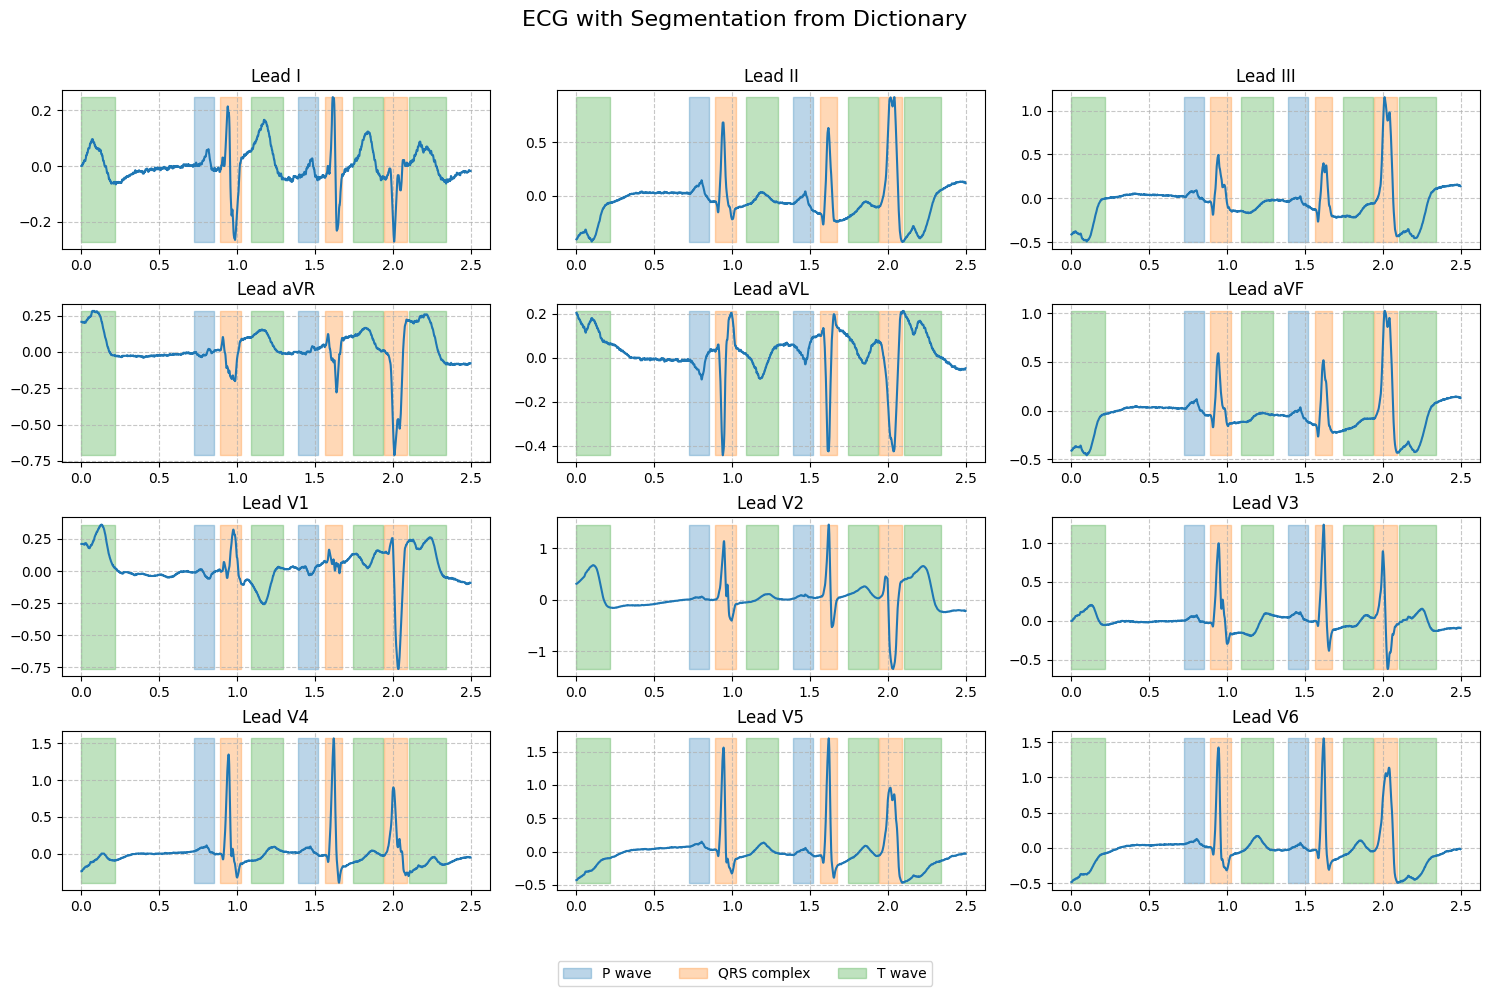

In [ ]:
plot_ecg_with_segments(
    test_ecg_matrix,
    segments,
    title="ECG with Segmentation from Dictionary"
)

In [ ]:
# Free up space from this step-by step test, we'll go now for full pipeline of a single ECG
del test_ecg_matrix
del test_ecg_250
del segmentation
del segmentation_250
del segments

Now that we have shown step by step the whole pipeline to segment a single ECG, we can unify it all into a single function that goes from the raw ECG matrix to returning the segmentation intervals:

In [ ]:
def segment_ecg(ecg_matrix, segmentation_models, fs=1000, target_fs=250, 
               plot_result=False, print_dict=False, title=None, return_segmentation=False):
    
    ecg_downsampled = downsample_ecg(ecg_matrix, target_fs=target_fs, fs=fs)
    ecg_preprocessed = preprocess_ecg_signal(ecg_downsampled, fs=target_fs)
    segmentation_downsampled = predict_ecg(
        ecg_matrix, ecg_preprocessed, target_fs, segmentation_models,
        normalize=True, filter=False
    )
    segmentation = sak.signal.interpolate.interp1d(
        segmentation_downsampled, ecg_matrix.shape[0], 
        axis=-1, kind="nearest"
    )
    segments_dict = extract_segments_from_mask(segmentation)
    
    if plot_result:
        plot_title = title if title else "ECG Segmentation into P-QRS-T Waves"
        plot_segmentation(
            ecg_matrix,
            segmentation,
            fs=fs,
            title=plot_title
        )
        
    if print_dict:
        print_segments(segments_dict)
        
    
    if return_segmentation:
        return segments_dict, segmentation
    else:
        return segments_dict

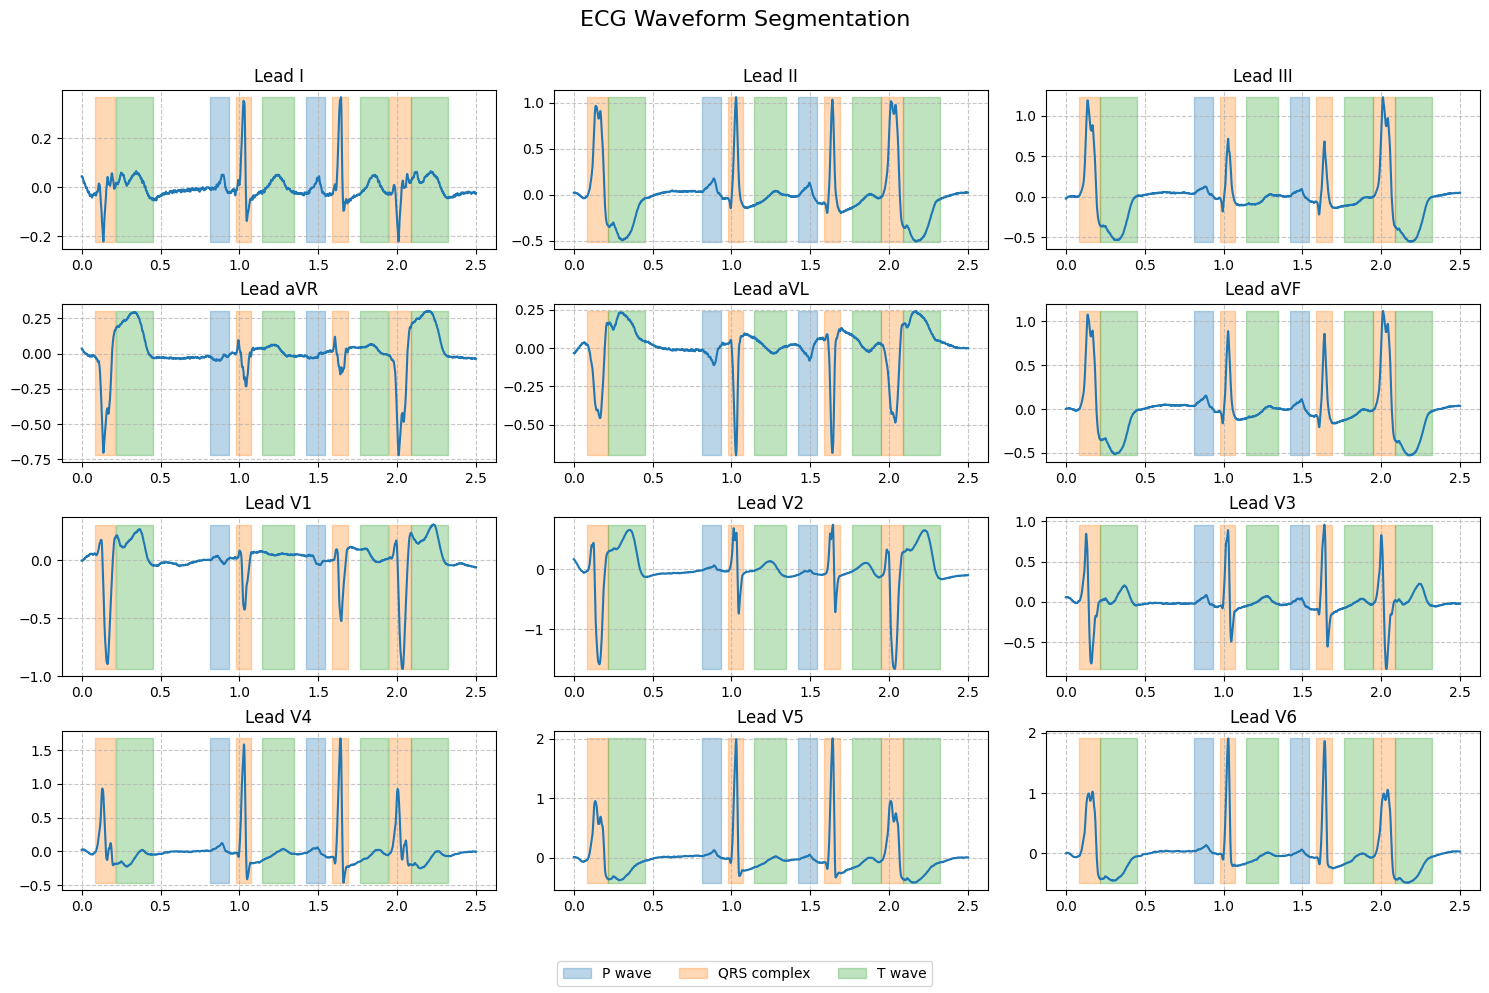

P wave segments:
  #1: samples 815-935 (duration: 120 samples)
  #2: samples 1420-1539 (duration: 119 samples)
QRS wave segments:
  #1: samples 83-214 (duration: 131 samples)
  #2: samples 980-1075 (duration: 95 samples)
  #3: samples 1584-1688 (duration: 104 samples)
  #4: samples 1949-2084 (duration: 135 samples)
T wave segments:
  #1: samples 215-450 (duration: 235 samples)
  #2: samples 1140-1343 (duration: 203 samples)
  #3: samples 1761-1944 (duration: 183 samples)
  #4: samples 2085-2320 (duration: 235 samples)


In [ ]:
segments = segment_ecg(ecg_matrices[1], models_ECG, plot_result=True, print_dict=True,  
                      title="ECG Waveform Segmentation")

del segments # To move to full dataset processing

Now that we can have a single function to segment any ECG from the matrices we already have, we can apply this function to all ECGs in the dataset. We will store the segmentations in a new dataframe, where each row corresponds to a single ECG and contains the segmentation intervals for that ECG. We can even persist this dataframe to disk, so that we can reuse it later without having to recompute the segmentations again.

In [ ]:
def make_downsampled_df(ecg_matrices,
                        fs: int = 1000,
                        target_fs: int = 250,
                        log_every: int = 2000) -> pd.DataFrame:
    total = len(ecg_matrices)
    print(f"Downsampling and preprocessing {total} ECGs...")
    ecgs250 = []
    for i, ecg in enumerate(ecg_matrices, start=1):
        ecg_250 = downsample_ecg(ecg, target_fs=target_fs, fs=fs)
        ecg_pre = preprocess_ecg_signal(ecg_250, fs=target_fs)
        ecgs250.append(ecg_pre)

        if i % log_every == 0 or i == total:
            print(f"   processed {i}/{total} "
                  f"({i/total*100:5.1f}%)")

    print("Preprocessing complete.\n")
    return ecgs250

# To run only if we do not have the segmentations done yet, as set up in a few cells

In [ ]:
def process_all_ecgs_segmentations(ecgs,
                                   ecgs250,
                                   ecg_identifiers,
                                   segmentation_models,
                                   fs: int = 1000,
                                   target_fs: int = 250):
    """
    ecgs            – list of np.ndarray, each shape (orig_samples, 12) at `fs`
    ecgs250         – list of np.ndarray, each shape (down_samples,12) at `target_fs`
    ecg_identifiers – pd.DataFrame, len == len(ecgs)
    segmentation_models – list of torch models or a single model

    Returns: list_of_dicts
    """
    # ── parameters ──────────────────────────────────────────────────────
    window_size = 2048
    stride      = 256
    thr_dice    = 0.9
    thr_ens     = 0.5
    ptg_voting  = 0.5
    batch_size  = 32  # to tune, depends on host machine
    total       = len(ecgs)

    # ── device & models setup ───────────────────────────────────────────
    device = ("mps"  if torch.backends.mps.is_available() else
              "cuda" if torch.cuda.is_available()        else
              "cpu")
    models = segmentation_models if isinstance(segmentation_models, list) else [segmentation_models]
    for m in models:
        m.to(device).eval().float()

    print(f"▶️  Segmenting {total:,} ECGs on {device.upper()}, ensemble={len(models)}")
    t0 = time.time()

    results = []
    processed = 0

    def _progress():
        elapsed = time.time() - t0
        rate    = processed / elapsed if elapsed else 0.0
        rem     = (total - processed) / rate if rate else float("inf")
        print(f"   {processed}/{total} ({processed/total*100:5.1f}%) – "
              f"{rate:6.2f} ECG/s, ~{rem/60:5.1f} min left",
              end="\r", flush=True)

    # ── main loop per ECG ─────────────────────────────────────────────────
    for ecg, ecg_250 in zip(ecgs, ecgs250):
        padding = 0
        processed += 1
        _progress()

        # Pad if necessary
        if ecg_250.shape[0] < window_size:
            padding = math.ceil(ecg_250.shape[0] / window_size) * window_size - ecg_250.shape[0]
            ecg_250 = np.pad(ecg_250, ((0, padding), (0, 0)), mode='edge')
        if (ecg_250.shape[0] - window_size) % stride != 0:
            extra = math.ceil((ecg_250.shape[0] - window_size) / stride) * stride - (ecg_250.shape[0] % window_size)
            padding += extra
            ecg_250 = np.pad(ecg_250, ((0, extra), (0, 0)), mode='edge')

        N, L = ecg_250.shape

        # Sliding windows
        windowed_signal = skimage.util.view_as_windows(ecg_250, (window_size, 1), (stride, 1))
        new_shape = (windowed_signal.shape[0] * windowed_signal.shape[1], *windowed_signal.shape[2:])
        windowed_signal = windowed_signal.reshape(new_shape).swapaxes(1, 2)

        # For accumulating per-window votes
        windowed_mask = np.zeros((windowed_signal.shape[0], 3, windowed_signal.shape[-1]), dtype=int)

        # Inference with ensemble
        with torch.no_grad():
            for m in models:
                for i in range(0, windowed_signal.shape[0], batch_size):
                    batch = windowed_signal[i:i+batch_size]
                    inputs = {"x": torch.tensor(batch).float().to(device)}
                    outputs = m(inputs)["sigmoid"].cpu().numpy()
                    windowed_mask[i:i+batch_size] += (outputs > thr_dice).astype(int)

        # Majority vote across models
        windowed_mask = windowed_mask >= (len(models) * thr_ens)

        # Reconstruct full-length mask at 250Hz
        counter = np.zeros((N,), dtype=int)
        segmentation_250 = np.zeros((3, N))
        for i in range(0, windowed_mask.shape[0], L):
            start = (i // L) * stride
            counter[start:start + window_size] += 1
            segmentation_250[:, start:start + window_size] += windowed_mask[i:i+L].sum(0)
        segmentation_250 = (segmentation_250 / counter) >= (ecg_250.shape[-1] * ptg_voting)

        # Remove padding
        if padding:
            segmentation_250 = segmentation_250[:, :-padding]

        # Upsample back to original sampling rate
        segmentation_down = sak.signal.interpolate.interp1d(
            segmentation_250, ecg.shape[0], axis=-1, kind='nearest'
        )
        segmentation = sak.signal.interpolate.interp1d(
            segmentation_down, ecg.shape[0], axis=-1, kind='nearest'
        )

        # Extract and store segments
        segments_dict = extract_segments_from_mask(segmentation)
        results.append(segments_dict)

    print()  # newline after progress
    print(f"✅ Done in {time.time() - t0:.1f}s ({total/(time.time() - t0):.2f} ECG/s)")
    return results

In [ ]:
def persist_segmentations(list, pickle_save_path):
    df = pd.DataFrame(list)
    os.makedirs(os.path.dirname(pickle_save_path), exist_ok=True)
    df.to_pickle(pickle_save_path)
    
    json_path = pickle_save_path.replace('.pkl', '.json')
    json_data = {}
    for idx, row in df.iterrows():
        row_dict = {}
        for key, value in row.items():
            row_dict[key] = value
        
        json_data[str(idx)] = row_dict
    
    # Write JSON with custom compact formatting for arrays
    with open(json_path, 'w') as f:
        json_str = json.dumps(json_data, indent=4, sort_keys=True)
        # Replace array formatting to make it more compact
        for pattern in [r'\[\s+(\d+),\s+(\d+)\s+\]']:
            json_str = re.sub(pattern, r'[\1, \2]', json_str)
        f.write(json_str)
    
    print(f"💾 Saved → {pickle_save_path} (pickle) and {json_path} (json)")

In [ ]:
def load_segmentations(pickle_path):
    try:
        # Load the DataFrame from the pickle file
        df = pd.read_pickle(pickle_path)
        
        # Convert the DataFrame back to a list of dictionaries
        segmentations_list = []
        for _, row in df.iterrows():
            segmentations_list.append(row.to_dict())
        
        print(f"Loaded {len(segmentations_list)} segmentation dictionaries from {pickle_path}")
        return segmentations_list
    
    except Exception as e:
        print(f"Error loading segmentations from {pickle_path}: {str(e)}")
        return []

In [ ]:
full_segmentations_path = 'outputs/full_segmentations.pkl'

if os.path.exists(full_segmentations_path):
    segmentations_list = load_segmentations(full_segmentations_path)
    print(f"Segmenting is heavy and has already been done. Loaded {len(segmentations_list)} segmentations from {full_segmentations_path}")
else:
    ecg_matrices_250 = make_downsampled_df(ecg_matrices, fs=1000, target_fs=250)
    
    
    segmentations_list = process_all_ecgs_segmentations(
        ecg_matrices,
        ecg_matrices_250,
        ecg_identifiers,
        segmentation_models=models_ECG,
        fs=1000,
        target_fs=250
    ) 

    persist_segmentations(segmentations_list, full_segmentations_path)
    del ecg_matrices_250  # Free memory after segmenting
    
del models_ECG  # Free memory after segmenting

Loaded 25094 segmentation dictionaries from outputs/full_segmentations.pkl
Segmenting is heavy and has already been done. Loaded 25094 segmentations from outputs/full_segmentations.pkl


In [ ]:
# To test: create subset of preprocessed ECGs and identifiers
testing = False

if testing:
    subset_size = 5
    subset_ecg = ecg_matrices[:subset_size]
    subset_ecg_250 = ecg_matrices_250[:subset_size]
    subset_identifiers = ecg_identifiers.iloc[:subset_size].copy()

    # Run segmentation on the subset
    segmentations_list = process_all_ecgs_segmentations(
        subset_ecg,
        subset_ecg_250,
        subset_identifiers,
        segmentation_models=models_ECG,
        fs=1000,
        target_fs=250
    )

    persist_segmentations(segmentations_list, 'outputs/segmentations_subset.pkl')

In [ ]:
if testing:
    for dict in segmentations_list:
        print_segments(dict)

In [ ]:
if testing:
    plot_ecg_with_segments(
        ecg_matrices[1],
        segmentations_list[1],
        title="ECG with Segmentation from Dictionary"
    )

### 3.3. Aligning ECGs

We will now do the aligning. We detect the R-wave peak in the QRS segment closest to the 2nd second. We then compute the difference between the R-wave peak sample and the 2nd second sample, and we will shift the ECG matrix by this difference to align it to the 2nd second.

In [ ]:
def align_ecgs_to_r_peak(ecg_matrices, segments_dicts, fs=1000, target_second=2.0, max_shift_samples=75):
    if len(ecg_matrices) != len(segments_dicts):
        raise ValueError(f"Number of ECG matrices ({len(ecg_matrices)}) must match number of segmentation dictionaries ({len(segments_dicts)})")
    
    target_sample = int(target_second * fs)
    orig_length = ecg_matrices[0].shape[0]
    
    # First pass: calculate all shifts needed
    shifts = []
    r_peak_samples = []
    
    print(f"Phase 1: Calculating required shifts for {len(ecg_matrices)} ECGs...")
    
    for i, (ecg_matrix, segments_dict) in enumerate(zip(ecg_matrices, segments_dicts)):
        # Find the QRS segment closest to the target sample
        qrs_segments = segments_dict['QRS']
        closest_qrs = None
        min_distance = float('inf')
        
        for qrs_start, qrs_end in qrs_segments:
            qrs_center = (qrs_start + qrs_end) // 2
            distance = abs(qrs_center - target_sample)
            
            if distance < min_distance:
                min_distance = distance
                closest_qrs = (qrs_start, qrs_end)
        
        if closest_qrs is None:
            print(f"Warning: No QRS segment found for ECG #{i}. Using center of ECG as reference.")
            r_peak_sample = ecg_matrix.shape[0] // 2
        else:
            # Extract the QRS segment
            qrs_start, qrs_end = closest_qrs
            
            # Find the R-peak within this QRS segment (maximum amplitude in lead II)
            lead_ii_signal = ecg_matrix[qrs_start:qrs_end+1, 1]
            r_peak_local_idx = np.argmax(np.abs(lead_ii_signal))
            r_peak_sample = qrs_start + r_peak_local_idx
        
        # Calculate the shift needed
        shift = target_sample - r_peak_sample
        shifts.append(shift)
        r_peak_samples.append(r_peak_sample)
    
    # Identify outlier ECGs that require extreme shifts
    outlier_indices = []
    normal_indices = []
    
    for i, shift in enumerate(shifts):
        if abs(shift) > max_shift_samples:
            outlier_indices.append(i)
        else:
            normal_indices.append(i)
    
    # Calculate max left and right shifts among non-outliers to determine crop boundaries
    normal_shifts = [shifts[i] for i in normal_indices]
    max_right_shift = max(0, max(normal_shifts)) if normal_shifts else 0
    max_left_shift = max(0, -min(normal_shifts)) if normal_shifts else 0
    
    # Calculate final dimensions that will contain only real data for all ECGs
    final_length = orig_length - max_right_shift - max_left_shift
    
    print(f"Phase 2: Aligning {len(normal_indices)} ECGs (identified {len(outlier_indices)} outliers)...")
    print(f"- Maximum right shift: {max_right_shift} samples")
    print(f"- Maximum left shift: {max_left_shift} samples")
    print(f"- Original length: {orig_length} samples, Final length: {final_length} samples")
    
    # Second pass: apply shifts then crop to consistent size containing only real data
    aligned_ecgs = []
    updated_segments = []
    
    for i, (ecg_matrix, segments_dict, shift) in enumerate(zip(ecg_matrices, segments_dicts, shifts)):
        if i in outlier_indices:
            continue
            
        # First apply the shift to align the R-peak
        shifted_ecg = np.zeros_like(ecg_matrix)
        
        if shift > 0:  # Shift right (R-peak was too early)
            shifted_ecg[shift:, :] = ecg_matrix[:-shift, :] if shift < ecg_matrix.shape[0] else ecg_matrix[:0, :]
            # Fill the beginning with the first sample repeated
            for j in range(shift):
                shifted_ecg[j, :] = ecg_matrix[0, :]
        elif shift < 0:  # Shift left (R-peak was too late)
            abs_shift = abs(shift)
            shifted_ecg[:-abs_shift, :] = ecg_matrix[abs_shift:, :]
            # Fill the end with the last sample repeated
            for j in range(1, abs_shift + 1):
                shifted_ecg[-j, :] = ecg_matrix[-1, :]
        else:  # No shift needed
            shifted_ecg = ecg_matrix.copy()
        
        # Then crop to a consistent size containing only real data
        # The crop region is determined by the maximum shifts required across all ECGs
        start_idx = max_left_shift
        end_idx = orig_length - max_right_shift
        
        # Extract the crop region
        cropped_ecg = shifted_ecg[start_idx:end_idx, :]
        aligned_ecgs.append(cropped_ecg)
        
        # Update segmentation info with the same operations (shift then crop)
        new_segments_dict = {wave_type: [] for wave_type in segments_dict.keys()}
        for wave_type, intervals in segments_dict.items():
            for start, end in intervals:
                # Apply shift
                shifted_start = start + shift
                shifted_end = end + shift
                
                # Apply crop by adjusting for start_idx
                cropped_start = shifted_start - start_idx
                cropped_end = shifted_end - start_idx
                
                # Only include segments that overlap with the cropped region
                if cropped_end >= 0 and cropped_start < final_length:
                    # Clip to boundaries
                    cropped_start = max(0, cropped_start)
                    cropped_end = min(final_length - 1, cropped_end)
                    new_segments_dict[wave_type].append((int(cropped_start), int(cropped_end)))
        
        updated_segments.append(new_segments_dict)
    
    # Verify final shape consistency
    lengths = [ecg.shape[0] for ecg in aligned_ecgs]
    if min(lengths) != max(lengths):
        print(f"Warning: Not all aligned ECGs have the same length. Min: {min(lengths)}, Max: {max(lengths)}")
    else:
        print(f"Success: All {len(aligned_ecgs)} ECGs aligned to {lengths[0]} samples")
    
    print(f"Excluded {len(outlier_indices)} outlier ECGs with extreme shifts")
    
    # Print statistics on the outliers
    if outlier_indices:
        outlier_shifts = [shifts[i] for i in outlier_indices]
        print(f"Outlier shifts range: {min(outlier_shifts)} to {max(outlier_shifts)} samples")
        
        # Print a few examples of extreme cases
        extreme_examples = sorted([(abs(shifts[i]), i) for i in outlier_indices], reverse=True)[:5]
        print(f"Top 5 extreme outliers (shift, index):")
        for shift_abs, idx in extreme_examples:
            print(f"  - ECG #{idx}: shift of {shifts[idx]} samples ({shifts[idx]/fs:.3f} seconds)")
    
    # Determine new approximate R-peak position in final aligned ECGs
    new_r_peak_position = target_sample - max_left_shift
    print(f"R-peaks are now approximately at sample {new_r_peak_position} ({new_r_peak_position/fs:.2f}s)")
    
    return aligned_ecgs, updated_segments, outlier_indices

In [ ]:
if testing:
    aligned_ecg_matrices, updated_segmentations = align_ecgs_to_r_peak(
        subset_ecg,   
        segmentations_list, 
        fs=1000
    )

    print(f"Original ECG shape: {ecg_matrices[0].shape}")
    print(f"Aligned ECG shape: {aligned_ecg_matrices[0].shape}")
    print(f"All aligned ECGs have same shape: {all(ecg.shape == aligned_ecg_matrices[0].shape for ecg in aligned_ecg_matrices)}")

    # Plot an aligned ECG with its updated segmentation
    plot_ecg_with_segments(
        aligned_ecg_matrices[1],
        updated_segmentations[1],
        title="Aligned ECG with Updated Segmentation"
    )

    persist_segmentations(updated_segmentations, 'outputs/updated_segmentations_subset.pkl')
    del subset_ecg
    del subset_ecg_250
    del subset_identifiers

Phase 1: Calculating required shifts for 25094 ECGs...
Phase 2: Aligning 24982 ECGs (identified 112 outliers)...
- Maximum right shift: 72 samples
- Maximum left shift: 75 samples
- Original length: 2500 samples, Final length: 2353 samples
Success: All 24982 ECGs aligned to 2353 samples
Excluded 112 outlier ECGs with extreme shifts
Outlier shifts range: -473 to 652 samples
Top 5 extreme outliers (shift, index):
  - ECG #17748: shift of 652 samples (0.652 seconds)
  - ECG #16480: shift of 645 samples (0.645 seconds)
  - ECG #4662: shift of 504 samples (0.504 seconds)
  - ECG #16476: shift of 502 samples (0.502 seconds)
  - ECG #16478: shift of -473 samples (-0.473 seconds)
R-peaks are now approximately at sample 1925 (1.93s)
Original ECG shape: (2500, 12)
Aligned ECG shape: (2353, 12)
All aligned ECGs have same shape: True


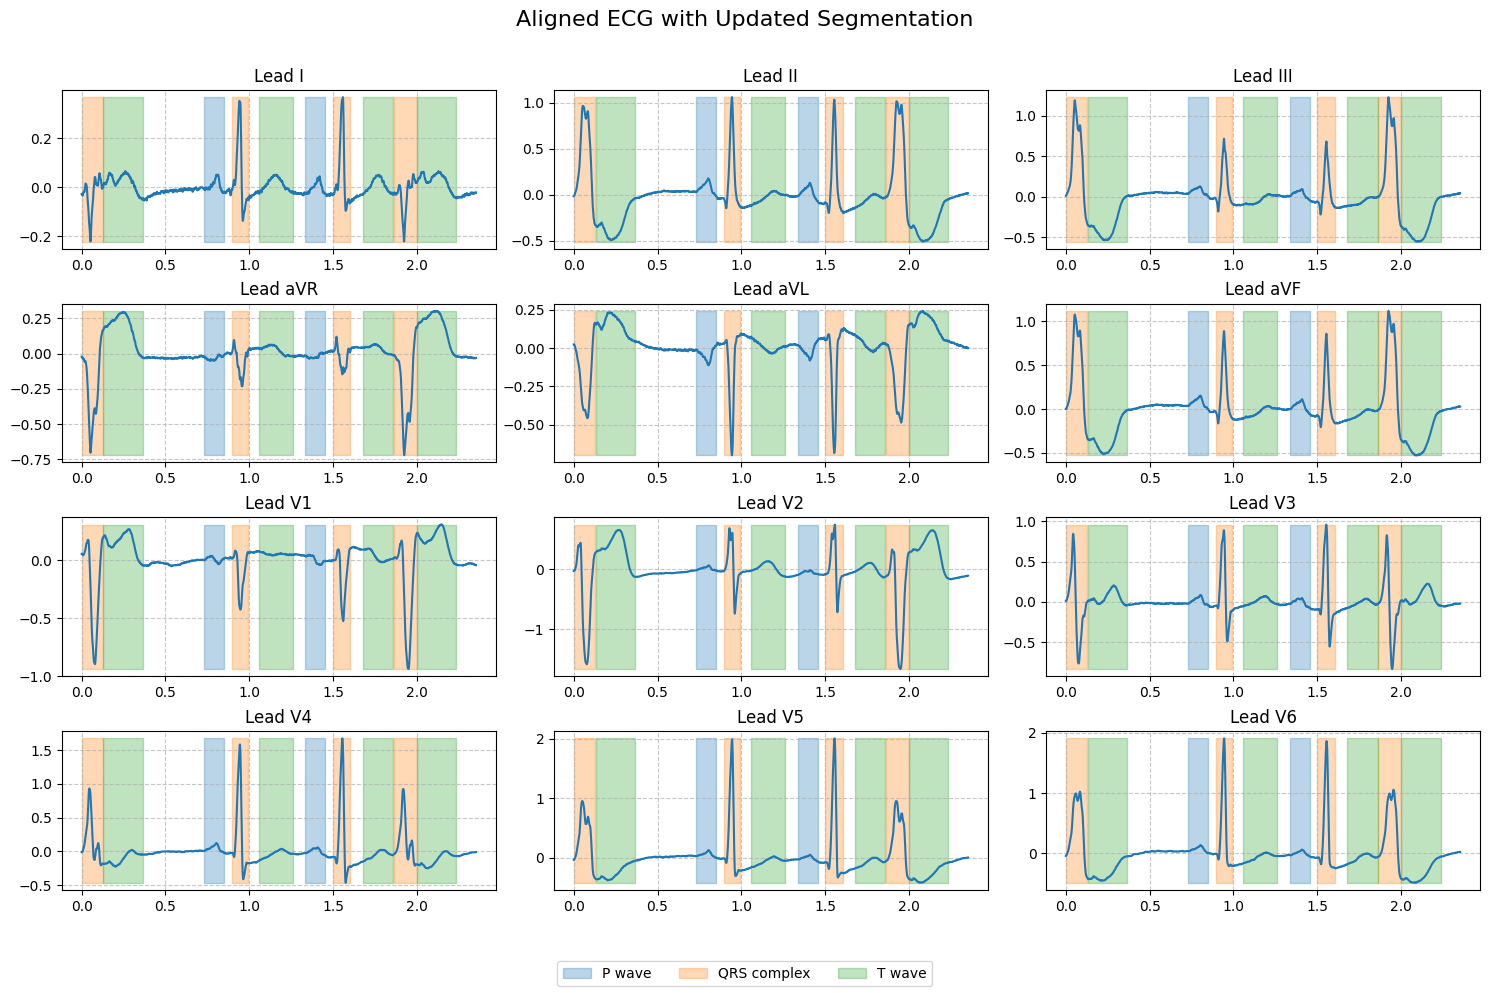

💾 Saved → outputs/updated_segmentations.pkl (pickle) and outputs/updated_segmentations.json (json)


In [ ]:
aligned_ecg_matrices, updated_segmentations, outlier_indices = align_ecgs_to_r_peak(
    ecg_matrices,   
    segmentations_list, 
    fs=1000
)

print(f"Original ECG shape: {ecg_matrices[0].shape}")
print(f"Aligned ECG shape: {aligned_ecg_matrices[0].shape}")
print(f"All aligned ECGs have same shape: {all(ecg.shape == aligned_ecg_matrices[0].shape for ecg in aligned_ecg_matrices)}")

# Plot an aligned ECG with its updated segmentation
plot_ecg_with_segments(
    aligned_ecg_matrices[1],
    updated_segmentations[1],
    title="Aligned ECG with Updated Segmentation"
)

persist_segmentations(updated_segmentations, 'outputs/updated_segmentations.pkl')

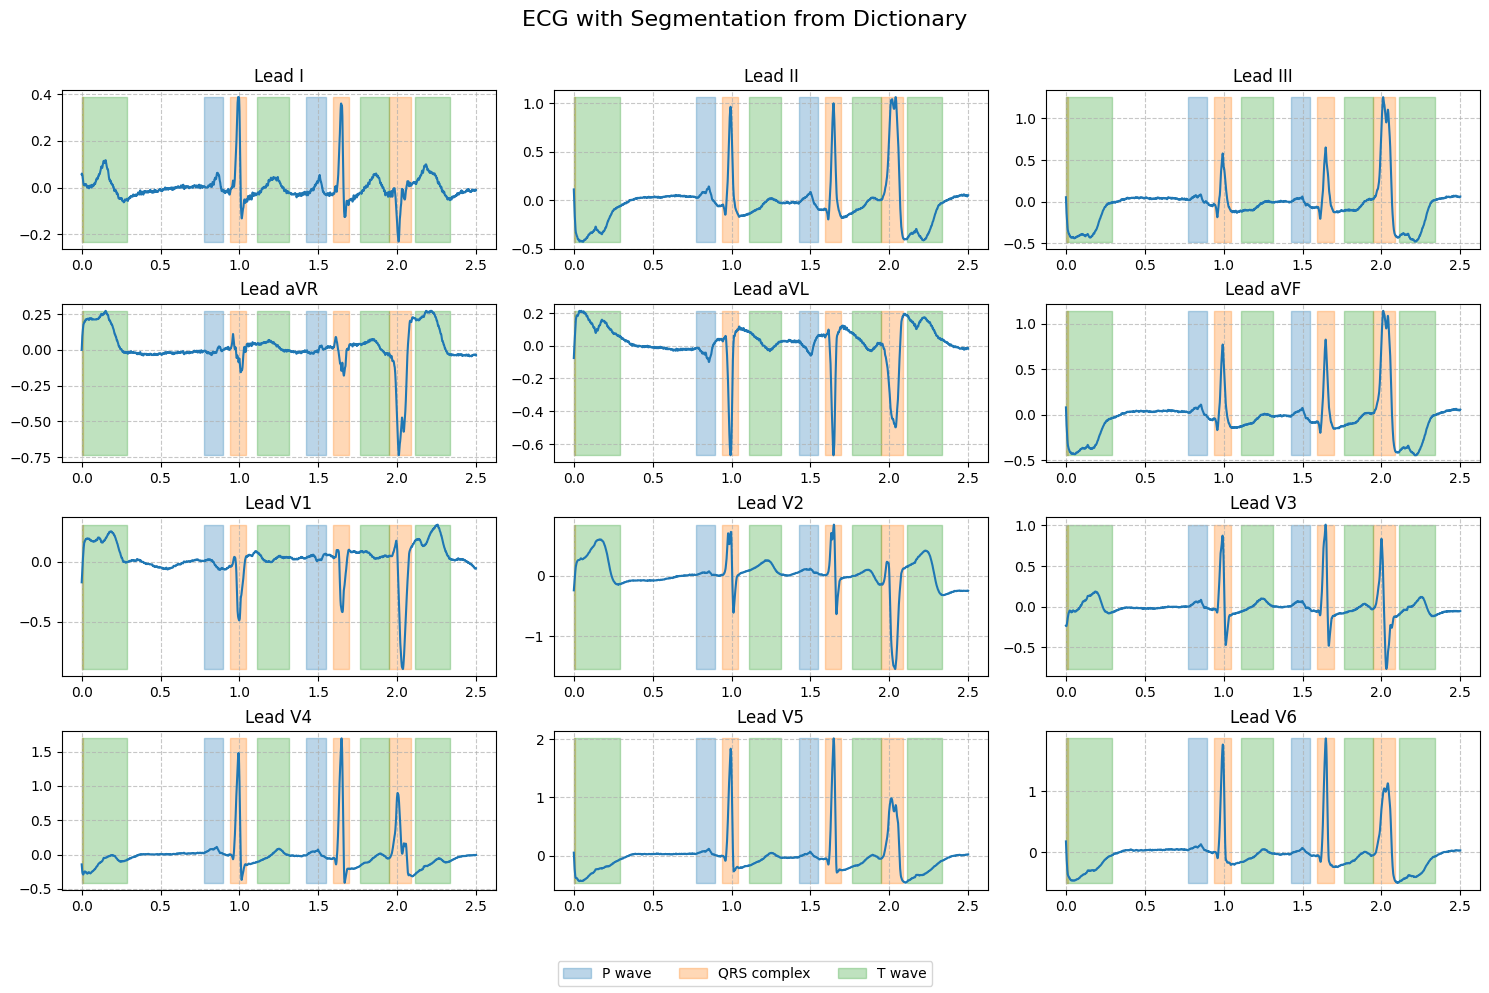

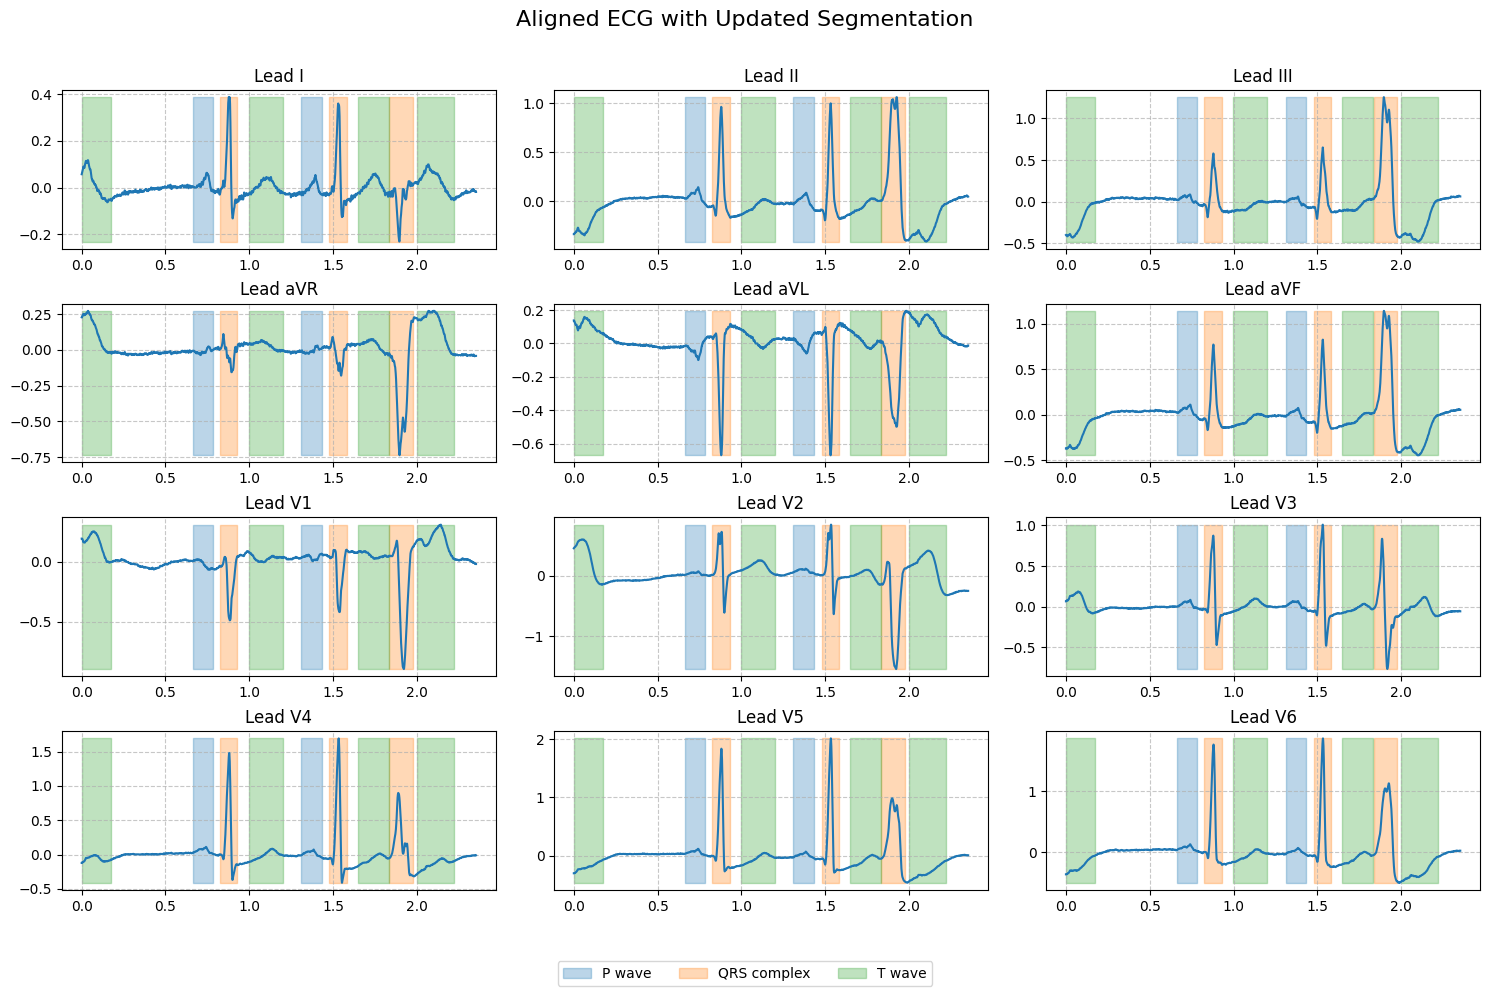

In [ ]:
# Plot an aligned ECG with its updated segmentation
plot_ecg_with_segments(
    ecg_matrices[3],
    segmentations_list[3],
    title="ECG with Segmentation from Dictionary"
)

plot_ecg_with_segments(
    aligned_ecg_matrices[3],
    updated_segmentations[3],
    title="Aligned ECG with Updated Segmentation"
)


In [ ]:
wanna_plot_more = False

if wanna_plot_more:
    for i in range(1, 10):
        # Plot an aligned ECG with its updated segmentation
        plot_ecg_with_segments(
            aligned_ecg_matrices[i],
            updated_segmentations[i],
            title="Aligned ECG with Updated Segmentation"
        )

In [ ]:
def save_ecgs_as_images(ecg_matrices, segmentations, output_dir='outputs/ecg_images', 
                        file_prefix="ecg", title_prefix="Aligned ECG", dpi=150, format='png'):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    image_paths = []
    
    print(f"Saving {len(ecg_matrices)} ECG plots as images...")
    
    # Save each ECG plot as an image
    for i, (ecg, segmentation) in enumerate(zip(ecg_matrices, segmentations)):
        # Create the figure and save it without displaying it first
        img_path = os.path.join(output_dir, f"{file_prefix}_{i+1:03d}.{format}")
        
        # Create a new figure with proper size
        fig, axes = plt.subplots(4, 3, figsize=(15, 10))
        
        # Convert segments dictionary back to binary mask format
        num_samples = ecg.shape[0]
        segment_mask = np.zeros((3, num_samples), dtype=bool)
        
        # Map segment names to indices
        segment_indices = {'P': 0, 'QRS': 1, 'T': 2}
        
        # Fill the mask with the segments
        for wave_type, intervals in segmentation.items():
            idx = segment_indices[wave_type]
            for start, end in intervals:
                if start < num_samples and end < num_samples:  # Ensure we don't go out of bounds
                    segment_mask[idx, start:end+1] = True
        
        # Colors and labels for segments
        colors = ['C0', 'C1', 'C2']
        segment_labels = ['P wave', 'QRS complex', 'T wave']
        
        # Time axis
        time_duration = num_samples / 1000  # Calculate time duration based on sampling frequency
        x = np.linspace(0, time_duration, num_samples)
        
        # Lead names
        lead_labels = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
        
        # Plot each lead with segmentation overlay
        for lead_idx in range(12):
            row = lead_idx // 3
            col = lead_idx % 3
            
            ax = axes[row, col]
            sig = ecg[:, lead_idx]
            
            # Plot signal
            ax.plot(x, sig)
            
            # Add colored overlay for each segment type
            for j in range(segment_mask.shape[0]):
                ax.fill_between(x, np.min(sig), np.max(sig), 
                               where=segment_mask[j, :], 
                               color=colors[j], alpha=0.3)
            
            # Set title and grid for each subplot
            ax.set_title(f"Lead {lead_labels[lead_idx]}")
            ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend to the figure
        legend_elements = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.3, 
                           label=segment_labels[i]) for i in range(len(segment_labels))]
        fig.legend(handles=legend_elements, loc='lower center', ncol=3)
        
        # Add overall title
        plt.suptitle(f"{title_prefix} #{i+1}", fontsize=16)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.9, bottom=0.1)  # Make room for suptitle and legend
        
        # Save the figure and close it to prevent memory leaks
        fig.savefig(img_path, dpi=dpi, bbox_inches='tight', format=format)
        plt.close(fig)
        
        image_paths.append(img_path)
        
        # Progress indicator
        if (i+1) % 10 == 0 or i == len(ecg_matrices)-1:
            print(f"  Saved {i+1}/{len(ecg_matrices)} images")
    
    print(f"✓ All ECG plots saved successfully to {output_dir}/")
    return image_paths

In [ ]:
wanna_export_segmented_ecgs = False

if wanna_export_segmented_ecgs:
    image_paths = save_ecgs_as_images(
        ecg_matrices=aligned_ecg_matrices[:10],
        segmentations=updated_segmentations[:10], 
        output_dir='outputs/ecg_images', 
        file_prefix="ecg", 
        title_prefix="Aligned ECG", 
        dpi=150, 
        format='png'  
    )

### 3.4. Flattening aligned ECGs in batches

As one last step, we want to make sure each ECG is a vector:

In [ ]:
print(f"Aligned ECG matrices shape: {len(aligned_ecg_matrices)} matrices, each with shape {aligned_ecg_matrices[0].shape}")

# Clean up memory for unaligned data (we won't be using it forward)
del segmentations_list
del ecg_matrices

Aligned ECG matrices shape: 24982 matrices, each with shape (2353, 12)


The following cell will flatten all aligned ECGs into a single vector of 12000 samples (12 leads * 1000 samples per lead), and store them in a new dataframe in batches. It is quite slow to run (approximately 3 minutes), but its needed since we don't want to persist the flattened ECGs to disk as they would be a few GBs in size:

In [ ]:
# processing in smaller batches:
batch_size = 2000  # Adjust based on memory constraints
flattened_ecgs_df = pd.DataFrame()

for i in range(0, len(aligned_ecg_matrices), batch_size):
    batch = aligned_ecg_matrices[i:i+batch_size]
    flattened_batch = [ecg.reshape(-1) for ecg in batch]
    batch_df = pd.DataFrame(flattened_batch)
    flattened_ecgs_df = pd.concat([flattened_ecgs_df, batch_df], ignore_index=True)
    print(f"Processed batch {i//batch_size + 1}/{(len(aligned_ecg_matrices) + batch_size - 1) // batch_size} "
          f"with {len(batch)} ECGs, current shape: {flattened_ecgs_df.shape}")
    # Clear intermediates explicitly
    del batch, flattened_batch, batch_df
    
print(f"Flattened ECGs shape: {flattened_ecgs_df.shape}")

Processed batch 1/13 with 2000 ECGs, current shape: (2000, 28236)
Processed batch 2/13 with 2000 ECGs, current shape: (4000, 28236)
Processed batch 3/13 with 2000 ECGs, current shape: (6000, 28236)
Processed batch 4/13 with 2000 ECGs, current shape: (8000, 28236)
Processed batch 5/13 with 2000 ECGs, current shape: (10000, 28236)
Processed batch 6/13 with 2000 ECGs, current shape: (12000, 28236)
Processed batch 7/13 with 2000 ECGs, current shape: (14000, 28236)
Processed batch 8/13 with 2000 ECGs, current shape: (16000, 28236)
Processed batch 9/13 with 2000 ECGs, current shape: (18000, 28236)
Processed batch 10/13 with 2000 ECGs, current shape: (20000, 28236)
Processed batch 11/13 with 2000 ECGs, current shape: (22000, 28236)
Processed batch 12/13 with 2000 ECGs, current shape: (24000, 28236)
Processed batch 13/13 with 982 ECGs, current shape: (24982, 28236)
Flattened ECGs shape: (24982, 28236)


And in this point we now have a single dataframe with all aligned ECGs, each a single vector, which will be the input to Model A. We also keep a separate dataframe with the segmentations for the aligned ECGs, that we can use for visualization purposes. We can free up space for all intermediate data structures that we don't need anymore, to keep the memory footprint low:

In [ ]:
# We will use only flattened_ecgs_df on Model A training.
# We will still keep the aligned_ecg_matrices for further analysis or Model B training.
# del flattened_ecgs
del updated_segmentations

## 4. Model A: Dimensionality reduction for ECG signals

### 4.1. Perform (randomized) PCA on the aligned ECGs

We now have a single dataframe with all aligned ECGs (24982 samples of 28236 dimensions), each represented as a vector of samples across all leads. This is still much more data/dimensions than we want to use for the classification models, so we will train Model A to learn a low-dimensional representation of the ECGs.

Since we want to make the low-dimensionality representation be as close to optimal as possible, we will be using Principal Component Analysis (PCA) to reduce the dimensionality of the ECGs. We will be aiming to preserve at least 95% of the variance in the data in far fewer dimensions.

Also, since we want the learned features to be interpretable and ideally related to specific characteristics of the ECGs, we will apply Varimax rotation to the PCA components. This will help us obtain a set of orthogonal components that are easier to interpret, without requiring more dimensions nor more complex models.

In [ ]:
from sklearn.decomposition import PCA

training_pca = False  # Set to False to skip PCA training
if training_pca:
    print(f"Starting PCA for {flattened_ecgs_df.shape} matrix...")

    # Experimentally, 200 components retain about 95% of variance
    pca = PCA(n_components=200, svd_solver='randomized', random_state=42)
    X_pca = pca.fit_transform(flattened_ecgs_df.values)
    
    loadings = pca.components_

    print(f"PCA complete: retained {pca.n_components_} components explaining {sum(pca.explained_variance_ratio_):.2%} variance")
    del X_pca

In [ ]:
# Save full PCA model (contains loadings and other attributes)
pca_save_path = 'outputs/pca_model_95.pkl'
loadings_save_path = 'outputs/pca_loadings_95.npy'

if training_pca:
    with open(pca_save_path, 'wb') as f:
        pickle.dump(pca, f)

    # Save just the loadings (components) separately as numpy array
    np.save(loadings_save_path, loadings)

    print(f"Saved PCA model to {pca_save_path}")
    print(f"Saved loadings ({loadings.shape}) to {loadings_save_path}")

In [ ]:
def load_pca_model(pca_path, loadings_path):
    with open(pca_path, 'rb') as f:
        pca = pickle.load(f)
    loadings = np.load(loadings_path)
    return pca, loadings

if not training_pca:
    print(f"Loading PCA model from {pca_save_path} and loadings from {loadings_save_path}")
    pca, loadings = load_pca_model(pca_save_path, loadings_save_path)

Loading PCA model from outputs/pca_model_95.pkl and loadings from outputs/pca_loadings_95.npy


In [ ]:
# Apply PCA to the flattened ECGs to get reduced features
X_reduced = pca.transform(flattened_ecgs_df.values)
print(f"Reduced features shape: {X_reduced.shape}")

Reduced features shape: (24982, 200)


In [ ]:
# Reduce the floating point precision to save memory
X_reduced = X_reduced.astype(np.float32)

### 4.2. Varimax rotation of PCA loadings

Now that we only have the 200 top components, we will use the loadings we have learned (mappings from original dimensionality to the new reduced dimensionality) to find a rotated version of the PCA components with more temporal coherence, which will be more interpretable and easier to understand.

In [ ]:
import torch
import time
import os

def varimax_torch_optimized(
    Phi,
    gamma: float = 1.0,
    max_iter: int = 100,
    tol: float = 1e-6,
    checkpoint_path: str = None
): # We follow an implementation of the varimax algorithm optimized for PyTorch, which can leverage hardware acceleration (MPS or CUDA) for faster SVD/matrixmul computation.
    # 1) Device selection (using hardware acceleration whenever possible)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
        print("Using MPS (Metal) acceleration")
    elif torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using CUDA acceleration")
    else:
        device = torch.device("cpu")
        print("Using CPU")

    # 2) Convert to tensor
    Phi_torch = torch.tensor(Phi, dtype=torch.float32, device=device)
    p, k = Phi_torch.shape
    print(f"Running varimax on tensor of shape {p}x{k} on {device}")

    # 3) Checkpoint: store/load the current Phi and d_old
    d_old = 0.0
    start_iter = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        chk = torch.load(checkpoint_path)
        Phi_torch = chk['Phi'].to(device)
        d_old = chk['d_old']
        start_iter = chk['iteration'] + 1
        print(f"Resuming at iter {start_iter} with d_old={d_old:.6f}")

    gamma_p_inv = gamma / p
    # Initialize R as identity
    R = torch.eye(p, device=device)

    # 4) Iterative varimax using pxp SVD
    # Note: each iteration on MPS accelerated device has taken about 45 minutes.
    for n in range(start_iter, max_iter):
        t0 = time.time()

        # Current loadings L = R^T @ Phi_torch
        L = R.T @ Phi_torch    # (p, k)

        # Compute mean of squared loadings per component
        mu2 = L.pow(2).mean(dim=1, keepdim=True)  # (p,1)
        # Weighted term
        term = L * (L.pow(2) - mu2)                # (p, k)

        # Procrustes matrix M = term @ L^T
        M = term @ L.T                             # (p, p)

        # SVD on M -> U, S, Vt
        U, S, Vt = torch.linalg.svd(M, full_matrices=False) # This is the slowest part, but necessary for rotation
        d = S.sum().item()                         # current criterion value

        # Update rotation
        R = U @ Vt                                 # new R

        # Check convergence
        delta = abs(d - d_old)
        print(f"Iter {n+1}: d={d:.6f}, Δ={delta:.6f}, time={time.time()-t0:.3f}s")
        if delta < tol:
            print(f"Converged after {n+1} iters")
            break
        d_old = d

        if checkpoint_path:
            torch.save({'Phi': Phi_torch.cpu(), 'd_old': d, 'iteration': n}, checkpoint_path)

    # Compute final rotated loadings on CPU
    rotated = (R.T @ Phi_torch).cpu().numpy()
    return rotated, R.cpu()

In [ ]:
compute_varimax = False  # Set to False to skip varimax rotation
loadings_save_path = 'outputs/pca_rotated_loadings_95.npy'

if compute_varimax:
    print("Starting varimax rotation...")
    checkpoint_path = 'outputs/varimax.pt'

    rotated_loadings, R = varimax_torch_optimized(
        loadings,
        gamma=1.0,
        max_iter=100,
        checkpoint_path=checkpoint_path
    )
    
    np.save(loadings_save_path, rotated_loadings)
    
else:
    print(f"Loading rotated loadings from {loadings_save_path}")
    rotated_loadings = np.load(loadings_save_path)
    print(f"Rotated loadings shape: {rotated_loadings.shape}")

Loading rotated loadings from outputs/pca_rotated_loadings_95.npy
Rotated loadings shape: (200, 28236)


In [ ]:
X_rotated = flattened_ecgs_df.values @ rotated_loadings.T

print(f"Original loadings shape: {loadings.shape}")
print(f"Rotated loadings shape: {rotated_loadings.shape}")
print(f"Transformed data shape: {X_rotated.shape}")

# Further reduce precision for memory efficiency
X_rotated = X_rotated.astype(np.float16)

Original loadings shape: (200, 28236)
Rotated loadings shape: (200, 28236)
Transformed data shape: (24982, 200)


### 4.3. Interpreting the learned features from the reduced dimensionality

We will perform now some quick analysis of the learned features, to see how they relate to the original ECGs. We won't be persisting the current data to disk yet, as we will be doing this on the next section once we start preparing the X and Y dataframes for the classification models.

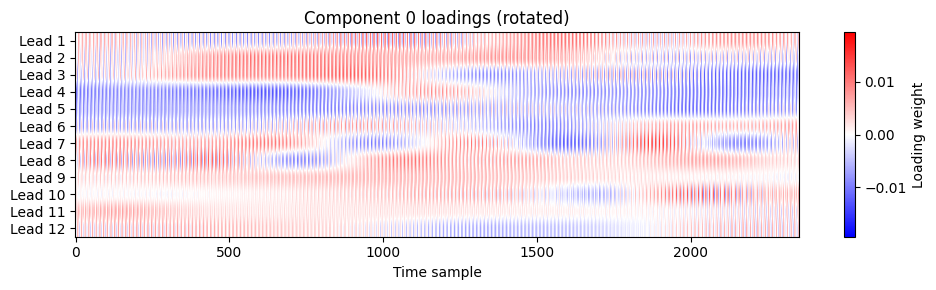

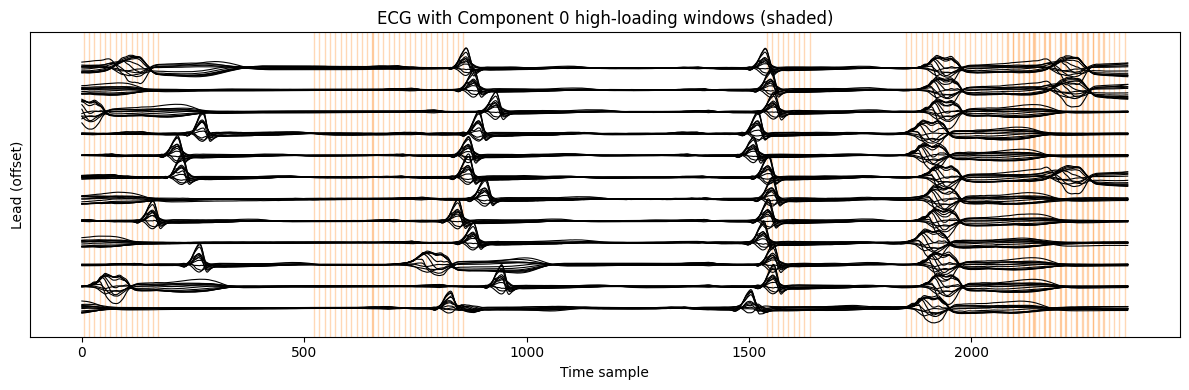

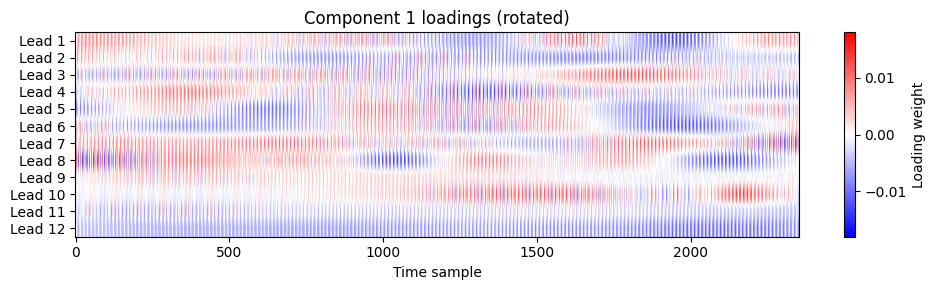

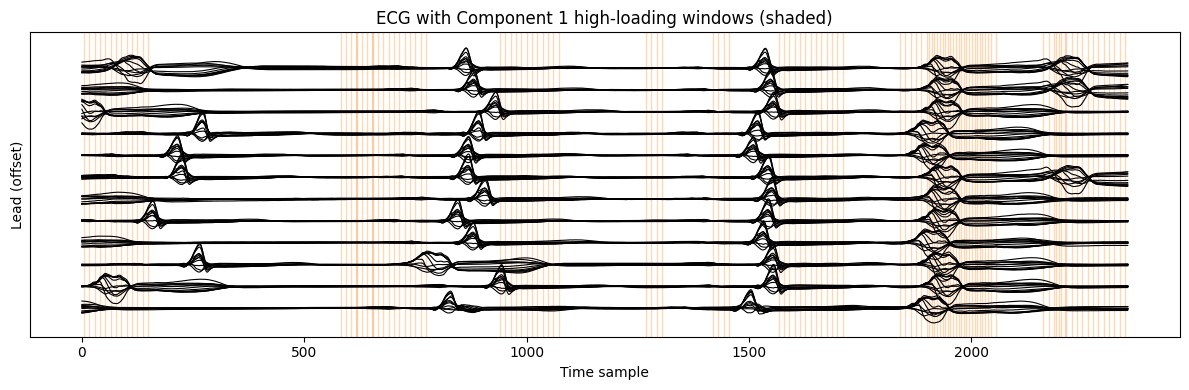

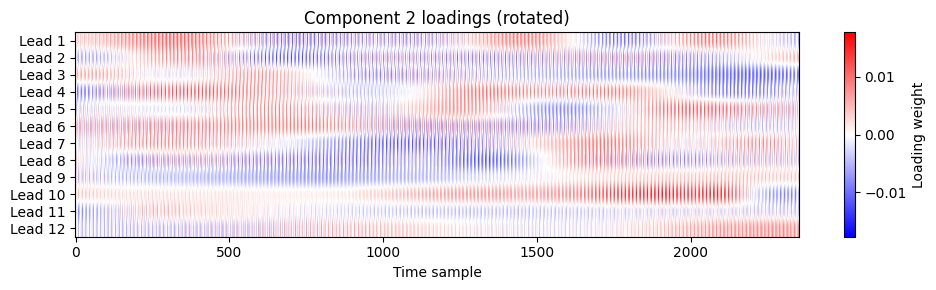

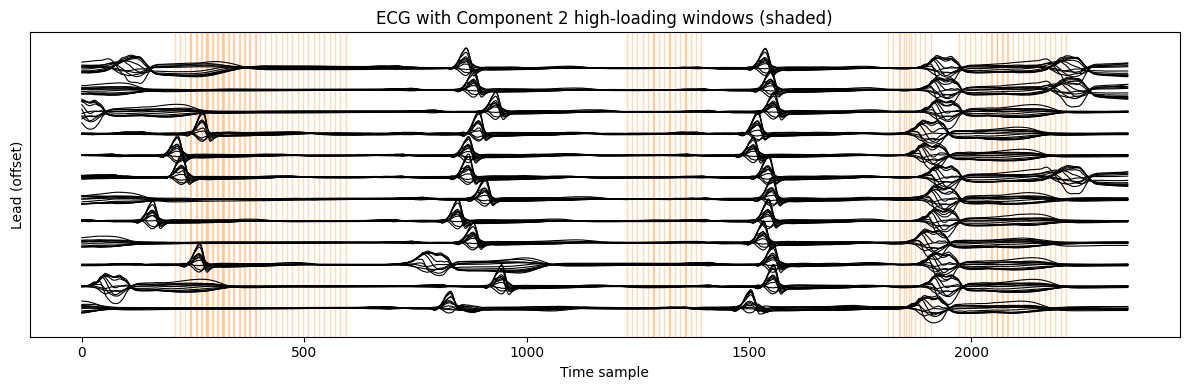

In [ ]:
leads, samples = 12, 2353
t = np.arange(samples)

features = [0, 1, 2]  # To inspect

for j in features:
    # ----- 1) heat-map of the component loading pattern -----
    comp = rotated_loadings[j].reshape(leads, samples)
    vmax = np.abs(comp).max()
    
    plt.figure(figsize=(10, 3))
    plt.imshow(comp, aspect='auto', cmap='bwr',
            vmin=-vmax, vmax=+vmax)
    plt.colorbar(label='Loading weight')
    plt.yticks(np.arange(leads), [f'Lead {i+1}' for i in range(leads)])
    plt.xlabel('Time sample')
    plt.title(f'Component {j} loadings (rotated)')
    plt.tight_layout()
    plt.show()
    
    # ----- 2) overlay high-loading windows on ECG trace -----
    # find time-indices where |loading| is in the top k%
    flat = np.abs(comp).mean(axis=0)   # average across leads per timepoint
    thresh = np.percentile(flat, 95)   # top 5%
    peaks = flat >= thresh
    
    plt.figure(figsize=(12,4))
    for i in range(leads):
        plt.plot(t, aligned_ecg_matrices[i] + i*2.0, 'k', linewidth=0.8)  # offset each lead
    # shade the “active” windows
    plt.fill_between(t, -1, leads*2, where=peaks,
                    color='C1', alpha=0.3, transform=plt.gca().get_xaxis_transform())
    plt.xlabel('Time sample')
    plt.ylabel('Lead (offset)')
    plt.title(f'ECG with Component {j} high-loading windows (shaded)')
    plt.yticks([])
    plt.tight_layout()
    plt.show()

In [ ]:
print("Flattening ECGs dimensions:", flattened_ecgs_df.shape)
print("X rotated dimensions:", X_rotated.shape)

# Convert to higher precision for variance calculation (otherwise it overflows)
X_rotated_float32 = X_rotated.astype(np.float32)

# Calculate variance using higher precision
var_orig = np.var(flattened_ecgs_df.values, axis=0).sum()
var_rot = np.var(X_rotated_float32, axis=0).sum()
variance_ratio = var_rot / var_orig

# Print results
print("Varimax Metrics")
print("---------------------------------")
print(f"Total original variance     : {var_orig:.4f}")
print(f"Total reconstructed variance: {var_rot:.4f}")
print(f"Variance ratio (recon/orig) : {variance_ratio:.4f}")
print(f"Number of components after rotation: {rotated_loadings.shape[0]}")

Flattening ECGs dimensions: (24982, 28236)
X rotated dimensions: (24982, 200)
Varimax Metrics
---------------------------------
Total original variance     : 2433.5322
Total reconstructed variance: 2326.0801
Variance ratio (recon/orig) : 0.9558
Number of components after rotation: 200


As we can see, the learned features are quite interpretable (mapping to specific characteristics of the ECGs), and we can see how applying the rotation on the PCA hasn't changed the variance explained by the components, but has made them more interpretable.

Now that we have just 200 features that are interpretable, and where each data point is now a float16 instead of a float64, we have a good enough basis to make our classification models learn from (almost) all the original data variability, while having much more lightweight (which will allow **faster** computation) and **interpretable** data to work with.

## 5. Preparing data for training for the two tasks

### 5.1. Unified dataframe with demographic data and reduced ECGs

We have in "data" the demographic features, grouped by patient.
We have in "X_rotated" the reduced ECGs after applying the rotation. And the indices of patients is stored in "ecg_identifiers". We also have "outlier_indices" being the indices of the patients that we removed from the list of size "ecg_identifiers".

We will now set up a unified dataframe, where each row corresponds to a single patient case, basically appending to each row of "X_rotated" the demographic data from "data" for that patient, linking them by the patient identifier.

In [ ]:
def create_unified_dataframe(X_reduced, ecg_identifiers, demographic_data, outlier_indices=None):
    print(f"Creating unified dataframe from {X_reduced.shape[0]} ECGs and {len(demographic_data)} patient records...")
    
    # Filter ecg_identifiers based on outlier_indices
    if outlier_indices and len(outlier_indices) > 0:
        print(f"Removing {len(outlier_indices)} outlier indices from ecg_identifiers")
        # Create a mask of indices to keep
        keep_mask = ~np.isin(np.arange(len(ecg_identifiers)), outlier_indices)
        ecg_identifiers_filtered = ecg_identifiers.iloc[keep_mask].reset_index(drop=True)
    else:
        ecg_identifiers_filtered = ecg_identifiers.copy()
    
    # Verify the lengths match after filtering
    if len(ecg_identifiers_filtered) != len(X_reduced):
        print(f"ERROR: Length mismatch between filtered identifiers ({len(ecg_identifiers_filtered)}) and features ({len(X_reduced)})")
        
        # Try to adjust by taking the first len(X_reduced) rows from identifiers
        if len(ecg_identifiers_filtered) > len(X_reduced):
            print(f"Truncating ecg_identifiers to match X_reduced length")
            ecg_identifiers_filtered = ecg_identifiers_filtered.iloc[:len(X_reduced)].reset_index(drop=True)
        else:
            print(f"Truncating X_reduced to match ecg_identifiers length")
            X_reduced = X_reduced[:len(ecg_identifiers_filtered)]
    
    # Create dataframe with ECG features
    ecg_columns = [f'ecg_feature_{i+1}' for i in range(X_reduced.shape[1])]
    ecg_df = pd.DataFrame(X_reduced, columns=ecg_columns)
    
    # Add ECG identifiers
    unified_df = pd.concat([ecg_identifiers_filtered.reset_index(drop=True), ecg_df], axis=1)
    
    # Track statistics for reporting
    patients_with_ecgs = set(unified_df['patient'])
    
    # Create a copy to avoid modifying the original demographic data
    demo_data = demographic_data.copy()
    
    # Filter demographic data to only include patients with valid ECGs
    demo_data_filtered = demo_data.loc[demo_data.index.isin(patients_with_ecgs)].copy()
    
    # Merge demographic data based on patient ID
    result = pd.merge(
        unified_df, 
        demo_data_filtered,
        left_on='patient', 
        right_index=True,
        how='left'  # Keep all ECGs even if demographic data is missing
    )
    
    # Calculate statistics
    patients_in_result = result['patient'].nunique()
    ecgs_in_result = len(result)
    missing_demo = result['Age'].isna().sum()  # Use Age as a proxy for checking missing demographic data
    
    print(f"Unified dataframe statistics:")
    print(f"- Combined {ecgs_in_result} ECGs from {patients_in_result} patients")
    print(f"- ECGs per patient: {ecgs_in_result / patients_in_result:.1f} (avg)")
    
    if missing_demo > 0:
        print(f"- Warning: {missing_demo} ECGs ({missing_demo/ecgs_in_result:.1%}) have missing demographic data")
    
    # Verify that all columns from both sources are present
    expected_columns = ecg_columns + list(demo_data.columns) + list(ecg_identifiers_filtered.columns)
    missing_cols = [col for col in expected_columns if col not in result.columns]
    if missing_cols:
        print(f"- Warning: Missing columns in the result: {missing_cols}")
    
    return result


unified_df = create_unified_dataframe(
    X_reduced=X_rotated,
    ecg_identifiers=ecg_identifiers,
    demographic_data=data,
    outlier_indices=outlier_indices
)

Creating unified dataframe from 24982 ECGs and 173 patient records...
Removing 112 outlier indices from ecg_identifiers
Unified dataframe statistics:
- Combined 24982 ECGs from 169 patients
- ECGs per patient: 147.8 (avg)


In [ ]:
display(unified_df.head())

patient position anatomical_region  ecg_feature_1  ecg_feature_2  \
0    P245     P157              2-RV      -4.867188       2.248047   
1    P245      P31              2-RV       0.821777      -0.071472   
2    P245      P63              2-RV      -1.861328       0.475830   
3    P245     P144              2-RV      -5.324219       1.625977   
4    P245     P107              2-RV      -1.531250      -3.248047   

   ecg_feature_3  ecg_feature_4  ecg_feature_5  ecg_feature_6  ecg_feature_7  \
0      -0.601562      -1.562500      -0.016724       1.792969      -1.848633   
1      -3.908203      -5.042969      -4.722656       4.761719      -1.175781   
2      -3.462891      -3.423828      -3.312500       5.402344      -3.119141   
3       0.398438      -0.034119       1.633789       2.062500      -0.974609   
4      -2.683594      -2.726562      -1.030273       6.847656       2.416016   

   ...  COPD  Sleep_apnea  Outcome_B     Outcome_C  PVC_transition_V1  \
0  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
1  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
2  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
3  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
4  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   

   PVC_transition_V2  PVC_transition_V3  PVC_transition_V4  PVC_transition_V5  \
0                  0                  1                  0                  0   
1                  0                  1                  0                  0   
2                  0                  1                  0                  0   
3                  0                  1                  0                  0   
4                  0                  1                  0                  0   

   PVC_transition_V6  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 222 columns]

In [ ]:
# Drop the 'patient', 'position' and 'anatomical_region' columns
unified_df = unified_df.drop(columns=['position', 'anatomical_region'])

In [ ]:
display(unified_df.head())
print(f"Unified DataFrame shape after dropping columns: {unified_df.shape}")

patient  ecg_feature_1  ecg_feature_2  ecg_feature_3  ecg_feature_4  \
0    P245      -4.867188       2.248047      -0.601562      -1.562500   
1    P245       0.821777      -0.071472      -3.908203      -5.042969   
2    P245      -1.861328       0.475830      -3.462891      -3.423828   
3    P245      -5.324219       1.625977       0.398438      -0.034119   
4    P245      -1.531250      -3.248047      -2.683594      -2.726562   

   ecg_feature_5  ecg_feature_6  ecg_feature_7  ecg_feature_8  ecg_feature_9  \
0      -0.016724       1.792969      -1.848633      -1.206055      -1.932617   
1      -4.722656       4.761719      -1.175781       2.169922      -1.822266   
2      -3.312500       5.402344      -3.119141       5.328125       0.585938   
3       1.633789       2.062500      -0.974609       2.398438      -2.066406   
4      -1.030273       6.847656       2.416016       5.042969      -1.462891   

   ...  COPD  Sleep_apnea  Outcome_B     Outcome_C  PVC_transition_V1  \
0  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
1  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
2  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
3  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   
4  ...   0.0          0.0       RVOT  RVOTFREEWALL                  0   

   PVC_transition_V2  PVC_transition_V3  PVC_transition_V4  PVC_transition_V5  \
0                  0                  1                  0                  0   
1                  0                  1                  0                  0   
2                  0                  1                  0                  0   
3                  0                  1                  0                  0   
4                  0                  1                  0                  0   

   PVC_transition_V6  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  

[5 rows x 220 columns]

Unified DataFrame shape after dropping columns: (24982, 220)


### 5.2. Input dataframes for Model B and Model C

For Model B, we will use the 'Outcome_B' column as the target variable, without any additional filtering.

For Model C, we will use the 'Outcome_C' column as the target variable, but we will filter out all rows whose 'Outcome_C' value is neither 'RCC' nor 'COMMISURE', as these are the only sub-regions we want to classify.

In [ ]:
def prepare_task_data(unified_df):
    print("Preparing data for Model B (LVOT vs RVOT classification)...")
    
    # Identify feature columns (ECG features + demographic features)
    feature_cols = [col for col in unified_df.columns 
                   if col not in ['patient', 'Outcome_B', 'Outcome_C']]
    
    # Model B: All samples, predicting Outcome_B
    X_taskB = unified_df[feature_cols].copy()
    y_taskB = unified_df['Outcome_B'].copy()
    patients_taskB = unified_df['patient'].copy()
    
    # Report Model B dataset statistics
    print(f"Model B dataset: {len(X_taskB)} samples from {patients_taskB.nunique()} patients")
    print(f"Class distribution: {y_taskB.value_counts().to_dict()}")
    
    # Model C: Filter for RCC vs COMMISSURE subregions
    print("\nPreparing data for Model C (RCC vs COMMISURE classification)...")
    task_c_filter = unified_df['Outcome_C'].isin(['RCC', 'COMMISURE'])
    X_taskC = unified_df.loc[task_c_filter, feature_cols].copy()
    y_taskC = unified_df.loc[task_c_filter, 'Outcome_C'].copy()
    patients_taskC = unified_df.loc[task_c_filter, 'patient'].copy()
    
    # Report Model C dataset statistics
    print(f"Model C dataset: {len(X_taskC)} samples from {patients_taskC.nunique()} patients")
    print(f"Class distribution: {y_taskC.value_counts().to_dict()}")
    
    return X_taskB, y_taskB, patients_taskB, X_taskC, y_taskC, patients_taskC


X_taskB, y_taskB, patients_taskB, X_taskC, y_taskC, patients_taskC = prepare_task_data(unified_df)

Preparing data for Task B (LVOT vs RVOT classification)...
Task B dataset: 24982 samples from 169 patients
Class distribution: {'RVOT': 19432, 'LVOT': 5550}

Preparing data for Task C (RCC vs COMMISURE classification)...
Task C dataset: 1835 samples from 22 patients
Class distribution: {'COMMISURE': 1211, 'RCC': 624}


In [ ]:
save_task_datasets = True

if save_task_datasets:
    datasets = {
        'X_taskB': X_taskB,
        'y_taskB': y_taskB,
        'patients_taskB': patients_taskB,
        'X_taskC': X_taskC,
        'y_taskC': y_taskC,
        'patients_taskC': patients_taskC
    }

    for name, data in datasets.items():
        save_path = f'outputs/{name}.pkl'
        data.to_pickle(save_path)
        print(f"Saved {name} to {save_path}")
        
    # Print file sizes
    for name, data in datasets.items():
        save_path = f'outputs/{name}.pkl'
        size = os.path.getsize(save_path) / (1024 * 1024)  # Convert to MB
        print(f"{name} size: {size:.2f} MB")
    

### 5.3. Stratified, patient-aware splits of input dataframes

Now we have stored the dataframes that we will use from now on to train the classification models for both tasks. We will now perform a split of the data into training, validation, and test sets, to later train the models and evaluate their performance.

In our specific case, it is very important to perform patient-aware splits, so that the same patient is not present in both training and val/test sets. This is because we want to evaluate the models on unseen patients, to ensure that they generalize well to new data.

We originally started with this function to perform the split, which randomly splits the data into training, validation, and test sets. We obtained some models with good enough performance out of it, due to more computation hours put into the hyperparameter tuning:

In [ ]:
from sklearn.model_selection import GroupShuffleSplit

def patient_aware_train_val_test_split(
    X, y, patients,
    test_size: float = 0.2,
    val_size: float  = 0.2,
    random_state: int = 42
):
    # split off test set
    splitter1 = GroupShuffleSplit(
        n_splits=1, test_size=test_size, random_state=random_state
    )
    trainval_idx, test_idx = next(splitter1.split(X, y, groups=patients))
    
    X_trainval, X_test = X.iloc[trainval_idx],    X.iloc[test_idx]
    y_trainval, y_test = y.iloc[trainval_idx],    y.iloc[test_idx]
    p_trainval, p_test = patients.iloc[trainval_idx], patients.iloc[test_idx]
    
    # split trainval into train + val
    #    val_size is fraction of trainval for validation
    rel_val_size = val_size / (1.0 - test_size)
    splitter2 = GroupShuffleSplit(
        n_splits=1, test_size=rel_val_size, random_state=random_state
    )
    train_idx, val_idx = next(splitter2.split(
        X_trainval, y_trainval, groups=p_trainval
    ))
    
    X_train = X_trainval.iloc[train_idx]
    y_train = y_trainval.iloc[train_idx]
    p_train = p_trainval.iloc[train_idx]
    
    X_val   = X_trainval.iloc[val_idx]
    y_val   = y_trainval.iloc[val_idx]
    p_val   = p_trainval.iloc[val_idx]
    
    # checks no patient overlap
    assert set(p_train).isdisjoint(set(p_val)), "Train/val patient overlap!"
    assert set(p_train).isdisjoint(set(p_test)), "Train/test patient overlap!"
    assert set(p_val).isdisjoint(set(p_test)),   "Val/test patient overlap!"
    
    print(f"Train: {len(X_train)} samples, {p_train.nunique()} patients")
    print(f"Val:   {len(X_val)} samples,   {p_val.nunique()} patients")
    print(f"Test:  {len(X_test)} samples, {p_test.nunique()} patients\n")
    print(f"Train class dist: {y_train.value_counts().to_dict()}")
    print(f"Val   class dist: {y_val.value_counts().to_dict()}")
    print(f"Test  class dist: {y_test.value_counts().to_dict()}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, p_train, p_val, p_test

In [ ]:
# Originally, for model B:
""" X_train_B, X_val_B, X_test_B, \
y_train_B, y_val_B, y_test_B, \
patients_train_B, patients_val_B, patients_test_B = patient_aware_train_val_test_split(
    X_taskB, y_taskB, patients_taskB,
    test_size=0.2,    # 20% test
    val_size=0.2,     # 20% of remaining
    random_state=42
) """

Finding the need in Model C, we improved our split function to use stratified sampling, so that the distribution of the target variable is preserved in each split. This is especially important for unbalanced datasets (like our two task's datasets, especially on the second task), where some classes have much fewer samples than others:

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import pairwise_distances
import numpy as np
import pandas as pd


def stratified_group_train_val_test_split(
    X: pd.DataFrame,
    y: pd.Series,
    patients: pd.Series,
    test_size: float = 0.20,
    val_size: float  = 0.20,
    random_state: int = 42,
    n_draws: int = 50,               # how many candidate splits to try
):
    """
    • No patient appears in more than one split.
    • Overall fractions ≈ 60 / 20 / 20 at the *patient* level.
    • Among the candidate splits, pick the one where the *sample-level*
      class distribution of VAL is closest to that of TEST
      (measured by L1 distance).
    """

    # ── 0. one row per patient (with its label) ────────────────────────────────
    df_pat = (pd.DataFrame({"patient": patients.values, "label": y.values})
              .drop_duplicates(subset="patient")
              .reset_index(drop=True))
    pat_ids, pat_labels = df_pat["patient"].values, df_pat["label"].values

    # helper to slice by a patient subset
    def _slice(patient_subset):
        mask = patients.isin(patient_subset)
        return y.loc[mask]

    rng_master = np.random.RandomState(random_state)

    best_split = None
    best_distance = np.inf

    for draw in range(n_draws):
        rng = np.random.RandomState(rng_master.randint(0, 1_000_000))

        # 1) TrainVal vs Test at patient level
        sss_test = StratifiedShuffleSplit(
            n_splits=1, test_size=test_size, random_state=rng.randint(0, 1_000_000)
        )
        trainval_idx, test_idx = next(sss_test.split(pat_ids, pat_labels))
        pat_trainval = pat_ids[trainval_idx]
        pat_test     = pat_ids[test_idx]

        # 2) Train vs Val at patient level
        rel_val = val_size / (1.0 - test_size)
        sss_val = StratifiedShuffleSplit(
            n_splits=1, test_size=rel_val, random_state=rng.randint(0, 1_000_000)
        )
        # restrict to trainval patients
        mask_tv = df_pat["patient"].isin(pat_trainval)
        sub_ids, sub_labels = df_pat.loc[mask_tv, "patient"].values, df_pat.loc[mask_tv, "label"].values
        train_idx, val_idx = next(sss_val.split(sub_ids, sub_labels))
        pat_train = sub_ids[train_idx]
        pat_val   = sub_ids[val_idx]

        # 3) Compare sample-level class distributions between VAL and TEST
        y_val_dist  = _slice(pat_val ).value_counts(normalize=True, sort=False)
        y_test_dist = _slice(pat_test).value_counts(normalize=True, sort=False)

        # align the two series (missing classes → 0)
        y_val_dist  = y_val_dist.reindex(y.unique(), fill_value=0.0)
        y_test_dist = y_test_dist.reindex(y.unique(), fill_value=0.0)

        # L1 (Manhattan) distance between the two distributions
        dist = np.abs(y_val_dist.values - y_test_dist.values).sum()

        if dist < best_distance:
            best_distance = dist
            best_split    = (pat_train, pat_val, pat_test)

    # ── 4. Build final masks with the *best* patient split ─────────────────────
    pat_train, pat_val, pat_test = best_split
    train_mask = patients.isin(pat_train)
    val_mask   = patients.isin(pat_val)
    test_mask  = patients.isin(pat_test)

    X_train = X.loc[train_mask].reset_index(drop=True)
    y_train = y.loc[train_mask].reset_index(drop=True)
    p_train = patients.loc[train_mask].reset_index(drop=True)

    X_val   = X.loc[val_mask].reset_index(drop=True)
    y_val   = y.loc[val_mask].reset_index(drop=True)
    p_val   = patients.loc[val_mask].reset_index(drop=True)

    X_test  = X.loc[test_mask].reset_index(drop=True)
    y_test  = y.loc[test_mask].reset_index(drop=True)
    p_test  = patients.loc[test_mask].reset_index(drop=True)

    # ── 5. Diagnostics ─────────────────────────────────────────────────────────
    print(f"Best-of-{n_draws} patient splits selected (|val-test|₁ = {best_distance:.3f})")
    print(f"Train: {len(X_train)} samples, {p_train.nunique()} patients")
    print(f"Val:   {len(X_val)} samples,   {p_val.nunique()} patients")
    print(f"Test:  {len(X_test)} samples, {p_test.nunique()} patients\n")
    print(f"Train class dist: {y_train.value_counts().to_dict()}")
    print(f"Val   class dist: {y_val.value_counts().to_dict()}")
    print(f"Test  class dist: {y_test.value_counts().to_dict()}\n")

    return X_train, X_val, X_test, y_train, y_val, y_test, p_train, p_val, p_test

In [27]:
# Use this cell in order to load the saved datasets
X_taskB          = pd.read_pickle('outputs/X_taskB.pkl')
y_taskB          = pd.read_pickle('outputs/y_taskB.pkl')
patients_taskB   = pd.read_pickle('outputs/patients_taskB.pkl')
X_taskC          = pd.read_pickle('outputs/X_taskC.pkl')
y_taskC          = pd.read_pickle('outputs/y_taskC.pkl')
patients_taskC   = pd.read_pickle('outputs/patients_taskC.pkl')

print(f"X_taskB shape: {X_taskB.shape}")
print(f"y_taskB shape: {y_taskB.shape}")
print(f"patients_taskB shape: {patients_taskB.shape}\n")
print(f"X_taskC shape: {X_taskC.shape}")
print(f"y_taskC shape: {y_taskC.shape}")
print(f"patients_taskC shape: {patients_taskC.shape}\n")
  
# ----------------------------------------------------------------------
#  Part 1  – Model B
# ----------------------------------------------------------------------
X_train_B, X_val_B, X_test_B, \
y_train_B, y_val_B, y_test_B, \
patients_train_B, patients_val_B, patients_test_B = \
    stratified_group_train_val_test_split(
        X_taskB, y_taskB, patients_taskB,
        test_size   = 0.20,   # 20 % of the patients → test
        val_size    = 0.20,   # 20 % (of ALL patients) → val
        random_state= 42,
        n_draws     = 50      # try 50 candidate splits, keep the best
    )

# ----------------------------------------------------------------------
#  Part 2  – Model C
# ----------------------------------------------------------------------
X_train_C, X_val_C, X_test_C, \
y_train_C, y_val_C, y_test_C, \
patients_train_C, patients_val_C, patients_test_C = \
    stratified_group_train_val_test_split(
        X_taskC, y_taskC, patients_taskC,
        test_size   = 0.20,
        val_size    = 0.20,
        random_state= 42,
        n_draws     = 50
    )

X_taskB shape: (24982, 217)
y_taskB shape: (24982,)
patients_taskB shape: (24982,)

X_taskC shape: (1835, 217)
y_taskC shape: (1835,)
patients_taskC shape: (1835,)

Best-of-50 patient splits selected (|val-test|₁ = 0.009)
Train: 15285 samples, 101 patients
Val:   4787 samples,   34 patients
Test:  4910 samples, 34 patients

Train class dist: {'RVOT': 11941, 'LVOT': 3344}
Val   class dist: {'RVOT': 3709, 'LVOT': 1078}
Test  class dist: {'RVOT': 3782, 'LVOT': 1128}

Best-of-50 patient splits selected (|val-test|₁ = 0.007)
Train: 803 samples, 12 patients
Val:   636 samples,   5 patients
Test:  396 samples, 5 patients

Train class dist: {'COMMISURE': 492, 'RCC': 311}
Val   class dist: {'COMMISURE': 444, 'RCC': 192}
Test  class dist: {'COMMISURE': 275, 'RCC': 121}



In [29]:
# Save all splits in files (so that we can train models later without recomputing splits)
save_data_splits = False

if save_data_splits: 
    split_data = {
        'X_train_B': X_train_B, 'X_val_B': X_val_B, 'X_test_B': X_test_B,
        'y_train_B': y_train_B, 'y_val_B': y_val_B, 'y_test_B': y_test_B,
        'patients_train_B': patients_train_B, 'patients_val_B': patients_val_B, 'patients_test_B': patients_test_B,
        'X_train_C': X_train_C, 'X_val_C': X_val_C, 'X_test_C': X_test_C,
        'y_train_C': y_train_C, 'y_val_C': y_val_C, 'y_test_C': y_test_C,
        'patients_train_C': patients_train_C, 'patients_val_C': patients_val_C, 'patients_test_C': patients_test_C,
    }

    for name, df in split_data.items():
        path = f'outputs/{name}.pkl'
        df.to_pickle(path)
        print(f"Saved {name} to {path}")

In [124]:
# Use this cell in order to load the saved splits
X_train_B          = pd.read_pickle('outputs/X_train_B.pkl')
X_val_B            = pd.read_pickle('outputs/X_val_B.pkl')
X_test_B           = pd.read_pickle('outputs/X_test_B.pkl')
y_train_B          = pd.read_pickle('outputs/y_train_B.pkl')
y_val_B            = pd.read_pickle('outputs/y_val_B.pkl')
y_test_B           = pd.read_pickle('outputs/y_test_B.pkl')

X_train_C          = pd.read_pickle('outputs/X_train_C.pkl')
X_val_C            = pd.read_pickle('outputs/X_val_C.pkl')
X_test_C           = pd.read_pickle('outputs/X_test_C.pkl')
y_train_C          = pd.read_pickle('outputs/y_train_C.pkl')
y_val_C            = pd.read_pickle('outputs/y_val_C.pkl')
y_test_C           = pd.read_pickle('outputs/y_test_C.pkl')

# Optionally:
patients_train_B   = pd.read_pickle('outputs/patients_train_B.pkl')
patients_val_B     = pd.read_pickle('outputs/patients_val_B.pkl')
patients_test_B    = pd.read_pickle('outputs/patients_test_B.pkl')
patients_train_C   = pd.read_pickle('outputs/patients_train_C.pkl')
patients_val_C     = pd.read_pickle('outputs/patients_val_C.pkl')
patients_test_C    = pd.read_pickle('outputs/patients_test_C.pkl')


### 5.4. Original training approach and run

Once we have the data to train on ready, we decide how we will approach training.

We initially wanted to train "all" model families that we could use for the tasks (fulfilling our constraints of interpretability and fast inference), using hyperparameter tuning to find the best-performing model for each task across multiple model families. Our training run logic was based on the following:

```python
from sklearn.linear_model    import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes     import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid

models = {
    "logreg": LogisticRegression(solver="saga", max_iter=5_000),
    "lda":    LinearDiscriminantAnalysis(),
    "gnb":    GaussianNB(),
    "mnb":    MultinomialNB(),
    "bnb":    BernoulliNB(),
    "dt":     DecisionTreeClassifier(),
    "rf":     RandomForestClassifier(),
    "knn":    KNeighborsClassifier(),
    "rnn":    RadiusNeighborsClassifier(),
    "nc":     NearestCentroid(),
} 

# We define the parameter grids for each model family, to be used in the grid search during hyperparameter tuning
param_grids = {
    "logreg": {
        "penalty": ["l1","l2","elasticnet"],
        "C":       [0.01, 0.1, 1, 10],
        "l1_ratio":[0.0, 0.5, 1.0],  
    },
    "lda": {
        "solver":   ["svd","lsqr","eigen"],
        "shrinkage":[None, 0.1, 0.5, 1.0],
    },
    "gnb": {"var_smoothing": np.logspace(-9, -6, 5)},
    "mnb": {"alpha": [0.1, 0.5, 1.0]},
    "bnb": {"alpha": [0.1, 0.5, 1.0]},
    "dt": {
        "max_depth":        [3,5,10,None],
        "min_samples_leaf": [1,5,10]
    },
    "rf": {
        "n_estimators": [50,100,200],
        "max_depth":    [5,10,None],
        "max_features": ["sqrt", "log2", None],
    },
    "rulefit": {
        "max_rules":        [10, 20, 50],
        "tree_size":        [3, 5, 7]
    },
    "knn": {
        "n_neighbors": [3,5,10],
        "weights":     ["uniform","distance"],
        "p":           [1,2]
    },
    "rnn": {
        "radius":       [0.5, 1.0, 2.0],                 
        "outlier_label":[ "most_frequent", 0, 1 ],     
        "weights":      [ "uniform", "distance" ]       
    },
    "nc":  {"shrink_threshold": [None, 0.0, 0.1]}
}
```

We then run a loop that performed a `GridSearchCV` for each model family, using the parameter grid defined above, storing the best found model for each model family.

However, we found that this approach was not efficient enough because:
- Some model families were taking too long to be trained, so running searches for them was not desirable.
- Some model families performed consistently better than others, just because of their more advanced learning capabilities, so we could just focus on these families and not waste time on the others. The clearest example for this is how a single Decision Tree model is easily outperformed by a Random Forest model (aggregating multiple Decision Trees); and that a Random Forest model is easily outperformed by a Gradient Boosting model (aggregating multiple trees, where each tree is *optimized* to compensate for the errors of the previous ones).

After a few model iterations, we decided to **focus entirely on XGBoost**, as it is:
- Very interpretable, as it provides feature importances and is just a set of decision trees.
- Very fast to train thanks to the iterative gradient approach, which trains a model for our data in a few seconds. This allowed us to run hours of hyperparameter tuning iterations, equivalent to training thousands of different models, to find the best-performing model for each task.
- Very fast to infer, since it is just a set of decision trees that can be evaluated in parallel (not even heavy matrix multiplications).
- It was the best-performing model family across all tasks on our initial runs.

These were among the "best" models we got for other simpler model families, showing that they were not performing as desired:

![Model Comparison](./outputs/other_model_families_confusion_matrices.png)



### 5.5. Unified training run function for XGBoost models

After this decision was done, and given that we had a very similar classification task for both Model B and Model C (as well as, purposefully, the same processing pipeline for the input data), we decided to focus on creating a single "training run" function that would perform a grid search for the best XGBoost model for each task.

The first step in our “training run” is to identify the most important predictors via SHAP analysis: we temporarily oversample the minority class using SMOTE, train a lightweight XGBoost on that balanced data, and then rank features by their mean absolute SHAP values (using the function that allows us to find top components). In practice, this lets us focus downstream training exclusively on the top‐k features that drive model performance, which improves both speed and robustness:

In [7]:
def select_top_shap_features(
    X_train: pd.DataFrame,
    y_train_num: np.ndarray,
    n_top: int = 50,
    smote_ratio: float = 0.3
):
    # Determine class counts
    classes, counts = np.unique(y_train_num, return_counts=True)
    maj_count = counts.max()
    min_count = counts.min()
    desired_min = int(maj_count * smote_ratio)

    if min_count < desired_min:
        sampling_strategy = {classes[np.argmin(counts)]: desired_min}
    else:
        sampling_strategy = "auto"

    sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
    X_tr_over, y_tr_over = sm.fit_resample(X_train, y_train_num)

    # Train a lightweight XGBoost from which to determine feature importance
    baseline = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="aucpr",
        random_state=42
    )
    baseline.fit(X_tr_over, y_tr_over, verbose=False)

    # Compute SHAP on the oversampled data
    explainer = shap.TreeExplainer(baseline)
    shap_vals = explainer.shap_values(X_tr_over)
    mean_abs_shap = np.abs(shap_vals).mean(axis=0)
    feat_importance = pd.Series(mean_abs_shap, index=X_train.columns)
    top_features = feat_importance.sort_values(ascending=False).head(n_top).index.tolist()
    return top_features

After we settle on a concise feature list, we start the grid search across our hyperparameter space, which we define before each training run. We use a randomized search over the hyperparameters, sampling from a predefined grid of values for each hyperparameter. This allows us to explore a wide range of configurations without exhaustively testing every possible combination (which we considered doing on our initial approaches), which would be computationally expensive. 

Each iteration starts by taking the sampled hyperparameter set and training an XGBoost model on the fixed training split. It breaks the training data (X_train) into several disjoint “folds” so that no patient appears in more than one fold. For each fold, it treats that fold as a temporary validation set and the remaining four folds as a training set. After training, it computes predicted probabilities on the validation fold, sweeps thresholds from 0.01 to 0.99, and picks whichever threshold yields the highest macro-F1 on that validation data. It records that best macro-F1 for the fold, then repeats the process for all five folds. It then returns the average of those five best-fold macro-F1 scores as the cross-validation estimate of how well the given hyperparameter set will generalize to unseen patients.

We record that **best validation macro-F1** as the single score for this hyperparameter configuration. By choosing macro-F1 (rather than accuracy or AUC) we are explicitly balancing precision and recall for both classes, avoiding scenarios where:
- A model gets high accuracy by simply predicting the majority class
- A model achieves high AUC but performs poorly in terms of accuracy
- A model gets high precision/recall/accuracy, but gets low AUC due to learned behaviour of not being able to predict confidently, or gets low performance on unseen data (explained by overfitting)
(all these occurrences were observed in our initial runs).


In [3]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GroupKFold

# ————————————————————————————————————————————————
# 3) CV Macro‐F1 with GroupKFold + SMOTE in Each Fold
# 3) CV Macro‐F1 with GroupKFold + SMOTE in Each Fold (skip early stopping when val is single‐class)
def cv_macro_f1_grouped_oversample(
    params,
    X: pd.DataFrame,
    y_num: np.ndarray,
    groups: pd.Series,
    smote_ratio: float = 0.3,
    n_splits: int = 5
):
    """
    GroupKFold: no patient leaks between train/val in any fold.
    Within each fold:
      - Possibly SMOTE‐oversample the train portion to smote_ratio of majority.
      - Train XGB(**params). If val has both classes, use eval_set for early stopping; otherwise skip it.
      - Predict on val, sweep thresholds in [0.01,0.99] for macro-F1.
      - Return mean of each fold’s best macro-F1.
    """
    gkf = GroupKFold(n_splits=n_splits)
    fold_scores = []
    thresh_candidates = np.arange(0.01, 1.00, 0.01)

    for tr_idx, val_idx in gkf.split(X, y_num, groups=groups):
        X_tr_f,  X_val_f  = X.iloc[tr_idx],  X.iloc[val_idx]
        y_tr_f,  y_val_f  = y_num[tr_idx],   y_num[val_idx]

        # Determine SMOTE strategy for this fold
        classes, counts = np.unique(y_tr_f, return_counts=True)
        maj_count = counts.max()
        min_count = counts.min()
        desired_min = int(maj_count * smote_ratio)

        if min_count < desired_min:
            sampling_strategy = {classes[np.argmin(counts)]: desired_min}
        else:
            sampling_strategy = "auto"

        sm = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
        X_tr_over, y_tr_over = sm.fit_resample(X_tr_f, y_tr_f)
        sw_tr_over = compute_sample_weight("balanced", y_tr_over)

        # If validation has both classes, keep early stopping; else remove it
        if len(np.unique(y_val_f)) > 1:
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_tr_over,
                y_tr_over,
                sample_weight = sw_tr_over,
                eval_set = [(X_val_f, y_val_f)],
                sample_weight_eval_set = [compute_sample_weight("balanced", y_val_f)],
                verbose=False
            )
        else:
            # Remove early_stopping_rounds from params before fitting
            params_no_es = {k: v for k, v in params.items() if k != "early_stopping_rounds"}
            model = xgb.XGBClassifier(**params_no_es)
            model.fit(
                X_tr_over,
                y_tr_over,
                sample_weight = sw_tr_over,
                verbose=False
            )

        proba_val_f = model.predict_proba(X_val_f)[:, 1]

        best_fold_f1 = 0.0
        for t in thresh_candidates:
            preds_t = (proba_val_f >= t).astype(int)
            fold_f1 = f1_score(y_val_f, preds_t, average='macro')
            if fold_f1 > best_fold_f1:
                best_fold_f1 = fold_f1

        fold_scores.append(best_fold_f1)

    return np.mean(fold_scores)

Finally, we evaluate that fully trained model. In a way that resembles the initial cross-validation, we take the best hyperparameter configuration and train a final XGBoost model on the entire training set. We then compute a threshold sweep (from 0.01 to 0.99) on the *validation* set, and select the threshold that maximizes macro-F1 on that *validation* set. This threshold is then applied to the *test* set, where we compute the final macro-F1 score and relevant statistics.
If using this threshold (computed from the validation set) on the test set leads to good performance, it is an indication that the model generalizes well to unseen data.

At each iteration, we record both cross‐validation and test metrics in a persistent history file, updating whenever a new best configuration emerges so that we can leave it running for long periods of time without losing progress. We also record the best hyperparameter configuration for each task, so that we can later use it as the baseline for further hyperparameter tuning.

In [21]:
import json, os, time, pickle, random, joblib
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight


def random_search_xgb(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    patients_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    patients_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    patients_test: pd.Series,
    param_space,
    results_path: str,
    best_model_bin: str,
    shap_top_k: int = 50,
    n_splits: int = 5,
    iterations: int = 1000,
    smote_ratio: float = 0.0,
):
    """
    Random-search XGBoost with:
      ⓐ per-fold SMOTE (only if smote_ratio > 0),
      ⓑ Platt-sigmoid calibration on val set,
      ⓒ threshold sweep on calibrated scores,
      ⓓ calibrated test.
    """

    # ── 1. SHAP feature selection (unchanged) ───────────────────────────────────
    le_shap = LabelEncoder().fit(y_train)
    y_train_nums = le_shap.transform(y_train)

    classes, counts = np.unique(y_train_nums, return_counts=True)
    maj_count, min_count = counts.max(), counts.min()
    desired_min = int(maj_count * smote_ratio) if smote_ratio else None

    if smote_ratio and min_count < desired_min:
        # Use keyword argument `sampling_strategy=` instead of positional
        sm = SMOTE(sampling_strategy={classes[np.argmin(counts)]: desired_min},
                   random_state=42)
        X_shap, y_shap = sm.fit_resample(X_train, y_train_nums)
    else:
        X_shap, y_shap = X_train, y_train_nums

    print(f"Selecting top {shap_top_k} features by SHAP")
    top_features = select_top_shap_features(X_shap, y_shap, n_top=shap_top_k)
    print("Top SHAP features:", top_features, "\n")

    # Keep only the top features for train/val/test
    X_train = X_train[top_features].reset_index(drop=True)
    X_val   = X_val[top_features].reset_index(drop=True)
    X_test  = X_test[top_features].reset_index(drop=True)

    # ── 2. Encode labels once ───────────────────────────────────────────────────
    le       = LabelEncoder().fit(y_train)
    y_tr     = le.transform(y_train.reset_index(drop=True))
    y_vale   = le.transform(y_val.reset_index(drop=True))
    y_te     = le.transform(y_test.reset_index(drop=True))
    sw_val   = compute_sample_weight("balanced", y_vale)

    # ── 3. Load / init search history ───────────────────────────────────────────
    if os.path.exists(results_path):
        history = pickle.load(open(results_path, "rb"))
    else:
        history = {
            "tried_params": {},
            "best": {
                "params": None,
                "f1_val": 0.0,
                "threshold": 0.5,
                "f1_val_thresh": 0.0,
                "f1_test": 0.0,
                "model_path": None,
                "calibrator_path": None,
                "meta_path": None,
            },
        }

    # ── 4. Random-search main loop ──────────────────────────────────────────────
    try:
        for iteration in range(1, iterations + 1):
            # 4-A. sample hyper-parameters
            params = {
                "n_estimators": random.randint(*param_space["n_estimators"]),
                "learning_rate": random.uniform(*param_space["learning_rate"]),
                "max_depth": random.randint(*param_space["max_depth"]),
                "subsample": random.uniform(*param_space["subsample"]),
                "colsample_bytree": random.uniform(*param_space["colsample_bytree"]),
                "objective": "binary:logistic",
                "random_state": 42,
                "eval_metric": "aucpr",
                "early_stopping_rounds": 50,
            }
            for hp in ("reg_alpha", "reg_lambda", "gamma", "min_child_weight"):
                if hp in param_space:
                    params[hp] = random.uniform(*param_space[hp])

            key = json.dumps(params, sort_keys=True)
            if key in history["tried_params"]:
                continue

            # 4-B. cross-validated macro-F1 (unchanged helper)
            f1_val = cv_macro_f1_grouped_oversample(
                params,
                X_train,
                np.array(y_tr),
                patients_train,
                smote_ratio=smote_ratio,
                n_splits=n_splits,
            )

            # 4-C. SMOTE / weights for final fit on full train split
            classes, counts = np.unique(y_tr, return_counts=True)
            desired_min = int(counts.max() * smote_ratio) if smote_ratio else None
            sampling_strategy = (
                {classes[np.argmin(counts)]: desired_min}
                if (smote_ratio and counts.min() < desired_min)
                else "auto"
            )

            if smote_ratio and smote_ratio > 0:
                # ── we ARE oversampling ──
                sm_final = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
                X_fit, y_fit = sm_final.fit_resample(X_train, y_tr)
                sw_tr = None  # don’t apply class-weights when SMOTE is on
            else:
                # ── we are NOT oversampling ──
                X_fit, y_fit = X_train, y_tr
                sw_tr = compute_sample_weight("balanced", y_fit)

            # 4-D. train raw XGB on balanced/oversampled data
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_fit,
                y_fit,
                sample_weight=sw_tr,
                eval_set=[(X_val, y_vale)],
                sample_weight_eval_set=[sw_val],
                verbose=False,
            )

            # 4-E. ──── Platt-sigmoid calibration ───────────────────────────────
            calibrator = CalibratedClassifierCV(model, method="sigmoid", cv="prefit")
            calibrator.fit(X_val, y_vale)

            # 4-F. threshold sweep on calibrated validation probs
            val_probs = calibrator.predict_proba(X_val)[:, 1]
            best_thresh, best_f1_val_thresh = 0.5, 0.0
            for t in np.arange(0.01, 1.00, 0.01):
                f1_t = f1_score(y_vale, (val_probs >= t).astype(int), average="macro")
                if f1_t > best_f1_val_thresh:
                    best_f1_val_thresh, best_thresh = f1_t, t

            # 4-G. calibrated prediction on test set
            test_probs = calibrator.predict_proba(X_test)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            f1_test = f1_score(y_te, test_preds, average="macro")

            # 4-H. log trial
            history["tried_params"][key] = {
                "f1_val": f1_val,
                "threshold": best_thresh,
                "f1_val_thresh": best_f1_val_thresh,
                "f1_test": f1_test,
                "time": time.time(),
            }

            # 4-I. update best if improved
            best = history["best"]
            better_val = f1_val > best["f1_val"]
            tie_val = np.isclose(f1_val, best["f1_val"])
            better_test = f1_test > best.get("f1_test", 0.0)
            not_worse_test = f1_test >= best.get("f1_test", 0.0)

            if (better_val and not_worse_test) or (tie_val and better_test):
                os.makedirs(os.path.dirname(best_model_bin) or ".", exist_ok=True)
                model.save_model(best_model_bin)

                calib_path = Path(best_model_bin).with_suffix(".calib.pkl")
                joblib.dump(calibrator, calib_path)

                meta_path = Path(best_model_bin).with_suffix(".json")
                meta_path.write_text(json.dumps({"xgb_params": params}, indent=2))

                history["best"] = {
                    "params": params,
                    "f1_val": f1_val,
                    "threshold": best_thresh,
                    "f1_val_thresh": best_f1_val_thresh,
                    "f1_test": f1_test,
                    "model_path": best_model_bin,
                    "calibrator_path": str(calib_path),
                    "meta_path": str(meta_path),
                }

                cr = classification_report(
                    y_te,
                    test_preds,
                    target_names=le.inverse_transform([0, 1]),
                    digits=4,
                )
                print(
                    f"[Iter {iteration}/{iterations}] 🎉 New best cv_macro_f1={f1_val:.4f}, "
                    f"val_macro_f1_at_thresh={best_f1_val_thresh:.4f}, "
                    f"test_macro_f1={f1_test:.4f}"
                )
                print("            params =", params)
                print(f"            best threshold = {best_thresh:.2f}\n")
                print("=== Classification Report on TEST ===")
                print(cr)

            # persist history after each iteration
            os.makedirs(os.path.dirname(results_path) or ".", exist_ok=True)
            pickle.dump(history, open(results_path, "wb"))

    except KeyboardInterrupt:
        pickle.dump(history, open(results_path, "wb"))
        b = history["best"]
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val           = {b['f1_val']:.4f}")
        print(f"   threshold (val)  = {b['threshold']:.2f}")
        print(f"   f1_val_thresh    = {b['f1_val_thresh']:.4f}")
        print(f"   f1_test          = {b['f1_test']:.4f}")
        print(f"   params           = {b['params']}")
        print(f"   model            = {b['model_path']}")
        print(f"   calibrator       = {b['calibrator_path']}")
        print(f"   meta JSON        = {b['meta_path']}")

This first loop allows us to find an interesting hyperparameter configuration for each task, which we then further optimize in the next section. We use a specialized library for hyperparameter tuning (Optuna) to perform a more efficient search over the hyperparameter space around the candidate model we previously found.

In [35]:
import json
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna

from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score

def _suggest_around(
    trial,
    name: str,
    base,
    lo_mul: float = 0.5,
    hi_mul: float = 1.5,
    log: bool = False,
    int_: bool = False,
    hard_bounds=None,
):
    if base is None or (isinstance(base, float) and np.isnan(base)):
        base = 1.0

    low, high = base * lo_mul, base * hi_mul
    if hard_bounds is not None:
        low  = max(low,  hard_bounds[0])
        high = min(high, hard_bounds[1])

    # ------------------------------------------------------------------
    # new: ensure valid bounds for log-uniform search
    if log:
        eps  = 1e-8
        low  = max(low,  eps)
        high = max(high, low * 1.0001)  # make sure high > low
    # ------------------------------------------------------------------

    if low > high:  # just in case
        low, high = high, low

    if int_:
        return trial.suggest_int(name, int(np.floor(low)), int(np.ceil(high)))
    if log:
        return trial.suggest_float(name, low, high, log=True)
    return trial.suggest_float(name, low, high)

def optuna_fine_tune_best_xgb(
    *,
    best_model_bin: str,
    X_train: pd.DataFrame,  y_train: pd.Series,  patients_train,
    X_val:   pd.DataFrame,  y_val:   pd.Series,  patients_val,
    X_test:  pd.DataFrame,  y_test:  pd.Series,  patients_test,
    n_splits: int = 5,
    n_trials: int = 200,
    study_storage: str,
    study_name: str = "xgb_fine_tune",
    output_dir: str = "models_optuna",
    threshold_step: float = 0.01,
    rel_range=None,
    best_meta_json: str = None,
):
    rel_range = rel_range or {}
    os.makedirs(output_dir, exist_ok=True)

    # Load candidate booster to get feature_names
    baseline_booster = xgb.Booster()
    baseline_booster.load_model(best_model_bin)
    feat_names = baseline_booster.feature_names
    if feat_names is None:
        raise ValueError(f"Could not read feature_names from {best_model_bin}")

    # Subset all splits to exactly those columns:
    X_train = X_train[feat_names].copy()
    X_val   = X_val[feat_names].copy()
    X_test  = X_test[feat_names].copy()

    # Load full baseline params (from JSON)
    if best_meta_json and Path(best_meta_json).exists():
        base_params = json.loads(Path(best_meta_json).read_text())["xgb_params"]
    else:
        temp = xgb.XGBClassifier()
        temp.load_model(best_model_bin)
        base_params = temp.get_params()

    for k in ("n_jobs", "random_state"):
        base_params.pop(k, None)

    # Extract the fixed n_estimators and max_depth (we want to keep these fixed)
    fixed_n_estimators = int(base_params.get("n_estimators", 100))
    fixed_max_depth    = int(base_params.get("max_depth", 6))
    print(f"→ Fine-tuning around baseline: n_estimators={fixed_n_estimators}, max_depth={fixed_max_depth}")

    le = LabelEncoder().fit(y_train)
    y_tr, y_va, y_te = map(le.transform, (y_train, y_val, y_test))
    sw_tr = compute_sample_weight("balanced", y_tr)
    sw_va = compute_sample_weight("balanced", y_va)

    def objective(trial):
        p = {}

        p["n_estimators"] = fixed_n_estimators
        p["max_depth"] = fixed_max_depth

        p["learning_rate"] = _suggest_around(
            trial,
            "learning_rate",
            base_params.get("learning_rate", 0.1),
            *rel_range.get("learning_rate", (0.5, 1.5)),
            log=True,
            hard_bounds=(1e-4, 0.5),
        )

        p["subsample"] = _suggest_around(
            trial,
            "subsample",
            base_params.get("subsample", 0.8),
            *rel_range.get("subsample", (0.8, 1.2)),
            hard_bounds=(0.5, 1.0),
        )

        p["colsample_bytree"] = _suggest_around(
            trial,
            "colsample_bytree",
            base_params.get("colsample_bytree", 0.8),
            *rel_range.get("colsample_bytree", (0.8, 1.2)),
            hard_bounds=(0.5, 1.0),
        )

        # Regularizers, if in baseline
        for reg in ("reg_alpha", "reg_lambda", "gamma", "min_child_weight"):
            if reg in base_params:
                p[reg] = _suggest_around(
                    trial,
                    reg,
                    base_params.get(reg),
                    *rel_range.get(reg, (0.5, 1.5)),
                    log=True,
                )

        p.update(
            objective="binary:logistic",
            eval_metric="aucpr",
            random_state=42,
            early_stopping_rounds=50,
        )

        model = xgb.XGBClassifier(**p)
        model.fit(
            X_train,
            y_tr,
            sample_weight=sw_tr,
            eval_set=[(X_val, y_va)],
            sample_weight_eval_set=[sw_va],
            verbose=False,
        )
        val_probs = model.predict_proba(X_val)[:, 1]
        best_f1 = 0.0
        for t in np.arange(threshold_step, 1.0, threshold_step):
            f1 = f1_score(y_va, (val_probs >= t).astype(int), average="macro")
            best_f1 = max(best_f1, f1)
        return best_f1


    study = optuna.create_study(
        direction="maximize",
        study_name=study_name,
        storage=study_storage,
        load_if_exists=True,
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    # Retrain final champion on TRAIN ONLY
    best_params = {
        **study.best_trial.params,
        "n_estimators": fixed_n_estimators,
        "max_depth": fixed_max_depth,
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "random_state": 42,
    }
    champion = xgb.XGBClassifier(**best_params)
    champion.fit(
        X_train,
        y_tr,
        sample_weight=sw_tr,
        verbose=False,
    )

    # Use VALIDATION to pick best threshold
    val_probs = champion.predict_proba(X_val)[:, 1]
    best_thresh = 0.0
    best_f1_val = 0.0
    for t in np.arange(threshold_step, 1.0, threshold_step):
        f1 = f1_score(y_va, (val_probs >= t).astype(int), average="macro")
        if f1 > best_f1_val:
            best_f1_val = f1
            best_thresh = t

    # Evaluate on TEST
    test_probs = champion.predict_proba(X_test)[:, 1]
    test_preds = (test_probs >= best_thresh).astype(int)
    f1_test = f1_score(y_te, test_preds, average="macro")

    summary = {
        "val_macro_f1": best_f1_val,
        "test_macro_f1": f1_test,
        "params": best_params,
        "threshold": best_thresh,
    }

    # Compare to baseline’s validation F1
    baseline_model = xgb.XGBClassifier()
    baseline_model.load_model(best_model_bin)
    base_probs = baseline_model.predict_proba(X_val)[:, 1]
    base_f1 = max(
        f1_score(y_va, (base_probs >= t).astype(int), average="macro")
        for t in np.arange(threshold_step, 1.0, threshold_step)
    )
    if summary["val_macro_f1"] > base_f1 + 1e-4:
        out_path = Path(output_dir) / "xgb_best_optuna.json"
        champion.save_model(out_path)
        summary["model_path"] = str(out_path)
        print(f"🎉 New best model saved ➜ {out_path}")
    else:
        summary["model_path"] = best_model_bin
        print("No validation gain — original model retained.")

    return study, summary

Running the previous two cells will allow us to get a good performing model for each task, according to our desired hyperparameter space. We can then print some model statistics to quickly assess the performance of the models after the training run:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing      import LabelEncoder
from sklearn.metrics            import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration        import CalibratedClassifierCV


def evaluate_with_auto_threshold(
    model,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    X_test: pd.DataFrame,
    y_test: pd.Series,
    calibrate: bool = False,
    calibrator_method: str = 'sigmoid'
):
    # Fit LabelEncoder on y_train
    le = LabelEncoder().fit(y_train)
    y_val_enc  = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    # Subset X_val/X_test to the features the model knows
    feature_list = model.get_booster().feature_names
    X_val_sub  = X_val[feature_list]
    X_test_sub = X_test[feature_list]

    # Calibrate the already‐trained model on (X_val_sub, y_val_enc)
    if calibrate:
        # Wrap the pretrained XGB in a CalibratedClassifierCV
        calibrator = CalibratedClassifierCV(
            estimator=model,
            method=calibrator_method,
            cv='prefit'
        )
        # Fit on the entire validation set
        calibrator.fit(X_val_sub, y_val_enc)
        # Now use calibrated probabilities
        proba_val  = calibrator.predict_proba(X_val_sub)[:, 1]
        proba_test = calibrator.predict_proba(X_test_sub)[:, 1]
    else:
        # Use raw XGB probabilities
        proba_val  = model.predict_proba(X_val_sub)[:, 1]
        proba_test = model.predict_proba(X_test_sub)[:, 1]

    # Threshold sweep on VAL to maximize macro-F1 (zero_division=0)
    thresholds = np.linspace(0.01, 0.99, 99)
    best_macro_f1  = -1.0
    best_threshold = 0.50

    for t in thresholds:
        preds_val_t = (proba_val >= t).astype(int)
        macro_f1_val_t = f1_score(y_val_enc, preds_val_t, average='macro', zero_division=0)
        if macro_f1_val_t > best_macro_f1:
            best_macro_f1  = macro_f1_val_t
            best_threshold = t

    print(f"\n→ Selected threshold = {best_threshold:.2f}  (Val MACRO-F1 = {best_macro_f1:.4f})\n")


    def print_metrics_and_report(y_true_enc, proba, split_name):
        y_pred = (proba >= best_threshold).astype(int)

        acc     = accuracy_score(y_true_enc, y_pred)
        prec    = precision_score(y_true_enc, y_pred, average='macro', zero_division=0)
        rec     = recall_score(y_true_enc, y_pred, average='macro', zero_division=0)
        f1m     = f1_score(y_true_enc, y_pred, average='macro', zero_division=0)
        rocauc  = roc_auc_score(y_true_enc, proba)
        pr_auc  = auc(*precision_recall_curve(y_true_enc, proba)[:2][::-1])

        print(f"=== {split_name} @ threshold {best_threshold:.2f} ===")
        print(f"  Macro Accuracy : {acc:.4f}")
        print(f"  Macro Precision: {prec:.4f}")
        print(f"  Macro Recall   : {rec:.4f}")
        print(f"  Macro F1-Score : {f1m:.4f}")
        print(f"  ROC AUC        : {rocauc:.4f}")
        print(f"  PR AUC         : {pr_auc:.4f}\n")

        print("Classification Report (per class):")
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names   = list(le.classes_),
            digits         = 4,
            zero_division  = 0
        ))
        print("-" * 60 + "\n")

    print_metrics_and_report(y_val_enc, proba_val, "Validation")
    print_metrics_and_report(y_test_enc, proba_test, "Test")

    # Confusion Matrices
    for proba, y_true_enc, split_name in [
        (proba_val,  y_val_enc,  "Validation"),
        (proba_test, y_test_enc, "Test")
    ]:
        y_pred = (proba >= best_threshold).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            labels = list(le.classes_)
        )
        disp = ConfusionMatrixDisplay(cm, display_labels = list(le.classes_))
        plt.figure(figsize=(5, 5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{split_name} Confusion Matrix (t={best_threshold:.2f})")
        plt.show()

    # ROC Curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall Curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v, prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t, prec_t):.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend(loc='lower left')
    plt.show()

In [ ]:
train_model_B = True
ITERS_RANDOM_SEARCH_B = 60
ITERS_OPTUNA_B       = 20

train_model_B_lite = True
ITERS_RANDOM_SEARCH_B_LITE = 30
ITERS_OPTUNA_B_LITE       = 100

train_model_C = True
ITERS_RANDOM_SEARCH_C = 30
ITERS_OPTUNA_C       = 10

## 6. Model B: Classification of the SOO



Loaded datasets from pickle files:
  X_train_B shape: (15285, 217)
  X_val_B   shape: (4787, 217)
  X_test_B  shape: (4910, 217)

Selecting top 50 features by SHAP
Top SHAP features: ['ecg_feature_3', 'BMI', 'Age', 'PVC_transition_V1', 'Height', 'ecg_feature_2', 'Weight', 'DLP', 'PVC_transition_V2', 'ecg_feature_1', 'ecg_feature_12', 'PVC_transition_V4', 'HTA', 'ecg_feature_6', 'ecg_feature_27', 'PVC_transition_V6', 'ecg_feature_15', 'DM', 'PVC_transition_V5', 'PVC_transition_V3', 'ecg_feature_48', 'ecg_feature_139', 'ecg_feature_14', 'ecg_feature_37', 'ecg_feature_68', 'ecg_feature_22', 'ecg_feature_200', 'Sex', 'Smoker', 'ecg_feature_40', 'ecg_feature_104', 'ecg_feature_129', 'ecg_feature_46', 'ecg_feature_31', 'Sleep_apnea', 'ecg_feature_18', 'ecg_feature_168', 'ecg_feature_29', 'ecg_feature_4', 'ecg_feature_99', 'ecg_feature_10', 'ecg_feature_17', 'ecg_feature_100', 'ecg_feature_155', 'COPD', 'ecg_feature_69', 'ecg_feature_11', 'ecg_feature_174', 'ecg_feature_144', 'ecg_feature_141

[I 2025-06-04 13:21:06,910] Using an existing study with name 'xgb_fine_tune_b' instead of creating a new one.


→ Fine-tuning around baseline: n_estimators=163, max_depth=1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 13:21:07,551] Trial 500 finished with value: 0.7636225103235457 and parameters: {'learning_rate': 0.05963585696555304, 'subsample': 0.6969215887894842, 'colsample_bytree': 0.5668094778738101, 'reg_alpha': 2.7844673332210568, 'reg_lambda': 1.5888911334768485, 'gamma': 0.9389500584601473, 'min_child_weight': 6.484215412075722}. Best is trial 12 with value: 0.7657007017843123.
[I 2025-06-04 13:21:08,106] Trial 501 finished with value: 0.7628769069775367 and parameters: {'learning_rate': 0.05963344646351983, 'subsample': 0.6895373239336398, 'colsample_bytree': 0.8373618599259234, 'reg_alpha': 2.783817135190335, 'reg_lambda': 1.584062011557316, 'gamma': 0.9389184167030292, 'min_child_weight': 6.48406881290689}. Best is trial 12 with value: 0.7657007017843123.
[I 2025-06-04 13:21:08,572] Trial 502 finished with value: 0.7635070300355331 and parameters: {'learning_rate': 0.059652714978717644, 'subsample': 0.687096945871628, 'colsample_bytree': 0.6272602980418791, 'reg_alpha': 2.

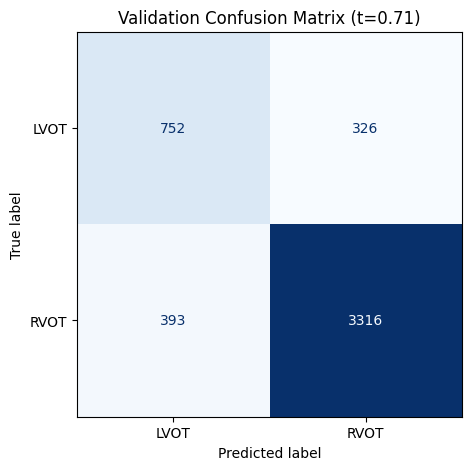

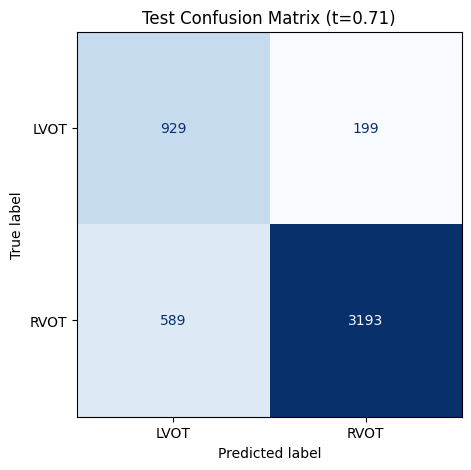

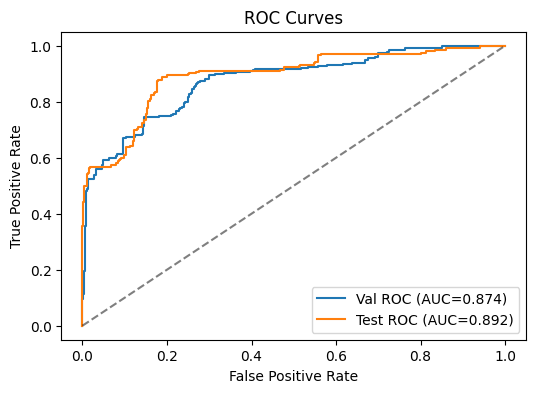

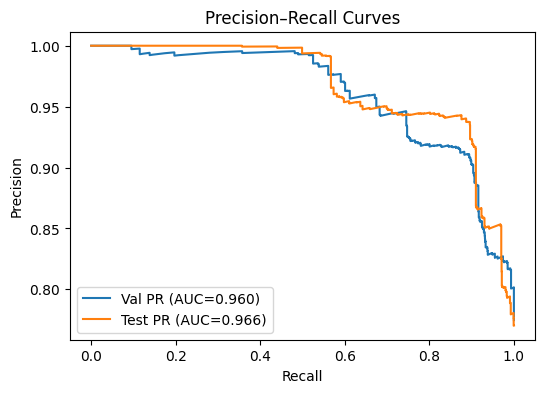

In [ ]:
X_train_B        = pd.read_pickle("outputs/X_train_B.pkl")
y_train_B        = pd.read_pickle("outputs/y_train_B.pkl")
X_val_B          = pd.read_pickle("outputs/X_val_B.pkl")
y_val_B          = pd.read_pickle("outputs/y_val_B.pkl")
X_test_B         = pd.read_pickle("outputs/X_test_B.pkl")
y_test_B         = pd.read_pickle("outputs/y_test_B.pkl")
patients_train_B = pd.read_pickle("outputs/patients_train_B.pkl")
patients_val_B   = pd.read_pickle("outputs/patients_val_B.pkl")
patients_test_B  = pd.read_pickle("outputs/patients_test_B.pkl")

print("Loaded datasets from pickle files:")
print(f"  X_train_B shape: {X_train_B.shape}")
print(f"  X_val_B   shape: {X_val_B.shape}")
print(f"  X_test_B  shape: {X_test_B.shape}\n")

if train_model_B:
    # Broad random search to get a strong baseline (.ubj + meta JSON)
    PARAM_SPACE_B = {
        "n_estimators":     (50, 250),
        "learning_rate":    (0.01, 0.3),
        "max_depth":        (1, 20),
        "subsample":        (0.7, 0.9),
        "colsample_bytree": (0.7, 0.9),
        "reg_alpha":        (0.0, 3.0),
        "reg_lambda":       (0.0, 3.0),
        "gamma":            (0.0, 3.0),
        "min_child_weight": (1, 10),
    }

    RESULTS_PICKLE_B      = "outputs/xgb_search_B.pkl"
    CANDIDATE_MODEL_BIN_B = "outputs/xgb_candidate_model_B.ubj"
    random_search_xgb(
        X_train        = X_train_B,
        y_train        = y_train_B,
        patients_train = patients_train_B,
        X_val          = X_val_B,
        y_val          = y_val_B,
        patients_val   = patients_val_B,
        X_test         = X_test_B,
        y_test         = y_test_B,
        patients_test  = patients_test_B,
        param_space    = PARAM_SPACE_B,
        results_path   = RESULTS_PICKLE_B,
        best_model_bin = CANDIDATE_MODEL_BIN_B,
        iterations     = ITERS_RANDOM_SEARCH_B
    )


    history        = pickle.load(open(RESULTS_PICKLE_B, "rb"))
    best_meta_json = history["best"].get("meta_path")
    assert best_meta_json and Path(best_meta_json).exists(), "Meta JSON missing!"
    with open(best_meta_json) as fp:
        baseline_params_full = json.load(fp)["xgb_params"]

    REL_MARGIN = 0.20  # +/-20% for most params
    rel_range = {
        k: ((1 - 0.10, 1 + 0.10) if k == "n_estimators" else (1 - REL_MARGIN, 1 + REL_MARGIN))
        for k in baseline_params_full
    }

    study, summary = optuna_fine_tune_best_xgb(
        best_model_bin = CANDIDATE_MODEL_BIN_B,
        best_meta_json = best_meta_json,
        X_train        = X_train_B,      y_train = y_train_B,      patients_train = patients_train_B,
        X_val          = X_val_B,        y_val   = y_val_B,        patients_val   = patients_val_B,
        X_test         = X_test_B,       y_test  = y_test_B,       patients_test  = patients_test_B,
        n_trials       = ITERS_OPTUNA_B,
        study_storage  = "sqlite:///models/xgb_model_b_optuna.db",
        study_name     = "xgb_fine_tune_b",
        output_dir     = "models/model_b",
        rel_range      = rel_range,
    )
    print("- Tuning summary\n", json.dumps(summary, indent=2))


    best_model_path_B = summary["model_path"]
    if best_model_path_B.endswith(".json"):
        booster = xgb.XGBClassifier()
        booster.load_model(best_model_path_B)
        ubj_path = best_model_path_B[:-5] + ".ubj"
        booster.save_model(ubj_path)
        summary["model_path"] = ubj_path
        best_model_path_B = ubj_path
        print(f"Converted Optuna model to UBJ ➜ {ubj_path}")

    best_model_B = xgb.XGBClassifier()
    best_model_B.load_model(best_model_path_B)

    evaluate_with_auto_threshold(
        best_model_B,
        X_train_B, y_train_B,
        X_val_B,   y_val_B,
        X_test_B,  y_test_B,
        calibrate=True,
    )

Selecting top 50 features by SHAP
Top SHAP features: ['ecg_feature_3', 'BMI', 'Age', 'PVC_transition_V1', 'Height', 'ecg_feature_2', 'Weight', 'DLP', 'PVC_transition_V2', 'ecg_feature_1', 'ecg_feature_12', 'PVC_transition_V4', 'HTA', 'ecg_feature_6', 'ecg_feature_27', 'PVC_transition_V6', 'ecg_feature_15', 'DM', 'PVC_transition_V5', 'PVC_transition_V3', 'ecg_feature_48', 'ecg_feature_139', 'ecg_feature_14', 'ecg_feature_37', 'ecg_feature_68', 'ecg_feature_22', 'ecg_feature_200', 'Sex', 'Smoker', 'ecg_feature_40', 'ecg_feature_104', 'ecg_feature_129', 'ecg_feature_46', 'ecg_feature_31', 'Sleep_apnea', 'ecg_feature_18', 'ecg_feature_168', 'ecg_feature_29', 'ecg_feature_4', 'ecg_feature_99', 'ecg_feature_10', 'ecg_feature_17', 'ecg_feature_100', 'ecg_feature_155', 'COPD', 'ecg_feature_69', 'ecg_feature_11', 'ecg_feature_174', 'ecg_feature_144', 'ecg_feature_141'] 

[Iter 1/30] 🎉 New best cv_macro_f1=0.6930, val_macro_f1_at_thresh=0.7221, test_macro_f1=0.7680
            params = {'n_estim

[I 2025-06-04 13:22:58,303] A new study created in RDB with name: xgb_fine_tune_b_lite


→ Fine-tuning around baseline: n_estimators=17, max_depth=1


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-04 13:22:58,547] Trial 0 finished with value: 0.7149406106923517 and parameters: {'learning_rate': 0.16878961004480475, 'subsample': 0.7858150161199191, 'colsample_bytree': 0.7556099621500056, 'reg_alpha': 2.2698234177619683, 'reg_lambda': 2.5647969280239082, 'gamma': 0.6000775716300923, 'min_child_weight': 7.755381015719266}. Best is trial 0 with value: 0.7149406106923517.
[I 2025-06-04 13:22:58,742] Trial 1 finished with value: 0.7215074190130499 and parameters: {'learning_rate': 0.21862150832239544, 'subsample': 0.886854924124914, 'colsample_bytree': 0.7487395527371807, 'reg_alpha': 2.0147480868777996, 'reg_lambda': 2.233812869770453, 'gamma': 0.7295375724103738, 'min_child_weight': 7.749240088744831}. Best is trial 1 with value: 0.7215074190130499.
[I 2025-06-04 13:22:58,985] Trial 2 finished with value: 0.7144349740089394 and parameters: {'learning_rate': 0.19446567159941777, 'subsample': 0.873423604936158, 'colsample_bytree': 0.8155477194144144, 'reg_alpha': 2.73132765

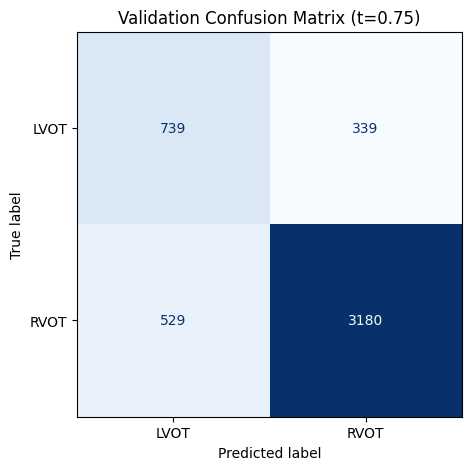

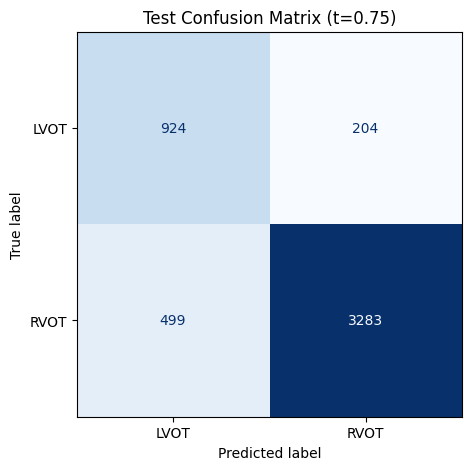

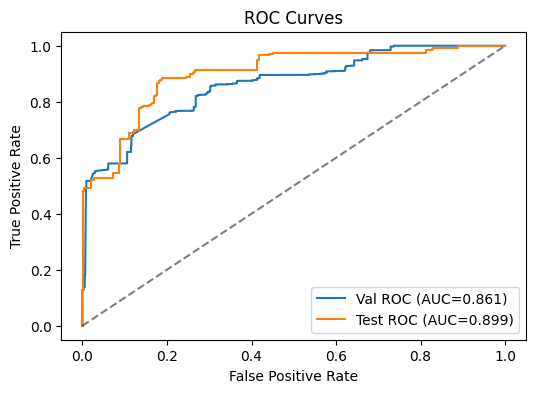

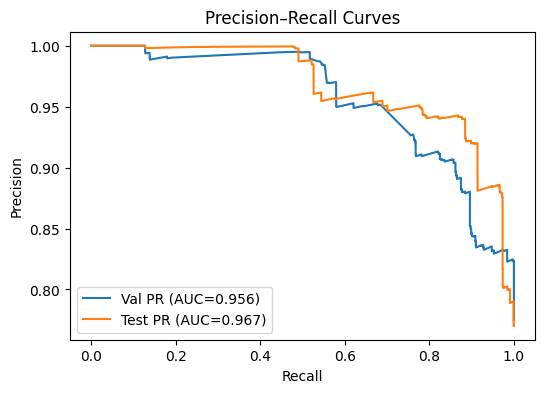

In [ ]:
if train_model_B_lite:
    # Broad random search to get a strong baseline (.ubj + meta JSON)
    PARAM_SPACE_B_LITE = {
        "n_estimators":     (15, 20),
        "learning_rate":    (0.01, 0.3),
        "max_depth":        (1, 1),
        "subsample":        (0.7, 0.9),
        "colsample_bytree": (0.7, 0.9),
        "reg_alpha":        (0.0, 3.0),
        "reg_lambda":       (0.0, 3.0),
        "gamma":            (0.0, 3.0),
        "min_child_weight": (1, 10),
    }

    RESULTS_PICKLE_B_LITE      = "outputs/xgb_search_B_lite.pkl"
    CANDIDATE_MODEL_BIN_B_LITE = "outputs/xgb_candidate_model_B_lite.ubj"
    random_search_xgb(
        X_train        = X_train_B,
        y_train        = y_train_B,
        patients_train = patients_train_B,
        X_val          = X_val_B,
        y_val          = y_val_B,
        patients_val   = patients_val_B,
        X_test         = X_test_B,
        y_test         = y_test_B,
        patients_test  = patients_test_B,
        param_space    = PARAM_SPACE_B_LITE,
        results_path   = RESULTS_PICKLE_B_LITE,
        best_model_bin = CANDIDATE_MODEL_BIN_B_LITE,
        iterations     = ITERS_RANDOM_SEARCH_B_LITE
    )

    history        = pickle.load(open(RESULTS_PICKLE_B_LITE, "rb"))
    best_meta_json = history["best"].get("meta_path")
    assert best_meta_json and Path(best_meta_json).exists(), "Meta JSON missing!"
    with open(best_meta_json) as fp:
        baseline_params_full = json.load(fp)["xgb_params"]

    REL_MARGIN = 0.20  # +/-20% for most params
    rel_range = {
        k: ((1 - 0.10, 1 + 0.10) if k == "n_estimators" else (1 - REL_MARGIN, 1 + REL_MARGIN))
        for k in baseline_params_full
    }

    study, summary = optuna_fine_tune_best_xgb(
        best_model_bin = CANDIDATE_MODEL_BIN_B,
        best_meta_json = best_meta_json,
        X_train        = X_train_B,      y_train = y_train_B,      patients_train = patients_train_B,
        X_val          = X_val_B,        y_val   = y_val_B,        patients_val   = patients_val_B,
        X_test         = X_test_B,       y_test  = y_test_B,       patients_test  = patients_test_B,
        n_trials       = ITERS_OPTUNA_B,
        study_storage  = "sqlite:///models/xgb_model_b_lite_optuna.db",
        study_name     = "xgb_fine_tune_b_lite",
        output_dir     = "models/model_b_lite",
        rel_range      = rel_range,
    )
    print("- Tuning summary\n", json.dumps(summary, indent=2))


    best_model_path_B = summary["model_path"]
    if best_model_path_B.endswith(".json"):
        booster = xgb.XGBClassifier()
        booster.load_model(best_model_path_B)
        ubj_path = best_model_path_B[:-5] + ".ubj"
        booster.save_model(ubj_path)
        summary["model_path"] = ubj_path
        best_model_path_B = ubj_path
        print(f"Converted Optuna model to UBJ ➜ {ubj_path}")

    best_model_B = xgb.XGBClassifier()
    best_model_B.load_model(best_model_path_B)

    evaluate_with_auto_threshold(
        best_model_B,
        X_train_B, y_train_B,
        X_val_B,   y_val_B,
        X_test_B,  y_test_B,
        calibrate=True,
    )


## 7. Model C: Classification of the sub-regions


Loaded datasets from pickle files:
  X_train_C shape: (803, 217)
  X_val_C   shape: (636, 217)
  X_test_C  shape: (396, 217)

Selecting top 50 features by SHAP
Top SHAP features: ['Weight', 'Height', 'BMI', 'ecg_feature_2', 'ecg_feature_3', 'Age', 'ecg_feature_18', 'ecg_feature_103', 'ecg_feature_105', 'ecg_feature_183', 'HTA', 'DM', 'PVC_transition_V3', 'ecg_feature_4', 'ecg_feature_1', 'ecg_feature_132', 'ecg_feature_125', 'ecg_feature_21', 'ecg_feature_54', 'ecg_feature_9', 'ecg_feature_75', 'ecg_feature_84', 'ecg_feature_153', 'ecg_feature_168', 'ecg_feature_101', 'ecg_feature_147', 'ecg_feature_77', 'ecg_feature_8', 'ecg_feature_191', 'ecg_feature_11', 'ecg_feature_128', 'ecg_feature_27', 'ecg_feature_181', 'ecg_feature_35', 'ecg_feature_111', 'ecg_feature_44', 'ecg_feature_157', 'ecg_feature_148', 'ecg_feature_145', 'ecg_feature_146', 'ecg_feature_154', 'ecg_feature_149', 'ecg_feature_150', 'ecg_feature_151', 'ecg_feature_156', 'ecg_feature_152', 'ecg_feature_143', 'ecg_feature_1

[I 2025-06-04 13:24:47,380] Using an existing study with name 'xgb_fine_tune_c' instead of creating a new one.


→ Fine-tuning around baseline: n_estimators=85, max_depth=9


  0%|          | 0/10 [00:00<?, ?it/s]

invalid value encountered in subtract
invalid value encountered in subtract


[I 2025-06-04 13:24:47,599] Trial 160 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08265174705939318, 'subsample': 0.918533675652032, 'colsample_bytree': 0.9035372130772646, 'reg_alpha': 0.8455738826794027, 'reg_lambda': 0.20727757426454613, 'gamma': 2.1722275828797668e-05, 'min_child_weight': 9.220522099785581}. Best is trial 0 with value: 0.9553527553527553.
[I 2025-06-04 13:24:47,768] Trial 161 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08299470548846383, 'subsample': 0.9393723797716955, 'colsample_bytree': 0.9333572711490008, 'reg_alpha': 0.9596730826093111, 'reg_lambda': 0.20403774056060836, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 10.132388568757108}. Best is trial 0 with value: 0.9553527553527553.


invalid value encountered in subtract


[I 2025-06-04 13:24:47,944] Trial 162 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08396939192537974, 'subsample': 0.8081935741340172, 'colsample_bytree': 0.9330213639845323, 'reg_alpha': 1.0491178961805636, 'reg_lambda': 0.21756990338480722, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 9.058400068873132}. Best is trial 0 with value: 0.9553527553527553.


invalid value encountered in subtract
invalid value encountered in subtract


[I 2025-06-04 13:24:48,157] Trial 163 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08420657340692211, 'subsample': 0.7551302244117493, 'colsample_bytree': 0.920238962837816, 'reg_alpha': 0.9396664297685569, 'reg_lambda': 0.1886083316225086, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 9.676103937238562}. Best is trial 0 with value: 0.9553527553527553.


invalid value encountered in subtract


[I 2025-06-04 13:24:48,369] Trial 164 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.0844032941505443, 'subsample': 0.7844672242568026, 'colsample_bytree': 0.9260617142951206, 'reg_alpha': 0.8264838552691797, 'reg_lambda': 0.24790754611582777, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 7.893153378276448}. Best is trial 0 with value: 0.9553527553527553.
[I 2025-06-04 13:24:48,563] Trial 165 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08480706980732391, 'subsample': 0.8147636532338492, 'colsample_bytree': 0.8938695012709723, 'reg_alpha': 1.017061964863592, 'reg_lambda': 0.2476801579538815, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 11.33177110868812}. Best is trial 0 with value: 0.9553527553527553.


invalid value encountered in subtract
invalid value encountered in subtract


[I 2025-06-04 13:24:48,755] Trial 166 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08502283478013944, 'subsample': 0.9209175589043641, 'colsample_bytree': 0.933475230833263, 'reg_alpha': 1.183554906409082, 'reg_lambda': 0.24750754697324975, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 9.547218426981729}. Best is trial 0 with value: 0.9553527553527553.
[I 2025-06-04 13:24:48,939] Trial 167 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.08507338214893144, 'subsample': 0.8626607115416243, 'colsample_bytree': 0.9123727178522175, 'reg_alpha': 1.1254014967029087, 'reg_lambda': 0.24853234026081517, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 8.991268559984517}. Best is trial 0 with value: 0.9553527553527553.


invalid value encountered in subtract
invalid value encountered in subtract


[I 2025-06-04 13:24:49,207] Trial 168 finished with value: 0.5521587171052631 and parameters: {'learning_rate': 0.08311612620784793, 'subsample': 0.9103608550694374, 'colsample_bytree': 0.9337930092842379, 'reg_alpha': 1.17492174934802, 'reg_lambda': 0.17201023903320306, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 7.898968497063867}. Best is trial 0 with value: 0.9553527553527553.
[I 2025-06-04 13:24:49,391] Trial 169 finished with value: 0.4111111111111111 and parameters: {'learning_rate': 0.0820634030006665, 'subsample': 0.7799368059244575, 'colsample_bytree': 0.9334304263353664, 'reg_alpha': 0.832902743856888, 'reg_lambda': 0.24896266975430656, 'gamma': 2.4456482631057004e-05, 'min_child_weight': 8.04186619002252}. Best is trial 0 with value: 0.9553527553527553.
No validation gain — original model retained.
- Tuning summary
 {
  "val_macro_f1": 0.4105653382761817,
  "test_macro_f1": 0.4098360655737705,
  "params": {
    "learning_rate": 0.1737924734731088,
    "subsample": 

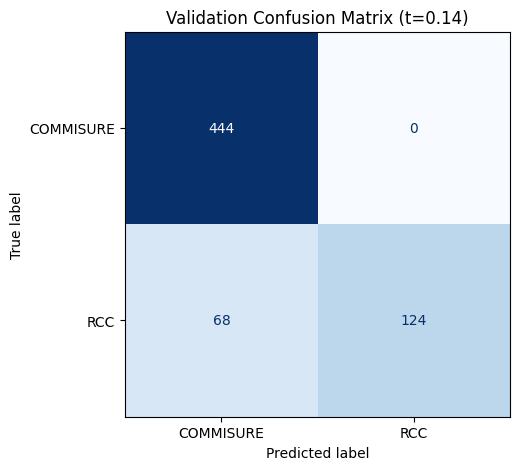

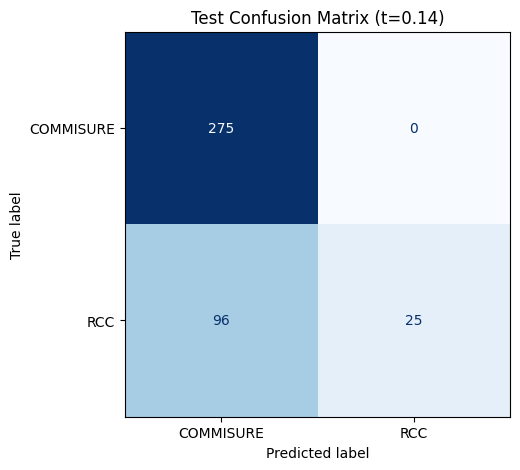

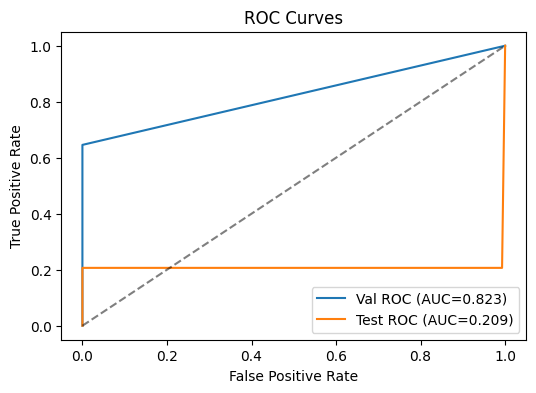

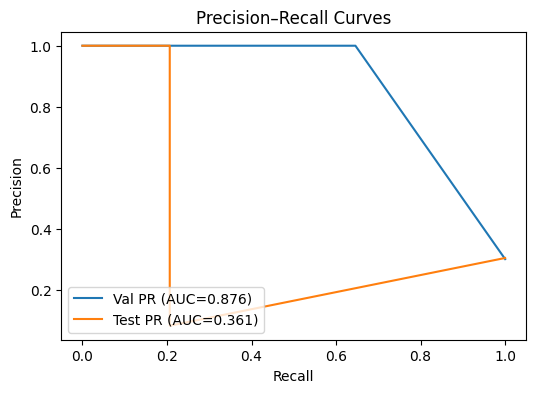

In [ ]:
X_train_C        = pd.read_pickle("outputs/X_train_C.pkl")
y_train_C        = pd.read_pickle("outputs/y_train_C.pkl")
X_val_C          = pd.read_pickle("outputs/X_val_C.pkl")
y_val_C          = pd.read_pickle("outputs/y_val_C.pkl")
X_test_C         = pd.read_pickle("outputs/X_test_C.pkl")
y_test_C         = pd.read_pickle("outputs/y_test_C.pkl")
patients_train_C = pd.read_pickle("outputs/patients_train_C.pkl")
patients_val_C   = pd.read_pickle("outputs/patients_val_C.pkl")
patients_test_C  = pd.read_pickle("outputs/patients_test_C.pkl")

print("Loaded datasets from pickle files:")
print(f"  X_train_C shape: {X_train_C.shape}")
print(f"  X_val_C   shape: {X_val_C.shape}")
print(f"  X_test_C  shape: {X_test_C.shape}\n")

if train_model_C:
    # Broad random search to get a strong baseline (.ubj + meta JSON)
    PARAM_SPACE_C = {
        "n_estimators":     (10, 200),
        "learning_rate":    (0.01, 0.2),
        "max_depth":        (5, 15),
        "subsample":        (0.7, 0.9),
        "colsample_bytree": (0.7, 0.9),
        "reg_alpha":        (0.0, 3.0),
        "reg_lambda":       (0.0, 3.0),
        "gamma":            (0.0, 3.0),
        "min_child_weight": (1, 10),
    }

    RESULTS_PICKLE_C      = "outputs/xgb_search_C.pkl"
    CANDIDATE_MODEL_BIN_C = "outputs/xgb_candidate_model_C.ubj"
    random_search_xgb(
        X_train        = X_train_C,
        y_train        = y_train_C,
        patients_train = patients_train_C,
        X_val          = X_val_C,
        y_val          = y_val_C,
        patients_val   = patients_val_C,
        X_test         = X_test_C,
        y_test         = y_test_C,
        patients_test  = patients_test_C,
        param_space    = PARAM_SPACE_C,
        results_path   = RESULTS_PICKLE_C,
        best_model_bin = CANDIDATE_MODEL_BIN_C,
        iterations     = ITERS_RANDOM_SEARCH_C,
        smote_ratio    = 0.30  # Oversample minority to 30% of majority
    )

    history        = pickle.load(open(RESULTS_PICKLE_C, "rb"))
    best_meta_json = history["best"].get("meta_path")
    assert best_meta_json and Path(best_meta_json).exists(), "Meta JSON missing!"
    with open(best_meta_json) as fp:
        baseline_params_full = json.load(fp)["xgb_params"]

    REL_MARGIN = 0.20  # +/-20% for most params
    rel_range = {
        k: ((1 - 0.10, 1 + 0.10) if k == "n_estimators" else (1 - REL_MARGIN, 1 + REL_MARGIN))
        for k in baseline_params_full
    }

    study, summary = optuna_fine_tune_best_xgb(
        best_model_bin = CANDIDATE_MODEL_BIN_C,
        best_meta_json = best_meta_json,
        X_train        = X_train_C,      y_train = y_train_C,      patients_train = patients_train_C,
        X_val          = X_val_C,        y_val   = y_val_C,        patients_val   = patients_val_C,
        X_test         = X_test_C,       y_test  = y_test_C,       patients_test  = patients_test_C,
        n_trials       = ITERS_OPTUNA_C,
        study_storage  = "sqlite:///models/xgb_model_c_optuna.db",
        study_name     = "xgb_fine_tune_c",
        output_dir     = "models/model_c",
        rel_range      = rel_range,
    )
    print("- Tuning summary\n", json.dumps(summary, indent=2))

    best_model_path_C = summary["model_path"]
    if best_model_path_C.endswith(".json"):
        booster = xgb.XGBClassifier()
        booster.load_model(best_model_path_C)
        ubj_path = best_model_path_C[:-5] + ".ubj"
        booster.save_model(ubj_path)
        summary["model_path"] = ubj_path
        best_model_path_C = ubj_path
        print(f"Converted Optuna model to UBJ ➜ {ubj_path}")

    best_model_C = xgb.XGBClassifier()
    best_model_C.load_model(best_model_path_C)

    evaluate_with_auto_threshold(
        best_model_C,
        X_train_C, y_train_C,
        X_val_C,   y_val_C,
        X_test_C,  y_test_C,
        calibrate=True,
    )


## 9. Final model evaluation and interpretation

In [ ]:
# TODO: unified steps to interpret a model output, can be called with any of the trained models